# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# import libraries here; add more as necessary 

import DataScienceHelperLibrary as dsh # my helper library https://github.com/bwenner/DataScienceHelperLibrary

import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime
from importlib import reload

from imblearn.over_sampling import SMOTE

from IPython.display import HTML
from IPython.display import display, clear_output

from sklearn.model_selection import StratifiedKFold

from sklearn import preprocessing
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import learning_curve



# magic word for producing visualizations in notebook
%matplotlib inline

### Load dada and quick check

In [ ]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [7]:
customers = dsh.RemoveColumnsByWildcard(customers, ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'])

-------------------- Start finding and removing columns matchting to wildcards: ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'] --------------------
Columns found to remove:  3
-------------------- Finished removing columns matchting to wildcards --------------------


In [ ]:
gc.collect()

In [ ]:
print(azdias.shape)
dsh.TailHead(azdias, 5)

In [ ]:
azdias.describe()

In [ ]:
print(customers.shape)
dsh.TailHead(customers, 5)

In [ ]:
customers.describe()

### Create config class and load info files

I did following pre configurations based on file review.

In [8]:
class CleanConfig:
    
    LowestIdentify = [
        'no *', 'none*', '*low*', '*poorer*', '*urban*', '*demanding*', '*lowest*', '*marginal*', 
        '*minimal*', '*>*24*month*', '*than*24*month*' '*unlikely*', '*demoted*', '*poor*'
]

    UnknownIdentify = [
        '*unknown*', 
        '*no*classification*possible*', 
        '*classification*not*possible*', 
        'no*score*',
        '*no*transaction*known*'
]
    
    ColumnValues = {}
    
    DropColumns = []     
    
    ConvertToFloat = []
    
    ColumnsToLogScale = []
    
    ColumnsToOneHotEnc = []
    
    NumericalColumns = []

    
    RowsToTropByMisNan = 0.2
    ColumnsToDropByMisNan = 0.3
    SkewLimitForLog = 1
    
    
    ColumnsWithoutInfo = []
    
    AttributesNotInAzdias = []
    
    AttributeLevelsNotInAzdias  = []
    
    ColumnsReorderValues = []
    
    ColumnsSummarize = {}
    
    Imputer = preprocessing.Imputer(missing_values = 'NaN', strategy = 'median', axis = 0)
    Scaler = preprocessing.StandardScaler()
    ImputerBinary = preprocessing.Imputer(missing_values = 'NaN', strategy = 'most_frequent')
    
    

class ColumnValues:
    def __init__(self, columnName):
        self.ColumnName = columnName
        self.UnknownValues = []
        self.KnownValues = []
        self.AllValues = []
        self.MissingDesc = []
        self.Meanings = []
        self.LowestValue = 0
        self.DType = None
        self.Description = ''
        self.Group = ''
        self.SingleValues = {}
        self.NotConvertable = []
        
    def Add(self, isunknown, value):
        if isunknown:
            self.UnknownValues.append(value)
        else:
            self.KnownValues.append(value)
        self.AllValues.append(value)

    def IsNumeric(self):
        return self.DType in dsh.NumberTypes

def ReadAttributeFiles():
    xlAttributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
    xlInfos = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
    return xlAttributes, xlInfos



def PlotValueCounts(df, cols, kind = 'bar', hor = 1 , figsize = (20, 15)):
    '''
    Plot of value_counts.
    
    INPUT:
    df: Dataframe
    kind: plot kind
    hor: Figure seize height
    figsize: Figure seize
    hor: horizontal
    
    OUTPUT:
    returns axes
    '''
    cols = dsh.GetAsList(cols)
    
    if len(cols) == 1:
        return df[cols[0]].value_counts().sort_index().plot(kind = kind)
    lim = len(cols) + 1
    ax = None
    plt.figure(figsize = figsize)
    if hor == 1:
        
        for ind in range(1, lim):
            col = cols[ind - 1]
            ax = plt.subplot(1, lim, ind)
            ax = df[col].value_counts().sort_index().plot(kind = kind)
            ax.set_title('Value counts:\n' + col)
    else:
        for ind in range(1, lim):
            col = cols[lim - 1]
            ax = plt.subplot(lim, 1, ind)
            ax = df[col].value_counts().sort_index().plot(kind = kind)
            ax.set_title('Value counts:\n' + col)
    return ax

def PlotCompare(df1, df2, columns, kind = 'Bar', fzh = 5, name1 = 'Azdias', name2 = 'Customers'):
    '''
    Plot of values.
    
    INPUT:
    df1,2: Dataframe
    kind: plot kind
    fzh: Figure seize height
    name1,2: Titles for left and right
    
    OUTPUT:
    returns plotted dataframe
    '''
    lim = 1
    fzh = len(columns) * fzh
    v, h = len(columns), 2
    plt.figure(figsize = (20, fzh))
    for ind, col in enumerate(columns):
        plt.subplot(v, h, 2 * ind + 1)
        ax = (df1[col].value_counts().sort_index() / df1.shape[0] * 100).plot(kind = kind)
        ax.set_title(col + ' - {}'.format(name1))
        ax.set_ylabel('Percent of whole data set')
        plt.subplot(v, h, 2 * ind + 2)
        ax = (df2[col].value_counts().sort_index() / df2.shape[0] * 100).plot(kind = kind)
        ax.set_title(col + ' - {}'.format(name2))
        ax.set_ylabel('Percent of whole data set')

def PlotCompareDist(df1, df2, columns, kind = 'Bar', fzh = 5, name1 = 'Azdias', name2 = 'Customers'):
    '''
    Box plot of values.
    
    INPUT:
    df1,2: Dataframe
    kind: plot kind
    fzh: Figure seize height
    name1,2: Titles for left and right
    
    OUTPUT:
    returns plotted dataframe
    '''
    lim = 1
    fzh = len(columns) * fzh
    v, h = len(columns), 2
    plt.figure(figsize = (20, fzh))
    for ind, col in enumerate(columns):
        plt.subplot(v, h, 2 * ind + 1)
        ax = sns.boxplot(df1[col])
        ax.set_title(col + ' - {}'.format(name1))
        ax.set_ylabel('Percent of whole data set')
        plt.subplot(v, h, 2 * ind + 2)
        ax = sns.boxplot(df2[col])
        ax.set_title(col + ' - {}'.format(name2))
        ax.set_ylabel('Percent of whole data set')

def PlotIsNullDist(df, top = 100, axis = 0, toplabels = 20, kind = 'bar', figsize = (8, 8)):
    '''
    Plot distribution of null values.
    
    INPUT:
    df: Dataframe
    top: when axis = 1, consider top sorted
    toplabels: print top sorted
    kind: chart
    
    OUTPUT:
    returns plotted dataframe
    '''
    
    dfPlt = None
    plt.figure(figsize = figsize)
    if axis == 0:
        dfPlt = df.isnull().sum(axis = axis).sort_values(ascending = False)[:top]
        dfPlt = dfPlt.apply(lambda x: (x * 100) / df.shape[0])
        ax = dfPlt.plot(kind = kind)
        _ = ax.set_title('Missing values in feature')
        print(dfPlt[:toplabels])
    else:
        vc = df.isnull().sum(axis = axis).value_counts()
        dfPlt = pd.DataFrame(data=vc.values, index = vc.index)
        toplabels = dfPlt.shape[1]
        ax = dfPlt.plot(kind = kind)
        _ = ax.set_title('Value count overview')
        _ = ax.set_ylabel('Number of rows...')
        _ = ax.set_xlabel('... having # nan values')
        print(dfPlt)
    ax.set_xticklabels([])
    
    return dfPlt, ax    


def PlotCalcMean(df):
    tmp = []
    dfsum = CalcMeanOutlinerRows(df)
    for ind in range(11):
        tmp.append(dfsum[dfsum.between(0.0, ind / 11)].shape[0] / dfsum.shape[0])

    tmp = pd.DataFrame(tmp)
    ax = tmp.plot(kind = 'bar')
    ax.set_xticks([x + 0.5 for x in range(0, 11)])
    ax.set_xlabel('% missing values')
    ax.set_ylabel('% of dataset')
    ax.set_xticklabels([str(x) for x in range(0, 110, 10)])

    return tmp, ax
    
    
def PlotHeatmap(df):
    return sns.heatmap(df, cmap = 'Blues')

def PlotSubSet(df1, df2, ind):
    title = 'Distribution for the feature: ' + df1.columns[ind]
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    sns.countplot(df1.iloc[:, ind].values, color = 'blue')
    plt.subplot(1, 2, 2)
    if all(np.isnan(df2.iloc[:, ind].values)):
        #sns.countplot(df2.iloc[:, ind].values, color = 'blue')
        pass
    else:
        sns.countplot(df2.iloc[:, ind].values, color = 'blue')
        
def PlotHeatmap3(df1, df2, df3):
    plt.figure(figsize = (20,15))
    plt.subplot(2, 2, 1)
    ax = PlotHeatmap(df1)
    ax.set_title('Dropped rows')
    plt.subplot(2, 2, 2)
    _ = PlotHeatmap(df2)
    ax.set_title('Considered rows')
    plt.subplot(2, 2, 3)
    _ = PlotHeatmap(df3)
    _ = ax.set_title('Currently all rows')
    
att, inf = ReadAttributeFiles()

In [ ]:
att.head()

In [ ]:
inf.head()

In [ ]:
lastlevel = ''
for ind, row in inf.iterrows():
    if type(row['Information level']) == str and len(row['Information level']) > 0:
        lastlevel = row['Information level']
        continue
    if type(row['Information level']) != str and np.isnan(row['Information level']):
        inf.loc[ind, 'Information level'] = lastlevel
        
inf.loc[0, 'Information level'] = inf.loc[1, 'Information level'] = lastlevel

ax = inf['Information level'].value_counts().plot(kind = 'bar')
ax.set_title('Information level')
ax.set_ylabel('# features')
_ = ax.set_xlabel('Information levels')

In [9]:
def LoadColumnsAndValuesInfos(df):
    '''
    Load excel files and initialize CleanConfig
    '''
    xlAttributes, xlInfos = ReadAttributeFiles()
    currentAttrib = ''
    count = 0
    colVal = None

    # iterate over all rows
    
    meaning = ''
    for ind, row in xlAttributes.iterrows():
        
        # remember the current row
        if row['Attribute'] is not np.nan:

            if colVal is not None:
                if not colVal.IsNumeric():
                    colVal.MissingDesc = set(df[colVal.ColumnName].unique()) - set(colVal.AllValues)
                
            currentAttrib = row['Attribute'].replace('CAMEO_DEUINTL_2015', 'CAMEO_INTL_2015') 
            currentAttrib = currentAttrib.replace('SOHO_FLAG', 'SOHO_KZ')
            currentAttrib = currentAttrib.replace('_RZ', '')
            
            if 'D19_KK_KUNDENTYP' in currentAttrib:
                currentAttrib = 'KK_KUNDENTYP'
            elif 'D19_BUCH_' in currentAttrib:
                currentAttrib = 'D19_BUCH_CD'
            
            currentAttrib = currentAttrib.strip()
            
            if currentAttrib not in df.columns:
                CleanConfig.AttributesNotInAzdias.append(currentAttrib)
                colVal = None
                continue
                
            colVal = ColumnValues(currentAttrib)
            colVal.DType = df[currentAttrib].dtype
            CleanConfig.ColumnValues[colVal.ColumnName] = colVal
            
        # When row is not contained in azdias
        if colVal is None:
            continue
        
        # handle descriptions for merged cells
        if str(row['Meaning']) != 'nan':
            meaning = str(row['Meaning'])
        
        colVal.Meanings.append(meaning.split('\n')[0])
        isunknown = any(dsh.IsMatch(meaning, x) for x in CleanConfig.UnknownIdentify)
        currentVal = row['Value']
        
        # if value is a number, then add and continue
        # else try to split and parse to float
        # else add the original string value.
        try:
            if type(currentVal) != str:
                colVal.Add(isunknown, currentVal)
                colVal.Add(isunknown, str(currentVal))
                colVal.Add(isunknown, str(float(currentVal)))
                colVal.SingleValues[str(currentVal)] = meaning
                colVal.SingleValues[currentVal] = meaning

                if any(dsh.IsMatch(meaning, x) for x in CleanConfig.LowestIdentify):
                    if colVal.LowestValue < currentVal:
                        colVal.LowestValue = currentVal
                continue

            currentVal = currentVal.strip()

            # skip numerical columns
            if '...' in currentVal:
                # current column is numerical
                CleanConfig.NumericalColumns.append(col)
                continue
            
            if ',' in currentVal:
                splt = currentVal.split(',')
                for val in splt:
                    try:
                        val = val.strip()
                        colVal.Add(isunknown, val)
                        colVal.SingleValues[val] = meaning
                        flt = float(val)
                        colVal.Add(isunknown, flt)
                        colVal.Add(isunknown, str(flt))
                        colVal.SingleValues[flt] = meaning

                        if any(dsh.IsMatch(meaning, x) for x in CleanConfig.LowestIdentify):
                            if colVal.LowestValue < flt:
                                colVal.LowestValue = flt

                    except:
                        colVal.Add(isunknown, val)
                        colVal.SingleValues[val] = meaning
            else:
                colVal.SingleValues[currentVal] = meaning
                colVal.Add(isunknown, currentVal)
                
                try:
                    flt = float(currentVal)
                    colVal.SingleValues[currentVal] = meaning
                    colVal.Add(isunknown, currentVal)
                except:
                    pass
        except:
            print('Error while processing row {} with value "{}"'.format(ind, currentVal))          
    
       
    grp = ''
    desc = ''
    for ind, row in xlInfos.iterrows():
        
        col = row['Attribute']
        if len(col) == 0:
                continue
                
        desc = desc if str(row['Description']) == 'nan' else row['Description']
        grp = grp if str(row['Information level']) == 'nan' else row['Information level']

        col = col.strip()
        col = col.replace('_ ', '_').replace('_RZ', '')
        
        while ('  ' in col):
            col = col.replace('  ', ' ')
        
        for colsplt in col.split(' '):
            if len(colsplt) == 0:
                continue
                
            if colsplt in list(CleanConfig.ColumnValues.keys()):
                CleanConfig.ColumnValues[colsplt].Description = desc
                CleanConfig.ColumnValues[colsplt].Group = grp
                continue

            if colsplt not in df.columns:
                CleanConfig.AttributeLevelsNotInAzdias.append(colsplt)
                continue

            cv = ColumnValues(colsplt)
            cv.DType = df[colsplt].dtype
            cv.Description = desc
            cv.Group = grp

            CleanConfig.ColumnValues[colsplt] = cv
        
    for col in df.columns:
        if not col in CleanConfig.ColumnValues.keys():
            colVal = ColumnValues(col)
            colVal.DType = df[col].dtype
            colVal.AllValues = list(df[col].unique())
            CleanConfig.ColumnsWithoutInfo.append(col)
            CleanConfig.ColumnValues[colVal.ColumnName] = colVal  
        if df[col].dtype == object:
            cnt = 0
            for val in azdias[col].unique():
                try:
                    _ = float(val)
                except: 
                    cnt = cnt + 1
                    CleanConfig.ColumnValues[col].NotConvertable.append(val)
                if cnt > 50:
                    break    
        else: 
            if len(df[col].value_counts()) > 100 or df[col].max() > 100 or df[col].mean() > 1000:
                CleanConfig.NumericalColumns.append(col)
        
        if len(CleanConfig.ColumnValues[col].NotConvertable) > 0:
            dsh.PrintLine()
            print('Cannot convert values in {}: '.format(col), CleanConfig.ColumnValues[col].NotConvertable, '...')
    
    print('Columns and attributes successfully loaded')
    
LoadColumnsAndValuesInfos(azdias)

-------------------- - --------------------
Cannot convert values in CAMEO_DEU_2015:  [None, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C', '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D', '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F', '1C', 'XX'] ...
-------------------- - --------------------
Cannot convert values in CAMEO_DEUG_2015:  [None, 'X'] ...
-------------------- - --------------------
Cannot convert values in CAMEO_INTL_2015:  [None, 'XX'] ...
-------------------- - --------------------
Cannot convert values in D19_LETZTER_KAUF_BRANCHE:  [None, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK', 'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS', 'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD', 'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST', 'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_FREIZEIT', 'D19_LEBENSMITTEL', 'D19_HAUS_DEKO

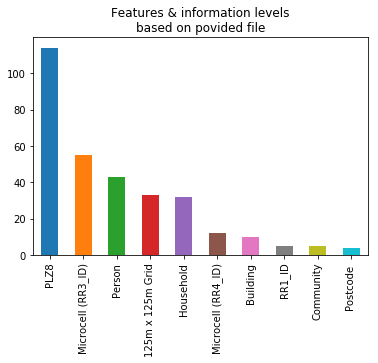

In [10]:
ax = inf.ffill().bfill()['Information level'].value_counts().plot(kind = 'bar')
_ = ax.set_title('Features & information levels\nbased on povided file')

### Features without description

In [11]:
inspect = []
for col in azdias.columns:
    if col in CleanConfig.DropColumns:
        continue
    
    if all([col in CleanConfig.ColumnsWithoutInfo,
        len(CleanConfig.ColumnValues[col].Meanings) == 0,
        len(CleanConfig.ColumnValues[col].Description) == 0]):
        print(col, azdias[col].unique())
        inspect.append(col)
        dsh.PrintLine()
        

LNR [910215 910220 910225 ... 825772 825776 825787]
-------------------- - --------------------
AKT_DAT_KL [nan  9.  1.  5.  8.  7.  6.  4.  3.  2.]
-------------------- - --------------------
ALTER_KIND1 [nan 17. 10. 18. 13. 16. 11.  6.  8.  9. 15. 14.  7. 12.  4.  3.  5.  2.]
-------------------- - --------------------
ALTER_KIND2 [nan 13.  8. 12. 10.  7. 16. 15. 14. 17.  5.  9. 18. 11.  6.  4.  3.  2.]
-------------------- - --------------------
ALTER_KIND3 [nan 10. 18. 17. 16.  8. 15.  9. 12. 13. 14. 11.  7.  5.  6.  4.]
-------------------- - --------------------
ALTER_KIND4 [nan 10.  9. 16. 14. 13. 11. 18. 17. 15.  8. 12.  7.]
-------------------- - --------------------
ALTERSKATEGORIE_FEIN [nan 21. 17. 13. 14. 10. 16. 20. 11. 19. 15. 18.  9. 22. 12.  0.  8.  7.
 23.  4. 24.  6.  3.  2.  5. 25.  1.]
-------------------- - --------------------
ANZ_KINDER [nan  0.  1.  2.  3.  4.  5.  6.  9.  7. 11.  8.]
-------------------- - --------------------
ANZ_STATISTISCHE_HAUSHALTE [ nan  

In [ ]:
azdias[(azdias['UMFELD_ALT'] > 3) & (azdias['UMFELD_JUNG'] > 3)].shape

In [ ]:
PlotCompare(
    azdias, 
    customers, 
    columns=['D19_LETZTER_KAUF_BRANCHE', 'D19_KONSUMTYP_MAX', 'VERDICHTUNGSRAUM', 'EXTSEL992',  'VHA', 'VHN', 'VK_DHT4A', 'VK_ZG11'], 
    fzh = 5
)

LNR stands for "laufende Nummer" ("running number") and is an index. So I drop this feature.

GEBAEUDE_TYP has values that are not accurate regarding 1=low and 5=high. I remind that in the update value part coming below.

Looking through the data I noticed two gaps:

- ARBEIT [nan, 1.0, 2.0, 3.0, 4.0, 5.0, 9.0]
- KOMBIALTER [1, 2, 3, 4, 9]

The first AZDIAS project provided the Data_Dictioanry.md file with information for following features so I use this information to encode them if necessary.

|1.23. TITEL_K|Z9.1. ARBEIT|
|-------------|------------|
|Academic title flag|Share of unemployment in community|
|1: unknown|1: unknown|
|0: unknown|1: very low|
|1: Dr.|2: low|
|2: Dr. Dr.|3: average|
|3: Prof.|4: high|
|4: Prof. Dr.|5: very high|
|5: other|9: unknown|

There is - beside 0, -1 - another identifier for unknown values, it's the 9. So I add this information to the corresponding list. I assume that 9 is also an identifier for missing values in feature KOMBIALTER.


And now the object features:

The feature EINGEFÜEGT_AM ("inserted on") is out of interest because it gives no information about a persons interest and will be dropped without being processed. Dito for D19_LETZTER_KAUF_BRANCHE (just describing the last buy in the relevant branche). If the values are relative equally distributed, I will consider all D19 columns (respectively those that make sense).

CAMEO_DEUG/INTEL_2015 can be converted to float. (CAMEO_INTL is discussed in the coming steps)

OST_WEST_KZ needs to be one hot encoded.

I'm quite unsure how to treat CAMEO_DEU_2015 because considering this feature would end in 44 new one-hot encoded features or just drop it after cleaning... I decide to drop the column.

I intended to check if 3 is a "limit" meaning: if U_ALT > 3 then is always U_JUNG < 3. But thats false.

"Letzter Kauf" means last buy and I just was interested into the distribution of the branches. Nevertheless, I will drop that column because I don't see any advantage of one-hot encoding this columns resulting in circa 30 new columns. Another idea how to handle this information would be to 

"Verdichtungsraum" (densely populated area) is based on "Einwohnerdichte" (population density, feature EWDICHTE) and "Gemeindegröße" (community size, feature ORTSGR_KLS9) so this feature can be dropped.

But the other columns VHA, VHN etc. don't say anything to me.

In [12]:
inspect.remove('LNR')
inspect.remove('EINGEFUEGT_AM')
inspect.remove('D19_LETZTER_KAUF_BRANCHE')
inspect.remove('VERDICHTUNGSRAUM')


CleanConfig.DropColumns.append('LNR')
CleanConfig.DropColumns.append('CAMEO_DEU_2015')
CleanConfig.DropColumns.append('EINGEFUEGT_AM')
#CleanConfig.DropColumns.append('D19_LETZTER_KAUF_BRANCHE')
CleanConfig.DropColumns.append('VERDICHTUNGSRAUM')


CleanConfig.ConvertToFloat.append('CAMEO_DEUG_2015')
CleanConfig.ConvertToFloat.append('CAMEO_INTL_2015')
CleanConfig.ConvertToFloat.append('OST_WEST_KZ')


for col in ['ARBEIT', 'KOMBIALTER']:
    CleanConfig.ColumnValues[col].UnknownValues.extend([9])

CleanConfig.ColumnValues['CAMEO_DEU_2015'].UnknownValues.extend(
    CleanConfig.ColumnValues['CAMEO_DEU_2015'].NotConvertable
)   
CleanConfig.ColumnValues['CAMEO_DEUG_2015'].UnknownValues.extend(
    CleanConfig.ColumnValues['CAMEO_DEUG_2015'].NotConvertable
)
CleanConfig.ColumnValues['CAMEO_INTL_2015'].UnknownValues.extend(
    CleanConfig.ColumnValues['CAMEO_INTL_2015'].NotConvertable
)
CleanConfig.ColumnValues['EINGEFUEGT_AM'].NotConvertable.clear() # don't want to keep that in memory

In [ ]:
PlotCompare(azdias, customers, columns=inspect, fzh = 5)

### Convert missing values and find values that are not documented

With the information from the provided files, I convert the missing values to np.nan before I continue my analysis.

UPDATE: 

I realized that I need to configure more columns as there have been columns with values that make no sense (for example -1 for years).

And I decided to drop PLZ8 columns (PLZ stands for Postleitzahl (zip code)) because 8xxxx is for Munich and I don't see any benefit for keeping information about Munich.

I also decided to treat 'no transactions known' = 0 for D19 columns as MISSING value. My previous model was scoring very bad and I am trying to optimize it with this step.

In [13]:
plz8Drop = dsh.GetMatches(azdias.columns, '*plz8*')
dsh.PrintEncapsulate('PLZ8 columns: ' + str(plz8Drop))

checkList = []
for col in azdias.columns:
    if -1 in azdias[col].value_counts():
        checkList.append(col)
dsh.PrintEncapsulate('-1 in values: ' + str(checkList))

--------------------  --------------------
PLZ8 columns: ['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ']
-------------------- - --------------------
--------------------  --------------------
-1 in values: ['AGER_TYP', 'HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP']
-------------------- - --------------------


In [ ]:
for col in azdias.columns:
    sv = CleanConfig.ColumnValues[col].SingleValues
    if len(sv) == 0:
        continue
    uq = azdias[col].unique()
    if len(uq) > 20:
        continue
    if 'ANZ' in col or 'CAMEO' in col:
        continue
    for val in uq:
        if val is None:
            continue
        if not type(val) == str:
            if np.isnan(val):
                continue
        if not val in sv.keys():
            print(col, val, sv.keys())
            


There are for LP__GROB unknown/not documented values in the data set. I will treat them as nan.

In [14]:
CleanConfig.DropColumns.extend(plz8Drop)

for col in checkList:
    CleanConfig.ColumnValues[col].UnknownValues.extend([-1, -1.0])
    
for col in ['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB']:
    CleanConfig.ColumnValues[col].UnknownValues.extend([0, 0.0, '0', '0.0'])
    
CleanConfig.ColumnValues['KBA05_MODTEMP'].UnknownValues.extend([6, '6', '6.0'])

CleanConfig.ColumnValues['ORTSGR_KLS9'].UnknownValues.extend([0, '0', '0.0'])

In [15]:
def PrepMissingValuesToNan(inpDf):
    '''
    Convert missing values to nan based on info from attribute file.
    '''
    dsh.PrintLine('Start converting missing values to nan')
    df = inpDf.copy(deep = True)
    noValuesGiven = []
    noValuesFound = []
    skipped = []
    for cv in CleanConfig.ColumnValues.values():
        if not cv.ColumnName in df.columns:
            skipped.append(cv.ColumnName)
            continue
        
        if cv.ColumnName in CleanConfig.DropColumns:
            skipped.append(cv.ColumnName)
            continue
        
        if len(cv.UnknownValues) == 0:
            noValuesGiven.append(cv.ColumnName)
            if cv.ColumnName in CleanConfig.ConvertToFloat:
                df[cv.ColumnName] = df[cv.ColumnName].astype(float)
                if df[cv.ColumnName].dtype in dsh.NumberTypes:
                    print('Converted to float: ', cv.ColumnName)
                    
        else:
        
            try:          

                pre = df[df[cv.ColumnName].isin(cv.UnknownValues)].shape[0]
                if pre == 0:
                    noValuesFound.append(cv.ColumnName)
                    continue
                
                df[cv.ColumnName] = df[cv.ColumnName].apply(
                    lambda x: np.nan if (x in cv.UnknownValues or dsh.IsNull(x)) else x
                )

                aft = df[df[cv.ColumnName].isin(cv.UnknownValues)].shape[0]

                print(cv.ColumnName, '-', cv.UnknownValues, '-', pre, '-', aft)

                if cv.ColumnName in CleanConfig.ConvertToFloat:
                    df[cv.ColumnName] = df[cv.ColumnName].astype(float)
                    if df[cv.ColumnName].dtype in dsh.NumberTypes:
                        print('Converted to float: ', cv.ColumnName)

                    else:
                        print('Error converting to float: ', cv.ColumnName)

            except:
                print('Error applying "lambda x: np.nan if x in CleanConfig.ColumnValues[col] else x')       
    
    if len(noValuesGiven) > 0:
        dsh.PrintEncapsulate('Following features had no information about missing values: {}'.format(noValuesGiven))
    if len(noValuesFound) > 0:
        dsh.PrintEncapsulate('Following features did not contain nan values: {}'.format(noValuesGiven))
    if len(skipped) > 0:
        dsh.PrintEncapsulate('Following features were skipped: {}'.format(skipped))
    
    dsh.PrintLine('Finished converting missing values to nan')
    return df    



In [ ]:
azdias['LP_FAMILIE_FEIN'].value_counts().sort_index()

In [16]:
azRun = PrepMissingValuesToNan(azdias)
cusRun = PrepMissingValuesToNan(customers)

-------------------- Start converting missing values to nan --------------------
AGER_TYP - [-1, '-1', '-1.0', 0, '0', '0.0', -1, -1.0] - 685843 - 0
ALTER_HH - [0, '0', '0.0'] - 236768 - 0
CAMEO_DEUG_2015 - [-1, '-1', '-1.0', None, 'X'] - 99352 - 0
Converted to float:  CAMEO_DEUG_2015
CAMEO_INTL_2015 - [-1, '-1', '-1.0', None, 'XX'] - 99352 - 0
Converted to float:  CAMEO_INTL_2015
D19_BANKEN_ANZ_12 - [0, '0', '0.0'] - 831734 - 0
D19_BANKEN_ANZ_24 - [0, '0', '0.0'] - 794100 - 0
D19_BANKEN_DATUM - [10, '10', '10.0'] - 678331 - 0
D19_BANKEN_DIREKT - [0, '0', '0.0'] - 728811 - 0
D19_BANKEN_GROSS - [0, '0', '0.0'] - 785351 - 0
D19_BANKEN_LOKAL - [0, '0', '0.0'] - 874745 - 0
D19_BANKEN_OFFLINE_DATUM - [10, '10', '10.0'] - 871535 - 0
D19_BANKEN_ONLINE_DATUM - [10, '10', '10.0'] - 726982 - 0
D19_BANKEN_REST - [0, '0', '0.0'] - 821760 - 0
D19_BEKLEIDUNG_GEH - [0, '0', '0.0'] - 809304 - 0
D19_BEKLEIDUNG_REST - [0, '0', '0.0'] - 692502 - 0
D19_BILDUNG - [0, '0', '0.0'] - 813156 - 0
D19_BIO_OEKO -

AGER_TYP - [-1, '-1', '-1.0', 0, '0', '0.0', -1, -1.0] - 96738 - 0
ALTER_HH - [0, '0', '0.0'] - 22151 - 0
CAMEO_DEUG_2015 - [-1, '-1', '-1.0', None, 'X'] - 50554 - 0
Converted to float:  CAMEO_DEUG_2015
CAMEO_INTL_2015 - [-1, '-1', '-1.0', None, 'XX'] - 50554 - 0
Converted to float:  CAMEO_INTL_2015
D19_BANKEN_ANZ_12 - [0, '0', '0.0'] - 180150 - 0
D19_BANKEN_ANZ_24 - [0, '0', '0.0'] - 173701 - 0
D19_BANKEN_DATUM - [10, '10', '10.0'] - 152762 - 0
D19_BANKEN_DIREKT - [0, '0', '0.0'] - 166726 - 0
D19_BANKEN_GROSS - [0, '0', '0.0'] - 175064 - 0
D19_BANKEN_LOKAL - [0, '0', '0.0'] - 187347 - 0
D19_BANKEN_OFFLINE_DATUM - [10, '10', '10.0'] - 184202 - 0
D19_BANKEN_ONLINE_DATUM - [10, '10', '10.0'] - 167585 - 0
D19_BANKEN_REST - [0, '0', '0.0'] - 176243 - 0
D19_BEKLEIDUNG_GEH - [0, '0', '0.0'] - 154242 - 0
D19_BEKLEIDUNG_REST - [0, '0', '0.0'] - 137848 - 0
D19_BILDUNG - [0, '0', '0.0'] - 155747 - 0
D19_BIO_OEKO - [0, '0', '0.0'] - 174542 - 0
D19_DIGIT_SERV - [0, '0', '0.0'] - 183539 - 0
D19_DRO

In [ ]:
corrMat = azRun.corr().abs()

In [ ]:
plt.figure(figsize = (20, 20))
sns.heatmap(corrMat)

In [ ]:
corrMat[corrMat > 0.9].isnull().sum().sort_values()

In [ ]:
sns.heatmap(azRun[dsh.GetMatches(azRun.columns, ['D19*Versand*', 'D19*GESAMT*'])].corr(method = 'spearman').abs())

In [ ]:
corrMat

In [ ]:
dsh.GetMatches(azdias.columns, '*konsumtyp*')

In [ ]:
for col in azRun.columns:
    if col in CleanConfig.DropColumns:
        continue
    keys = list(CleanConfig.ColumnValues[col].SingleValues.keys())
    if len(keys) <= 1:
        continue
    uq = azRun[col].unique()
    for x in uq:
        if dsh.IsNull(x):
            continue
        if not x in keys:
            print(col, '--', x, '--', keys)

In [ ]:
subset = ['KBA05_MODTEMP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'ORTSGR_KLS9']
PlotValueCounts(azRun, subset, figsize = (20, 5))

In [ ]:
azRun[(azRun['LP_FAMILIE_FEIN'] == 0) & (azRun['LP_FAMILIE_GROB'] != 0) ]

Interesing that there are some not documented values in documented columns...

Currently I don't see any other other columns that provide more info about social/living status. I will use these features (LP...) to extract more features. So these values will also be converted to null.

Then, before I analyze nan counts and start dropping columns, I intend to extract values for missing values, that might be hided in other columns. For example: if ANZ_TITEL_HH is null but LP_STATUS_FEIN is 7	= title holder-households, then we can definitely the value in ANZ_HH_TITEL to 1.

UPDATE:

I also decided to skip the update values based on other columns part because I intend to firstly get a good accuracy and then activate this preparation step by step to see if there is a increase or decrease of accuracy.

In [ ]:
azdias[(azRun['ANZ_HH_TITEL'].isnull()) & (azdias['LP_STATUS_FEIN'] == 7)].shape

In [ ]:
azdias[(azRun['HH_EINKOMMEN_SCORE'].isnull()) & (~azdias['LP_STATUS_FEIN'].isnull())].shape

In [ ]:
CleanConfig.DropColumns

In [17]:
def Update_ANZ_HH_TITEL(row):
    if np.isnan(row['ANZ_HH_TITEL']):
        if row['LP_STATUS_FEIN'] == 7 or row['TITEL_KZ'] > 0:
            return 1
    return row['ANZ_HH_TITEL']

def AlterKindGiven(row):
    return row['ALTER_KIND1'] > 0 or row['ALTER_KIND2'] > 0 or row['ALTER_KIND3'] > 0 or row['ALTER_KIND4'] > 0

# def Apply_IsMatchWithMeaning(row, search):
#     if np.isnan(row['LP_LEBENSPHASE_FEIN']):
#         return np.nan
#     return dsh.IsMatch(CleanConfig.ColumnValues['LP_LEBENSPHASE_FEIN'].SingleValues[row['LP_LEBENSPHASE_FEIN']], search)

def Apply_HasChildren(row):
    return any(
        [row['LP_FAMILIE_FEIN'] in [3, 4, 5, 6, 7, 8, 10, 11],
        row['LP_LEBENSPHASE_FEIN'] in CleanConfig.ColumnValues['LP_LEBENSPHASE_FEIN'].SingleValues.keys() and dsh.IsMatch(CleanConfig.ColumnValues['LP_LEBENSPHASE_FEIN'].SingleValues[row['LP_LEBENSPHASE_FEIN']], '*parent*'),
        AlterKindGiven(row)])
    


def Update_EINKOMMEN_SCORE(row):
    if not np.isnan(row['HH_EINKOMMEN_SCORE']):
        return row['HH_EINKOMMEN_SCORE']
    
    lpfein = row['LP_STATUS_FEIN']
    lbgrob = row['LP_STATUS_GROB']
    
    if lpfein in [1,2,3] or lbgrob in [1,2]:
        return 5
    if lpfein in [4, 6] or lbgrob in [3, 4, 5]:
        return 4
    if lpfein in [5, 7] or lbgrob in [6, 7]:
        return 3
    if lpfein in [8, 9] or lbgrob in [8, 9]:
        return 2
    if lpfein in [10] or lbgrob in [10]:
        return 1
    return row['HH_EINKOMMEN_SCORE']
            
def PrepUpdateValues(dfInput):
    df = dfInput.copy(deep = True)
    
    dsh.PrintLine('Convert undocumented values to nan')
    
#     for col in ['KBA05_MODTEMP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
#                 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'ORTSGR_KLS9']:
#         rep = 0
#         if col == 'KBA05_MODTEMP':
#             rep = 6
#         df[col] = df[col].apply(lambda x: np.nan if x == rep else x)
#         print(col, ' creplace value: ', rep)
    
#     dsh.PrintLine('Update values based on other columns')
    
#     df['ANZ_HH_TITEL'] =  df.apply(lambda row: Update_ANZ_HH_TITEL(row), axis = 1)
#     df['HH_EINKOMMEN_SCORE'] =  df.apply(lambda row: Update_EINKOMMEN_SCORE(row), axis = 1)
#     df['W_KEIT_KIND_HH'] = df.apply(lambda row: 4 if Apply_HasChildren(row) > 0 else row['W_KEIT_KIND_HH'], axis = 1)

#     # GEMEINDETYP [nan 22. 40. 21. 12. 30. 11. 50.]
#     df['GEMEINDETYP'] = df['GEMEINDETYP'].apply(lambda x:
#                                                np.NaN if dsh.IsNull(x)
#                                                else 1 if x == 11
#                                                else 2 if x == 12
#                                                else 3 if x == 21
#                                                else 4 if x == 22
#                                                else 5 if x == 30
#                                                else 6 if x == 40
#                                                else 5 if x == 50
#                                                else np.NaN)
    
    
    
    
    
    dsh.PrintLine('Finished')
    
    return df

In [18]:
azRun = PrepUpdateValues(azRun)
cusRun = PrepUpdateValues(cusRun)

-------------------- Convert undocumented values to nan --------------------
-------------------- Finished --------------------
-------------------- Convert undocumented values to nan --------------------
-------------------- Finished --------------------


After converting unknown values to nan, the chance is given that there are now columns having more nan values than before and who might now also be dropped.

### Have a glance at data

In [ ]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun.columns, '*alter*'))

In [ ]:
PlotCompareDist(azRun, cusRun, dsh.GetMatches(azRun.columns, '*alter*'))

In [ ]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun.columns, '*D19*')[:12])

In [ ]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun.columns, '*D19*')[12:24])

In [ ]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, '*finanz*'))

In [ ]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, '*semio*'))

In [ ]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, '*LP*'))

In [ ]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, ['*jahr*']))

In [ ]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, '*retour*'))

In [ ]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, ['*ballraum*', '*ewdichte*', '*innenstadt*', '*PLZ8_HHZ*', '*PLZ8_GBZ*']))

In [ ]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, ['*cjt*']))

In [ ]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, ['*antg*']))

So there are some values for given eatures in azdias that do not occurr in the customer data set. But I will keep those rows so that the model is trained on all values given.

In [ ]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, ['v*']))

In [ ]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, '*finanz*'))

In [ ]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, '*kba05*kw*'))

In [ ]:
PlotCompare(azRun, cusRun, dsh.GetMatches(azRun, ['*einkomm*']))

### Drop rows and columns

I try to identiy more outliners to clean the data set.

This attemp tries to find columns whose unique values show gaps.

In [19]:
check =[]
for col in azRun.columns:
    if azRun[col].dtype == object or col in CleanConfig.NumericalColumns:
        continue
    vc = sorted(azRun[col].unique())
    
    last = None
    for ind in range(len(vc)):
        if np.isnan(vc[ind]):
            continue
        if last is None:
            last = vc[ind]
            continue
        
        if last + 1 != vc[ind]:
            check.append(col)
            break
        last = vc[ind]

In [ ]:
dsh.PrintEncapsulate('Following features have gaps in values:\n\n{}'.format(check))

In [ ]:
PlotCompareDist(azRun, cusRun, columns = check)

In [ ]:
azdias['D19_GESAMT_ANZ_12'].value_counts().plot(kind=  'bar')

In [ ]:
azdias['GEBAEUDETYP'].value_counts().plot(kind=  'bar')

In [20]:
def CalcMeanOutlinerRows(df):
    '''
    Calc mean of missing values in each row
    '''
    return df.copy(deep = True).isnull().sum(axis = 1) / df.shape[1]


def SelectOutlinerRows(dfInp):
    '''
    Select rows by: dfInput[CalcMeanOutlinerRows(dfInput) > CleanConfig.RowsToTropByMisNan]
    '''
    df = dfInp.copy(deep = True)
    return df[CalcMeanOutlinerRows(df) > CleanConfig.RowsToTropByMisNan]

def DropOutlinerRows(dfInp):
    '''
    Drop rows by: dfInput[CalcMeanOutlinerRows(dfInput) <= CleanConfig.RowsToTropByMisNan]
    '''
    df = dfInp.copy(deep = True)
    return df[CalcMeanOutlinerRows(df) <= CleanConfig.RowsToTropByMisNan]

def DropDuplicates(dfInp):
    '''
    Drop duplicates
    '''
    df = dfInp.copy(deep = True)
    bef = df.shape[0]
    dftmp = df.drop_duplicates()
    dsh.PrintLine('{} duplicate rows removed'.format(bef - df.shape[0]))
    return dftmp

def PrepDropRowsAndColumnsByNAN(dfInp, testData = False):
    '''
    Remove rows by: CalcMeanOutlinerRows(dfInput) <= CleanConfig.RowsToTropByMisNan 
                    ALTER_HH in [1, .., CleanConfig.RemoveRowsByAlterHHLimit]
    
    '''
    df = dfInp.copy(deep = True)
    
    df = dsh.RemoveColumnsByWildcard(df, CleanConfig.DropColumns)
    
    if not testData:
        df = DropOutlinerRows(df)
        dsh.PrintLine('{} rows removed '.format(dfInp.shape[0] - df.shape[0], CleanConfig.RowsToTropByMisNan))
    
        df = DropDuplicates(df)
    
    return df

In [ ]:
dsh.AnalyzeNanColumns(azdias)

In [ ]:
dsh.AnalyzeNanColumns(azRun)

D19_VERSAND_ONLINE_QUOTE_12      21.698571
D19_BANKEN_ONLINE_QUOTE_12       21.698571
D19_VERSI_ONLINE_QUOTE_12        21.698571
D19_TELKO_ONLINE_QUOTE_12        21.698571
D19_SOZIALES                     21.698571
D19_KONSUMTYP                    21.698571
D19_GESAMT_ONLINE_QUOTE_12       21.698571
LP_LEBENSPHASE_GROB_Income       14.994329
KKK                               7.336623
REGIOTYP                          7.336623
W_KEIT_KIND_HH                    7.203633
LP_LEBENSPHASE_GROB_HouseHold     5.692072
KBA05_AUTOQUOT                    5.085311
KBA05_KRSVAN                      5.084667
KBA05_KRSKLEIN                    5.084667
KBA05_KRSHERST2                   5.084667
KBA05_KRSHERST1                   5.084667
KBA05_KRSAQUOT                    5.084667
KBA05_HERST5                      5.084667
KBA05_HERST4                      5.084667
dtype: float64


(D19_VERSAND_ONLINE_QUOTE_12      21.698571
 D19_BANKEN_ONLINE_QUOTE_12       21.698571
 D19_VERSI_ONLINE_QUOTE_12        21.698571
 D19_TELKO_ONLINE_QUOTE_12        21.698571
 D19_SOZIALES                     21.698571
 D19_KONSUMTYP                    21.698571
 D19_GESAMT_ONLINE_QUOTE_12       21.698571
 LP_LEBENSPHASE_GROB_Income       14.994329
 KKK                               7.336623
 REGIOTYP                          7.336623
 W_KEIT_KIND_HH                    7.203633
 LP_LEBENSPHASE_GROB_HouseHold     5.692072
 KBA05_AUTOQUOT                    5.085311
 KBA05_KRSVAN                      5.084667
 KBA05_KRSKLEIN                    5.084667
 KBA05_KRSHERST2                   5.084667
 KBA05_KRSHERST1                   5.084667
 KBA05_KRSAQUOT                    5.084667
 KBA05_HERST5                      5.084667
 KBA05_HERST4                      5.084667
 KBA05_HERST3                      5.084667
 KBA05_HERST2                      5.084667
 KBA05_HERST1                   

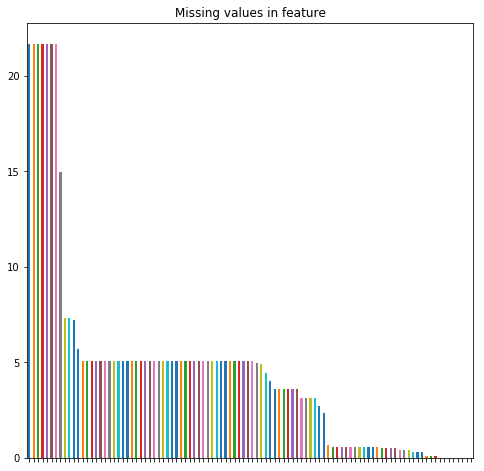

In [202]:
PlotIsNullDist(azRun, axis = 0)

         0
0   437994
7   121236
1    63735
2    22782
4    18422
3    16159
8    13374
47   10736
11    9590
50    9064
16    7617
9     7260
51    5614
48    4554
10    4279
41    3481
13    3361
5     2908
15    2826
6     1954
49    1271
45    1199
52    1186
12     993
14     902
40     776
18     565
23     504
54     391
42     390
17     359
44     319
43     293
19     144
20     131
39      91
46      74
53      56
24      35
30      23
22      23
26      22
21      16
25      15
27      11
29      10
28       2


(         0
 0   437994
 7   121236
 1    63735
 2    22782
 4    18422
 3    16159
 8    13374
 47   10736
 11    9590
 50    9064
 16    7617
 9     7260
 51    5614
 48    4554
 10    4279
 41    3481
 13    3361
 5     2908
 15    2826
 6     1954
 49    1271
 45    1199
 52    1186
 12     993
 14     902
 40     776
 18     565
 23     504
 54     391
 42     390
 17     359
 44     319
 43     293
 19     144
 20     131
 39      91
 46      74
 53      56
 24      35
 30      23
 22      23
 26      22
 21      16
 25      15
 27      11
 29      10
 28       2, <matplotlib.axes._subplots.AxesSubplot at 0x1ea3095a390>)

<Figure size 576x576 with 0 Axes>

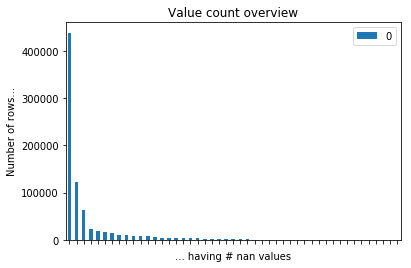

In [203]:
PlotIsNullDist(azRun, axis = 1)

In [ ]:
ser = azRun.isnull().sum(axis = 1)
plt.figure(figsize = (12, 22))
ax = sns.countplot(ser)

ticklabels = [''] * azRun.shape[1]
for ind in range(0, azRun.shape[1], 20):
    ticklabels[ind] = str((ser.index[ind] / azRun.shape[1] * 100))[:4] + '%'

_ = ax.set_xticklabels(ticklabels)

Most of the rows and columns have up to circa 22% of missing values. The outliners will be dropped. I set a large height so that the very small bars around 32% are also visible.

In [21]:
CleanConfig.ColumnsToDropByMisNan = 0.3
CleanConfig.RowsToTropByMisNan = 0.2

In [22]:
for col in azRun.columns:
    nullMean = azRun[col].isnull().mean()
    if nullMean > CleanConfig.ColumnsToDropByMisNan:
        print(col, nullMean)

AGER_TYP 0.7695543529607134
ALTER_HH 0.34813699407890975
ALTER_KIND1 0.9090483729624863
ALTER_KIND2 0.9669004657655059
ALTER_KIND3 0.9930769135826019
ALTER_KIND4 0.9986479223447383
D19_BANKEN_ANZ_12 0.9332522460758892
D19_BANKEN_ANZ_24 0.8910247850981967
D19_BANKEN_DATUM 0.7611254671961276
D19_BANKEN_DIREKT 0.8177668614182116
D19_BANKEN_GROSS 0.8812079158816949
D19_BANKEN_LOKAL 0.9815130029476415
D19_BANKEN_OFFLINE_DATUM 0.9779112027207617
D19_BANKEN_ONLINE_DATUM 0.815714620728192
D19_BANKEN_REST 0.9220608580812166
D19_BEKLEIDUNG_GEH 0.9080845267335487
D19_BEKLEIDUNG_REST 0.7770261248332344
D19_BILDUNG 0.9124066870058044
D19_BIO_OEKO 0.9583189803651395
D19_DIGIT_SERV 0.9623437957588522
D19_DROGERIEARTIKEL 0.8539004354699901
D19_ENERGIE 0.9311461466908881
D19_FREIZEIT 0.8872636528986637
D19_GARTEN 0.9555721869210891
D19_GESAMT_ANZ_12 0.656175067688037
D19_GESAMT_ANZ_24 0.5669783364619999
D19_GESAMT_DATUM 0.39739862503239937
D19_GESAMT_OFFLINE_DATUM 0.626733436487695
D19_GESAMT_ONLINE_DA

I add these features to the list of features that can be dropped.

In [23]:
for col in azRun.columns:
    nullMean = azRun[col].isnull().mean()
    if nullMean > CleanConfig.ColumnsToDropByMisNan:
        CleanConfig.DropColumns.append(col)

In [24]:
CleanConfig.DropColumns

['LNR',
 'CAMEO_DEU_2015',
 'EINGEFUEGT_AM',
 'VERDICHTUNGSRAUM',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_GBZ',
 'PLZ8_HHZ',
 'AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_TECHNIK',
 'D19

In [ ]:
(azRun[dsh.GetMatches(azdias.columns, 'D19*')].isnull().sum() / azRun.shape[0]).sort_values()

Before I start dropping rows, I would like to see how they are distributed regarding certain columns.

In [ ]:
azOut = SelectOutlinerRows(azRun)
azIn = DropOutlinerRows(azRun)

In [ ]:
PlotCompare(
    azIn, azOut, 
    columns=dsh.GetMatches(azRun.columns, ['*finanz*', '*grob*', '*antg*', '*einkommen*']), 
    name1='Keep', name2 = 'Drop')

In [ ]:
tmplst = [x for x in CleanConfig.DropColumns]
tmplst.remove('LNR')
tmplst.remove('EINGEFUEGT_AM')
for x in CleanConfig.NumericalColumns:
    try:
        tmplst.remove(x)
    except:
        pass
    
PlotCompare(
    azIn, azOut,
    columns = tmplst,
    name1='Keep', name2 = 'Drop')

The features Finanz* and Einkommen show up the most significant difference. The attitude to be Anleger or Sparer is very high whereas the attidude of dropped persons is average or even very low. This corresponds to the finding that kept people have a lower income than those who will be dropped.

In [ ]:
del azIn, azOut

gc.collect()

So most of of the columns have less that 20% of missing values. Outliners are those with a minimum of 50% of missing values and will be dropped. But before, I try to (re)engineer/update/create features to slightly reduce features and to extract new information from existing ones. Updating will (hopefully) reduce the number of nan values. 

But before dropping these rows, I look for further rows that can be dropped because of multiple accurrance of information (for example KBA_60KW, 80KW, .. is represented by KBA_0_140KW). 

KBA05_CCM describes the cylinder capacity, so the feature 'KBA05_MOTOR' describing the engine size is unnecessary.

The same for columns having appendix _GROB, _FEIN.

In [ ]:
azRun[dsh.GetMatches(azRun.columns, ['*kba13*kmh*', '*kba13*kw*'], ['*anzahl*', '*1'])]

At first, I intended to keep features KB_CCM_X_Y but then I noticed that those features have gaps/wrong values. For example for row with index = 6 it says: KBA13_KMH_0_140 = 0 but KBA13_KMH_110 = 1 and KBA13_KMH_140 = 2. For other rows the formula is: KBA13_KMH_0_140 = MAX(KBA13_KMH_110, KBA13_KMH_140).

So I decide to keep the single features and drop the summed features because two features keep more information than the max of both :)

In [ ]:
dsh.GetMatches(azdias.columns, '*max*')

As the word "max" says, the max of the relevant features is taken and put in these columns. And using the same argument above: KBA05_MAXHERST describes the most common manufacturer, there are again wrong values. For example row index 3: KBA05_MAXHERST = 5 but KBA05_HERST5 = 3 and KBA05_HERST1 = 4.

KBA05_MAXBJ is described by KBA05_ZUL1-4
KBA05_MAXHERST is described by KBA05_HERST1-5
and so on...

So I decide to drop the max rows because I assume the same errors in the other columns.

In [ ]:
azRun[dsh.GetMatches(azRun.columns, '*herst*', '*krsher*')][:20]

In [ ]:
azRun[dsh.GetMatches(azRun.columns, '*bj*')][:20]

In [ ]:
dsh.GetMatches(azRun.columns, ['kb*ccm_*_*', 'kb*_*2?1'])

In [ ]:
azRun[dsh.GetMatches(azRun.columns, ['KbA13_*alter*'])][:20]

The formula for KBA_HALTERALTER_30 is min(KBA_HALTER_20/25/30), dito for the other features. So I will drop these.

In [ ]:
match = dsh.GetMatches(azRun.columns, ['KB*seg*'])
match

The data set also contains processed data in columns KBA05_MOD = Share of upper - small - vans cars in AZ specific definition. I assume this is based on the features KBA_SEG1..10. When AZ introduces a specific definition, I trust these segmentations and drop the KB_SEG columns (I can still keep the *SEG* columns and drop the *MOD* columns).

In [ ]:
match = dsh.GetMatches(azRun.columns, ['*mod*', '*seg?', '*seg??'])
match

In [ ]:
chk = 'KBA05_SEG6' # just takes two values 0 or 1 (none or some)

plt.figure(figsize = (15, 5))
plt.subplot(1,3,1)
ax = sns.heatmap(azRun[match])
plt.subplot(1,3,2)
ax = PlotValueCounts(azRun, cols=[chk])
_ = ax.set_title(chk + ' value distribution')
plt.subplot(1,3,3)
ax = PlotValueCounts(azRun, cols=['KBA05_MOD1'])
_ = ax.set_title('KBA05_MOD1' + ' value distribution')

In [ ]:
azRun['KBA05_SEG6'].skew(), azRun['KBA05_MOD1'].skew()

My decision was good because the AZ specifid description for high class cars (=MOD1) has a better distribution than the description for high class cars like BMW 7er (=KBA05_SEG6).

In [ ]:
dsh.GetMatches(azRun.columns, '*kmh*')

In [25]:
CleanConfig.DropColumns.extend(dsh.GetMatches(azdias.columns, ['*max*']))

CleanConfig.DropColumns.extend([
    
    'KBA05_MOTOR',                                            # described by KBA05_CCM
    'KBA13_CCM_0_1400', 'KBA13_CCM_1401_2500', 'KBA13_MOTOR', # described by KBA13_CCM
    
    'KBA13_KW_61_120', 'KBA13_KW_0_60', 
    'KBA13_KMH_0_140', 'KBA13_KMH_140_210',  'KBA13_KMH_211'
    
])

CleanConfig.DropColumns.extend(dsh.GetMatches(azRun.columns, '*alterhalter_??')) # described by HALTER_20...

CleanConfig.DropColumns.extend(dsh.GetMatches(azRun.columns, ['*seg?', '*seg??'])) # described by KBA_MOD_1..5

CleanConfig.DropColumns.extend(dsh.GetMatches(azRun.columns, '*_fein')) # described by *_GROB

CleanConfig.DropColumns.append('ALTER_HH') # described by ALTERSKATEGORIE_GROB

In [ ]:
azRun = PrepDropRowsAndColumnsByNAN(azRun)
cusRun = PrepDropRowsAndColumnsByNAN(cusRun)

In [ ]:
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)

azSum = azdias.isnull().sum().sort_values(ascending= False)[:30] / azdias.shape[0] * 100
azRSum = azRun.isnull().sum().sort_values(ascending= False)[:30] / azRun.shape[0] * 100

ax = azSum.plot(kind = 'bar', color = 'b')
_ = ax.set_title('Azdias - before cleaning')
_ = ax.set_ylabel('% nan values')

plt.subplot(1,2,2)
ax = azRSum.plot(kind = 'bar', color = 'b')
_ = ax.set_title('Azdias - after cleaning')
_ = ax.set_ylabel('% nan values')


In [ ]:
azSum = customers.isnull().sum().sort_values(ascending= False)[:50] / azdias.shape[0] * 100
azRSum = cusRun.isnull().sum().sort_values(ascending= False)[:50] / azRun.shape[0] * 100

plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
ax = azSum.plot(kind = 'bar', color = 'b')
_ = ax.set_title('Azdias - before cleaning')
_ = ax.set_ylabel('% nan values')

plt.subplot(1,2,2)
ax = azRSum.plot(kind = 'bar', color = 'b')
_ = ax.set_title('Azdias - after cleaning')
_ = ax.set_ylabel('% nan values')

### Check Logscaling

ANZ_HAUSHALTE_AKTIV 8.779951735060024
ANZ_STATISTISCHE_HAUSHALTE 8.51401781101985
KBA13_ANZAHL_PKW 1.2630938794528626
MIN_GEBAEUDEJAHR 3.5560343615717906


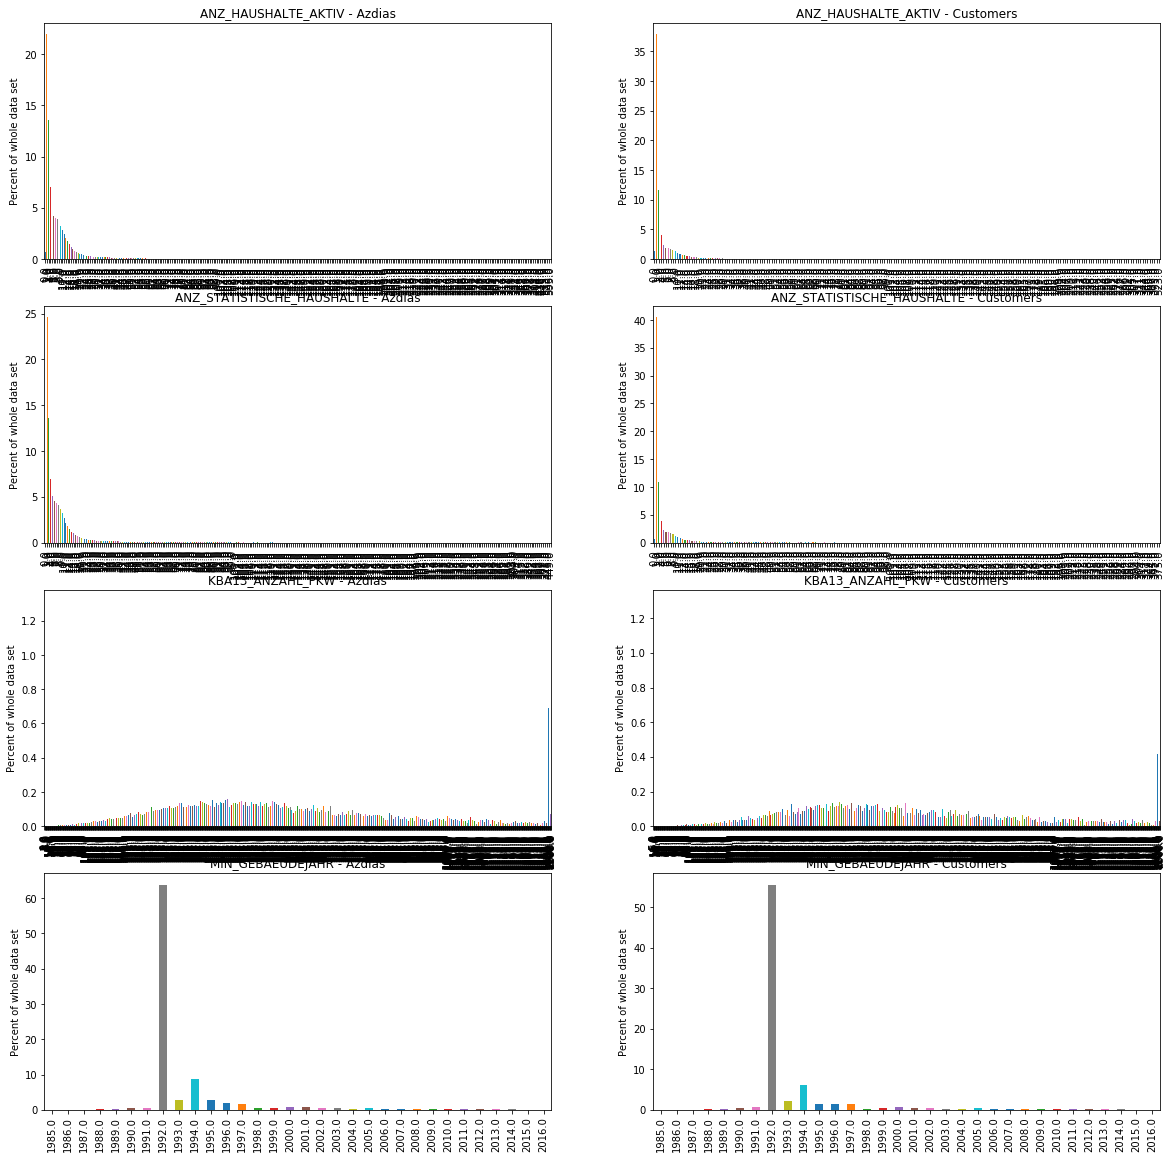

In [26]:
skewed = []
for col in azRun.columns:
    if not col in CleanConfig.NumericalColumns:
        continue
    sk1 = azRun[col].skew() 
    if abs(sk1) > CleanConfig.SkewLimitForLog:
        print(col, sk1)
        skewed.append(col)
        
PlotCompare(azRun, cusRun, skewed)

In [27]:
for col in azRun.columns:
    if not col in CleanConfig.NumericalColumns:
        continue
    if not abs(azRun[col].skew()) >= CleanConfig.SkewLimitForLog:
        continue
    CleanConfig.ColumnsToLogScale.append(col)
CleanConfig.ColumnsToLogScale

['ANZ_HAUSHALTE_AKTIV',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR']

In [28]:
def PrepLogscaleColumns(dfInput):
    df = dfInput.copy(deep = True)
    dsh.PrintLine('Start logscaling')
    for col in CleanConfig.ColumnsToLogScale:
        if not col in df.columns:
            print('Columns not in dataframe: ', col)
            continue
        df[col] = df[col].apply(lambda x: np.log(x + 1))
    dsh.PrintEncapsulate('Finished logscaling: {}'.format(CleanConfig.ColumnsToLogScale))
    return df

In [ ]:
azRun = PrepLogscaleColumns(azRun)
cusRun = PrepLogscaleColumns(cusRun)

### Object columns & feature creation

In [ ]:
azdias[[x for x in azdias.columns 
        if azdias[x].dtype == object 
        and x not in CleanConfig.DropColumns
]].head()

In [ ]:
azRun[[x for x in azRun.columns 
        if azRun[x].dtype == object 
        and x not in CleanConfig.DropColumns
]].head()

In [ ]:
print(CleanConfig.ColumnValues['CAMEO_DEUG_2015'].Meanings)
dsh.PrintLine()
print(CleanConfig.ColumnValues['CAMEO_INTL_2015'].Meanings)
dsh.PrintLine()
print(CleanConfig.ColumnValues['PRAEGENDE_JUGENDJAHRE'].Meanings)

CAMEO_DEUG_2015 has been treated in the previous steps (converted to float).

OST_WEST_KZ and the other categorical features will be one-hot encoded (replace W, E by 1, 0). For that, I create a list to iterate over it.

The feature PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 will be dropped, but before I extract new features giving information about the ages, avantgarge/mainstream and east/west.

From LEBENSPHASE_GROB I also extract the information regarding income and household.

In [29]:
def PrepExtractFeatures(dfInput):
    df = dfInput.copy(deep = True)
    dropcols = []
    
    dsh.PrintLine('Preparing column: CAMEO_INTL_2015')
    print(df['CAMEO_INTL_2015'].value_counts())
    df['CAMEO_INTL_2015_Wealth'] = pd.to_numeric(df['CAMEO_INTL_2015']) // 10
    df['CAMEO_INTL_2015_Ages'] = pd.to_numeric(df['CAMEO_INTL_2015']) % 10
    print(df['CAMEO_INTL_2015_Ages'].value_counts())
    print(df['CAMEO_INTL_2015_Wealth'].value_counts())
    df = df.drop('CAMEO_INTL_2015', axis = 1)
    
    dsh.PrintLine('Preparing column: PRAEGENDE_JUGENDJAHRE')
    print(df['PRAEGENDE_JUGENDJAHRE'].value_counts())
    mainstreamId = []
    avantId = []
    ages = {}
    praegO = []
    praegW = []
    
    
    col = 'PRAEGENDE_JUGENDJAHRE'
    for ind, x in enumerate(CleanConfig.ColumnValues[col].Meanings):
        if ind == 0:
            continue
        if 'Mainstream' in x:
            mainstreamId.append(ind)
        elif 'Avant' in x:
            avantId.append(ind)
        else:
            print('Neither "Mainstream" nor "Avant" in value: ', x)
        
        if dsh.IsMatch(x, ['*O)', '* O+*']):
            praegO.append(ind)
        elif dsh.IsMatch(x, ['*W)', '* W+*']):
            praegW.append(ind)

        ages[ind] = float(x[:2]) / 10.0

    df['PRAEGENDE_JUGENDJAHRE_MainAvant'] = df[col].apply(
        lambda x: 1 if x in mainstreamId
                else 0 if x in avantId
                else x
    )
    
    df['PRAEGENDE_JUGENDJAHRE_Ages'] = df[col].apply(
        lambda x: x if np.isnan(x) else ages[x]
    )
    
    df['PRAEGENDE_JUGENDJAHRE_Ost'] = df[col].apply(
        lambda x: x if np.isnan(x) else 1 if x in praegO else 0
    )
    df['PRAEGENDE_JUGENDJAHRE_West'] = df[col].apply(
    lambda x: x if np.isnan(x) else 1 if x in praegW else 0
    )
    
    print(df['PRAEGENDE_JUGENDJAHRE_Ost'].value_counts())
    print(df['PRAEGENDE_JUGENDJAHRE_West'].value_counts())
    dsh.PrintLine(ages)
    
    print(df['PRAEGENDE_JUGENDJAHRE_MainAvant'].value_counts())
    print(df['PRAEGENDE_JUGENDJAHRE_Ages'].value_counts())
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1)
    
# single low-income- and average earners of younger age   1
# single low-income- and average earners of higher age    1
# single high-income earners                              1
# single low-income- and average earner-couples           2
# single high-income earner-couples                       2
# single parents                                          2
# single low-income- and average earner-families          2
# high-income earner-families                             2
# average earners of younger age from mulitperson households 
# low-income- and average earners of higher age from mulitperson households
# high-income earners of younger age from multiperson households
# high-income earners of higher age from multiperson households  

    # LP_LEBENSPHASE_GROB
    
    sv = CleanConfig.ColumnValues['LP_LEBENSPHASE_GROB'].SingleValues
    df['LP_LEBENSPHASE_GROB_Income'] = df['LP_LEBENSPHASE_GROB'].apply(lambda x:
                                                                      np.NaN if x not in sv.keys()
                                                                      else 2 if dsh.IsMatch(sv[x], '*low*income*average*')
                                                                      else 1 if dsh.IsMatch(sv[x], '*low*income*')
                                                                      else 3 if dsh.IsMatch(sv[x], '*high*income*')
                                                                      else np.NaN
                                                                      )

    df['LP_LEBENSPHASE_GROB_HouseHold'] = df['LP_LEBENSPHASE_GROB'].apply(lambda x:
                                                                      np.NaN if x not in sv.keys()
                                                                      else 3 if dsh.IsMatch(sv[x], '*multiperson*')  
                                                                      else 2 if dsh.IsMatch(sv[x], '*single*earners*')
                                                                      else 1
                                                                   )
    df = df.drop('LP_LEBENSPHASE_GROB', axis = 1)
    
    
    if 'CAMEO_DEU_2015' in df.columns and not 'CAMEO_DEU_2015' in CleanConfig.DropColumns:
        print('Pay attention: CAMEO_DEU_2015 one-hot encoding')
        df = dsh.ApplyOneHotEncoding(df, columns=['CAMEO_DEU_2015'])    
    
    dsh.PrintLine(n=10)
    print('New columns: ', set(df.columns) - set(dfInput.columns))
    dsh.PrintLine(n=10)
    print('Dropped columns: ', set(dfInput.columns) - set(df.columns))
    dsh.PrintLine('Finished object column preparation')
    
    return df

In [ ]:
azRun = PrepExtractFeatures(azRun)
cusRun = PrepExtractFeatures(cusRun)

### Reorder and shift values
There are some columns whose values to not correspond for what they actually stand for (for example (0 - verly likely/high income/great neighbourhodd, 10 very unlikely/lowest income/poor neighbourhood). I intend to run PCA on the data and to facilitate the interpretation, I change the order of these values.

Other columns need to be shifted: 

In [30]:
CleanConfig.ColumnsReorderValues = []
for cv in CleanConfig.ColumnValues.values():
    if cv.ColumnName in CleanConfig.DropColumns or not cv.ColumnName in azRun.columns:
        continue
    if cv.LowestValue > 2:
        if cv.ColumnName in ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']:
            continue
        print(cv.ColumnName, cv.LowestValue)
        CleanConfig.ColumnsReorderValues.append(cv.ColumnName)

CAMEO_DEUG_2015 9
CAMEO_INTL_2015 55
FINANZ_ANLEGER 5
FINANZ_HAUSBAUER 5
FINANZ_MINIMALIST 5
FINANZ_SPARER 5
FINANZ_UNAUFFAELLIGER 5
FINANZ_VORSORGER 5
GEBAEUDETYP_RASTER 4
HH_EINKOMMEN_SCORE 6
KBA05_HERSTTEMP 4
KBA05_MODTEMP 4
KKK 4
MOBI_REGIO 6
REGIOTYP 7
RETOURTYP_BK_S 5
SEMIO_DOM 7
SEMIO_ERL 7
SEMIO_FAM 7
SEMIO_KAEM 7
SEMIO_KRIT 7
SEMIO_KULT 7
SEMIO_LUST 7
SEMIO_MAT 7
SEMIO_PFLICHT 7
SEMIO_RAT 7
SEMIO_REL 7
SEMIO_SOZ 7
SEMIO_TRADV 7
SEMIO_VERT 7
SHOPPER_TYP 3
WOHNLAGE 5


FINANZTYPs highest scalar value standing for 'unremarkable' is not on top of 'investor'. So I rearange the values: 

- 0 = unremarkable,
- 1 = low fincancial interest, ...
- 6 = investor

I also shift the values in the column describing the nationality. Currently its 1=sounding german, 2 = sounding foreign, 3 = assimilated.

In [31]:
def ReorderSeries(ser):
    vmin = ser.min()
    vmax = ser.max()
    
    if 'D19' in ser.name and 'no transaction known' in CleanConfig.ColumnValues[ser.name].Meanings[0]:
        vmin = vmin + 1
    
    dsh.PrintLine()
    print('current column: ', ser.name)

    repDic = {}
    for ind in range (int(vmin), int(vmax) + 1):
        repDic[ind] = float(vmax + 1 - ind)
    return repDic
            
def ReorderValues(dfInput):
    dsh.PrintLine('Start reordering values')
    df = dfInput.copy(deep = True)
    
    for col in CleanConfig.ColumnsReorderValues:
        if not col in df.columns:
            print('Skipping column because it is not contained: ', col)
            continue
        
        repDic = ReorderSeries(df[col])
        
        dsh.PrintLine('Applying reorder on {}: {}'.format(col, repDic))
        
        meanings = CleanConfig.ColumnValues[col].Meanings
        if len(meanings) > 2:
            print('Having meanings: ', meanings[:1], ' - ', meanings[:-1])
        try:
            df[col] = df[col].apply(lambda x: repDic[x] if x in repDic.keys() else x)
        except:
            print('Error reordering values in column "{}": '.format(col), repDic, df[col].unique())
            return
    
    dsh.PrintLine('Finished reordering values')
    return df


def ShiftRight(ser, mod):
    return ser.apply(
        lambda x: 
        x if x == 0 or np.isnan(x) # don't change the meaning of unknown!
        else ((x % mod) + 1)
    )

def ShiftLeft(ser, mod):
    return ser.apply(
        lambda x: 
        x if x == 0 or np.isnan(x) # don't change the meaning of unknown!
        else (x - 2) % mod + 1
        # 1 => 3
        # 3 => 2
        # 2 => 1
    )

def ShiftValues(dfInput):
    dsh.PrintLine('Start shifting vaues')
    df = dfInput.copy(deep = True)
    
    df['FINANZTYP'] = ShiftRight(df['FINANZTYP'], 6)
    df['NATIONALITAET_KZ'] = ShiftLeft(df['NATIONALITAET_KZ'], 3)
    
    dsh.PrintLine('Finshed shifting vaues')
    return df

def PrepReorderShiftValues(dfInput):
    df = dfInput.copy(deep = True)
    df = ReorderValues(df)
    df = ShiftValues(df)
    return df

In [ ]:
PrepReorderShiftValues(azRun)

In [ ]:
azRun = PrepReorderShiftValues(azRun)
cusRun = PrepReorderShiftValues(cusRun)


In [ ]:
pd.concat([
    azdias[azdias.index < 5][[x for x in CleanConfig.ColumnsReorderValues if x in azRun.columns]],
    azRun[azRun.index < 5][[x for x in CleanConfig.ColumnsReorderValues if x in azRun.columns]]
])

### Final Step - One-hot Encode

Most of the features are ordinal and mostly having the meaning 1-low....5/7/10 high. In real life, a low share of VW is not equal to a low share of VW. But here, I will treat them as interval data to avoid one-hot encoding for all those columns. Numerical values and interval values are kept as they are.

In [ ]:
list(azRun.columns)

In [36]:
def PrepOneHotEncode(dfInp):
    df = dfInp.copy(deep = True)
    dsh.PrintLine('Starting one-hot encodng')
    # I intend to facilitate GEBAEUDETYP_RASTER to 0 = residual, 1 = business
    # and to extract one-hot encoded features from GEBAEUDETYP.
    
    meanings = CleanConfig.ColumnValues['GEBAEUDETYP'].Meanings
    
    # Pay attention. The values of this column has been reordered. So 1 = residual, > 1 business
#     df['GEBAEUDETYP_RASTER'] = df['GEBAEUDETYP_RASTER'].apply(lambda x:
#                                                              np.nan if np.isnan(x)
#                                                              else 1 if x == 1
#                                                              else 2 if (x > 1 and x < 5)
#                                                              else 3)
    
#     df['GEBAEUDETYP_Residental'] = df['GEBAEUDETYP'].apply(lambda x: x if np.isnan(x)
#                                           else dsh.IsMatch(meanings[int(x)], ['residental*', 'mixed*'])) # avoid false match for 3
#     df['GEBAEUDETYP_Mixed'] = df['GEBAEUDETYP'].apply(lambda x: x if np.isnan(x)
#                                           else dsh.IsMatch(meanings[int(x)], ['*mixed*']))
#     df['GEBAEUDETYP_Company'] = df['GEBAEUDETYP'].apply(lambda x: x if np.isnan(x)
#                                           else dsh.IsMatch(meanings[int(x)], ['*company b*', 'mixed'])) 
#     df['GEBAEUDETYP_WithHousehold'] = df['GEBAEUDETYP'].apply(lambda x: x if np.isnan(x)
#                                           else dsh.IsMatch(meanings[int(x)], ['*with *household*', 'mixed']))
#     df['GEBAEUDETYP_WitCompany'] = df['GEBAEUDETYP'].apply(lambda x: x if np.isnan(x)
#                                           else dsh.IsMatch(meanings[int(x)], ['*with *company*', 'mixed']))
#     df = df.drop('GEBAEUDETYP', axis = 1)
    
    # I decided to reduce one-hot encoding for LP_FAMILIE_GROB:
    df['LP_FAMILIE_GROB'] = df['LP_FAMILIE_GROB'].apply(lambda x:
                                                       3 if x in [3, 4, 5]
                                                       else 4 if x in [6,7,8]
                                                        else 5 if x in [9, 10, 11]
                                                        else x
                                                       )
    
    
    
    ohFeatures = [
        
        'AGER_TYP',
        'ANREDE_KZ',
        'ALTERSKATEGORIE_GROB',
        
        'CAMEO_DEUG_2015',
        'CAMEO_INTL_2015_Ages',
        'CAMEO_INTL_2015_Wealth',
        
        'CJT_GESAMTTYP',
        
        'D19_LETZTER_KAUF_BRANCHE',
        
        'FINANZTYP',
        
        'GEBAEUDETYP',
        'GEBAEUDETYP_RASTER',
        'GEMEINDETYP',
        'GFK_URLAUBERTYP',
        
        'HEALTH_TYP',

        'KBA05_MAXBJ',
        'KBA05_HERSTTEMP',
        'KBA05_MAXHERST',
        'KBA05_MODTEMP',

        'LP_LEBENSPHASE_GROB_Income',
        'LP_LEBENSPHASE_GROB_HouseHold',
        
        'LP_FAMILIE_FEIN',
        'LP_FAMILIE_GROB',
        'LP_LEBENSPHASE_FEIN',
        'LP_LEBENSPHASE_GROB',
        'LP_STATUS_FEIN',
        'LP_STATUS_GROB',

        
        'NATIONALITAET_KZ',
        
        'OST_WEST_KZ',
        'RETOURTYP_BK_S',
        
        'SHOPPER_TYP',
        'STRUKTURTYP#',
        
        'VERS_TYP',
        'ZABEOTYP',
    ]

    errorcnt = 0
    
    for col in ohFeatures:
        
        if not col in df.columns:
            dsh.PrintEncapsulate('Feature does not exist anymore: {}'.format(col))
            continue
        
        uq = df[col].unique()
        uq = [x for x in uq if not dsh.IsNull(x)]
        
        if len(uq) == 1:
            dsh.PrintEncapsulate(col, 'with only one value: {}'.format(uq))
            errorcnt = errorcnt + 1
            continue
        
        if len(uq) == 2:
            df[col] = dsh.ApplyBinaryEncoding(df[col])
            continue
        
        df, _ = dsh.ApplyOneHotEncoding(df, columns = [col])
        
    
    
#     dsh.PrintLine('Preparing column: OST_WEST_KZ')
#     df['OST_WEST_KZ'] = dsh.ApplyBinaryEncoding(df['OST_WEST_KZ'])
    
    if errorcnt > 0:
        dsh.PrintLine('One-Hot encoding NOT successfully finished')
    else:
        dsh.PrintLine('One-Hot encoding successfully finished')
    return df

In [ ]:
azRun = PrepOneHotEncode(azRun)

### Clean original data with clean function

In [37]:
def PrepareForSegmentation(dfinput, testData = False):
    df = dfinput.copy(deep = True)
    
    df = PrepMissingValuesToNan(df)
    df = PrepUpdateValues(df)
    df = PrepDropRowsAndColumnsByNAN(df, testData)
    df = PrepLogscaleColumns(df)
    df = PrepExtractFeatures(df)
    df = PrepReorderShiftValues(df)
    df = PrepOneHotEncode(df)
    
    return df

In [38]:
azRun = PrepareForSegmentation(azdias)

-------------------- Start converting missing values to nan --------------------
CAMEO_DEUG_2015 - [-1, '-1', '-1.0', None, 'X'] - 99352 - 0
Converted to float:  CAMEO_DEUG_2015
CAMEO_INTL_2015 - [-1, '-1', '-1.0', None, 'XX'] - 99352 - 0
Converted to float:  CAMEO_INTL_2015
HEALTH_TYP - [-1, '-1', '-1.0', 0, '0', '0.0', -1, -1.0] - 111196 - 0
KBA05_ALTER1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_ALTER2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_ALTER3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_ALTER4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_ANHANG - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 13877 - 0
KBA05_AUTOQUOT - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14791 - 0
KBA05_CCM1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_CCM2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_CCM3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_CCM4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 14786 - 0
KBA05_DIES

-------------------- Convert undocumented values to nan --------------------
-------------------- Finished --------------------
-------------------- Start finding and removing columns matchting to wildcards: ['LNR', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM', 'VERDICHTUNGSRAUM', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19

-------------------- - --------------------
current column:  KKK
-------------------- Applying reorder on KKK: {1: 4.0, 2: 3.0, 3: 2.0, 4: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'very high', 'high', 'average']
-------------------- - --------------------
current column:  MOBI_REGIO
-------------------- Applying reorder on MOBI_REGIO: {1: 6.0, 2: 5.0, 3: 4.0, 4: 3.0, 5: 2.0, 6: 1.0} --------------------
Having meanings:  ['very high mobility']  -  ['very high mobility', 'high mobility', 'middle mobility', 'low mobility', 'very low mobility ']
-------------------- - --------------------
current column:  REGIOTYP
-------------------- Applying reorder on REGIOTYP: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'upper class', 'conservatives', 'upper middle class', 'middle class', 'lower middle class', 'traditional workers']
-------------------- - --------------------
current column: 

-------------------- Start applying one-hot encoding on: ['CAMEO_DEUG_2015'] --------------------
Columns before one hot encoding:  265
Columns to be removed and replaced:  ['CAMEO_DEUG_2015']
Size after encoding:  273
Columns successfully one hot encoded :)  New columns are:  ['CAMEO_DEUG_2015_1.0', 'CAMEO_DEUG_2015_2.0', 'CAMEO_DEUG_2015_3.0', 'CAMEO_DEUG_2015_4.0', 'CAMEO_DEUG_2015_5.0', 'CAMEO_DEUG_2015_6.0', 'CAMEO_DEUG_2015_7.0', 'CAMEO_DEUG_2015_8.0', 'CAMEO_DEUG_2015_9.0']
Removed columns after one hot encoding:  ['CAMEO_DEUG_2015']
-------------------- Finished applying one-hot encoding --------------------
-------------------- Start applying one-hot encoding on: ['CAMEO_INTL_2015_Ages'] --------------------
Columns before one hot encoding:  273
Columns to be removed and replaced:  ['CAMEO_INTL_2015_Ages']
Size after encoding:  277
Columns successfully one hot encoded :)  New columns are:  ['CAMEO_INTL_2015_Ages_1.0', 'CAMEO_INTL_2015_Ages_2.0', 'CAMEO_INTL_2015_Ages_3.0', 'CA

-------------------- Start applying one-hot encoding on: ['KBA05_MODTEMP'] --------------------
Columns before one hot encoding:  358
Columns to be removed and replaced:  ['KBA05_MODTEMP']
Size after encoding:  362
Columns successfully one hot encoded :)  New columns are:  ['KBA05_MODTEMP_1.0', 'KBA05_MODTEMP_2.0', 'KBA05_MODTEMP_3.0', 'KBA05_MODTEMP_4.0', 'KBA05_MODTEMP_5.0']
Removed columns after one hot encoding:  ['KBA05_MODTEMP']
-------------------- Finished applying one-hot encoding --------------------
--------------------  --------------------
Feature does not exist anymore: LP_FAMILIE_FEIN
-------------------- - --------------------
-------------------- Start applying one-hot encoding on: ['LP_FAMILIE_GROB'] --------------------
Columns before one hot encoding:  362
Columns to be removed and replaced:  ['LP_FAMILIE_GROB']
Size after encoding:  364
Columns successfully one hot encoded :)  New columns are:  ['LP_FAMILIE_GROB_1.0', 'LP_FAMILIE_GROB_2.0', 'LP_FAMILIE_GROB_3.0']
R

## Preparing for model - Feature transformation

I use an imputer to replace NaN values by the mean because there are too many rows having at least one nan value and dropping those rows means loosing information. 

To use PCA, we need to impute missing values and scale all the given values to be a number between 0 and 1 so that differences in scaling do not effect the principal components.

In [39]:
CleanConfig.Imputer = preprocessing.Imputer(missing_values = 'NaN', strategy = 'median')
CleanConfig.Scaler = preprocessing.StandardScaler()

CleanConfig.ImputerBinary = preprocessing.Imputer(missing_values = 'NaN', strategy = 'most_frequent')

In [40]:
def GetBinaryColumns(df):
    binaryCols = []
    for col in df.columns:
        uq = [x for x in df[col].unique() if not dsh.IsNull(x)]
        if len(uq) <= 2:
            binaryCols.append(col)
    return binaryCols

GetBinaryColumns(azRun)

['DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KONSUMZELLE',
 'OST_WEST_KZ',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'VERS_TYP',
 'ANREDE_KZ',
 'PRAEGENDE_JUGENDJAHRE_MainAvant',
 'PRAEGENDE_JUGENDJAHRE_Ost',
 'PRAEGENDE_JUGENDJAHRE_West',
 'LP_LEBENSPHASE_GROB_Income',
 'ALTERSKATEGORIE_GROB_1',
 'ALTERSKATEGORIE_GROB_2',
 'ALTERSKATEGORIE_GROB_3',
 'ALTERSKATEGORIE_GROB_4',
 'ALTERSKATEGORIE_GROB_9',
 'CAMEO_DEUG_2015_1.0',
 'CAMEO_DEUG_2015_2.0',
 'CAMEO_DEUG_2015_3.0',
 'CAMEO_DEUG_2015_4.0',
 'CAMEO_DEUG_2015_5.0',
 'CAMEO_DEUG_2015_6.0',
 'CAMEO_DEUG_2015_7.0',
 'CAMEO_DEUG_2015_8.0',
 'CAMEO_DEUG_2015_9.0',
 'CAMEO_INTL_2015_Ages_1.0',
 'CAMEO_INTL_2015_Ages_2.0',
 'CAMEO_INTL_2015_Ages_3.0',
 'CAMEO_INTL_2015_Ages_4.0',
 'CAMEO_INTL_2015_Ages_5.0',
 'CAMEO_INTL_2015_Wealth_1.0',
 'CAMEO_INTL_2015_Wealth_2.0',
 'CAMEO_INTL_2015_Wealth_3.0',
 'CAMEO_INTL_2015_Wealth_4.0',
 'CAMEO_INTL_2015_Wealth_5.0',
 'CJT_GESAMTTYP_1.0',
 'CJT_GESAMTTYP_2.0',
 'CJT_GESAMTTYP_3.0',
 'CJT_GESAM

In [41]:
def Impute(dfInput, fit = True):
    df = dfInput.copy(deep = True)
    
    binCols = GetBinaryColumns(df)
    noBinCols = [x for x in df.columns if not x in binCols]
    
    tfBin = None
    if fit:
        tfBin = CleanConfig.ImputerBinary.fit_transform(df[binCols])
    else:
        tfBin = CleanConfig.ImputerBinary.transform(df[binCols])
    
    tf = None
    if fit:
        tf = CleanConfig.Imputer.fit_transform(df[noBinCols])
    else:
        tf = CleanConfig.Imputer.transform(df[noBinCols])
    
    df = pd.DataFrame(tf, columns = noBinCols)
    dfBin = pd.DataFrame(tfBin, columns = binCols)
    
    return df.merge(dfBin, how = 'inner', left_index = True, right_index = True)

def Scale(dfInput, fit = True):
    df = dfInput.copy(deep = True)
    
    sc = None
    if fit:
        sc = CleanConfig.Scaler.fit_transform(df.values)
    else:
        sc = CleanConfig.Scaler.transform(df.values)
    
    df = pd.DataFrame(sc, columns = list(df.columns))
    
    return df    

In [42]:
azClust = Impute(azRun, True)
azClust = Scale(azClust, True)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Dimensionality reduction - PCA

It first, I do PCA with all components and have a look at the explained variance. Then, I decide how much % of the data set I intend to describe and search the required amount of components.

In [43]:
nbrCompAll = azClust.shape[1]
nbrReducedComp = 0 # will be set later


In [44]:
pcaAll = PCA(n_components = nbrCompAll)
azPcaAll = pcaAll.fit_transform(azClust.values)

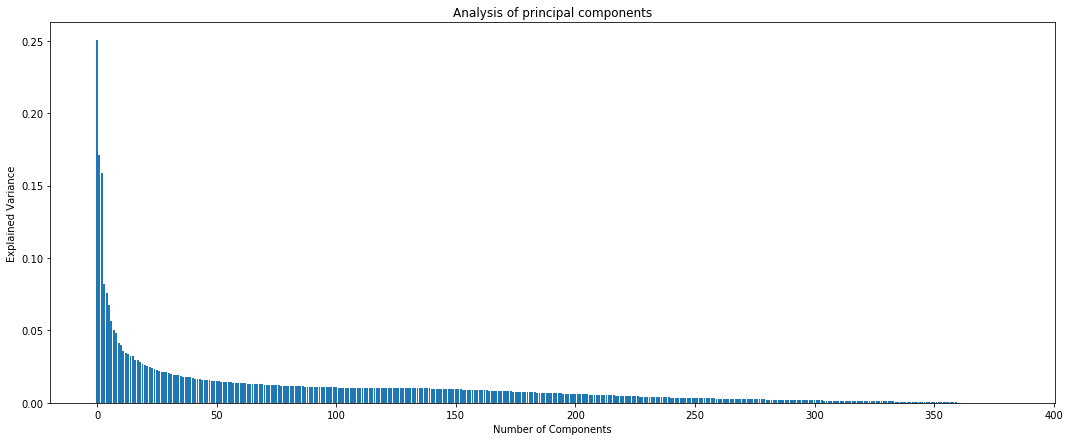

In [45]:
plt.figure(figsize = (18, 7))
dsh.PCAPlotExplainedVariances(pca = pcaAll)

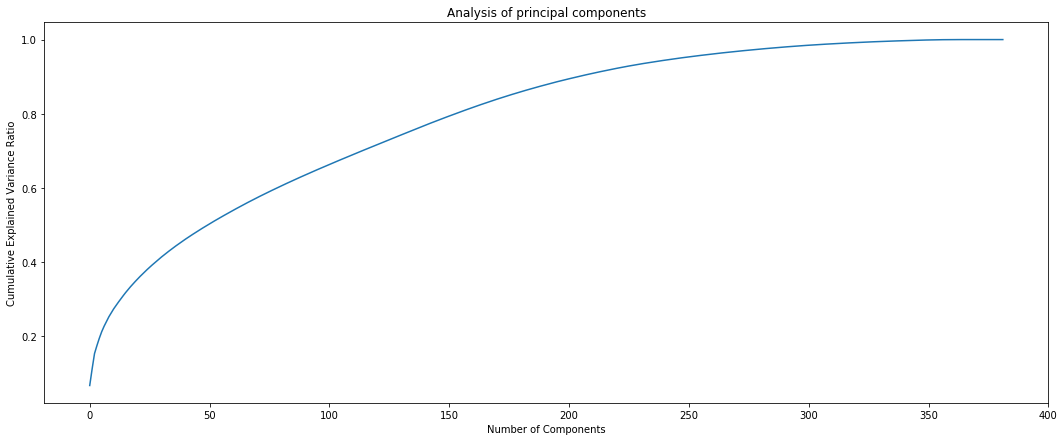

In [46]:
plt.figure(figsize = (18, 7))
dsh.PCAPlotCumulatedVarianceRatios(pcaAll)

I intend to describe 95% of the dataset and search the required number of components.

The PCA object has an implemented score function and provides probalistic interpretation for each component. These values are stored in the attribute "explained_variance_ratio_" and represent the amount of variance each component explains regarding to the original data set. 
To determine the required amount of principal components, I will set a minimum limit (minimum % of original data that I intend to explain with the components), iterate over all explained_variance_ratio_ values and stop until the sum is bigger or equal than my limit. With that number, PCA will be fitted again to the data.

In [47]:
pcaLimitDesc = 0.95

for ind in range(200, len(pcaAll.explained_variance_ratio_)):
    if np.sum(pcaAll.explained_variance_ratio_[:ind]) >= pcaLimitDesc:
        nbrReducedComp = ind + 1 # 0-index based but we want the correct number for components
        dsh.PrintEncapsulate('Reduced components {} describe {} of the data.'.format(nbrReducedComp, pcaLimitDesc))
        break

--------------------  --------------------
Reduced components 249 describe 0.95 of the data.
-------------------- - --------------------


In [48]:
pcaReduced = PCA(n_components = nbrReducedComp)
azPcaReduced = pcaReduced.fit_transform(azClust.values)

In [49]:
def AnalysePCAComponent(comps, pcaind, usedComponents, scaledTfImpOneHotDf, plot = True):
    comp = comps[pcaind]
    usedcolumns = list(scaledTfImpOneHotDf)
    unsortedList = []
    for ind in range(len(comp)):
        unsortedList.append([usedcolumns[ind], comp[ind]])

    sortedList = sorted(unsortedList, key = lambda x: x[1], reverse = True)

    txt = '-' * 10 + ' Component ' + str(pcaind) + ' ' + '-' * 10
    print(txt)
    
    tmpDir = {}
    half = len(sortedList)
    for ind in range(0, usedComponents):
        nind = len(sortedList) - ind - 1
        print('Positive: ', sortedList[ind][0], sortedList[ind][1], ' - Negative: ', sortedList[nind][0], sortedList[nind][1])
        if ind < half:
            tmpDir[sortedList[ind][0]] = sortedList[ind][1]
            tmpDir[sortedList[nind][0]] = sortedList[nind][1]
    return sortedList

In [50]:
_ = AnalysePCAComponent(pcaReduced.components_, 0, 100, azClust, False)

---------- Component 0 ----------
Positive:  MOBI_REGIO 0.1567494450849381  - Negative:  KBA13_ANTG1 -0.14447396926475617
Positive:  ANZ_HAUSHALTE_AKTIV 0.15221408396419545  - Negative:  KBA05_ANTG1 -0.14321282381887418
Positive:  ANZ_STATISTISCHE_HAUSHALTE 0.1497215827105611  - Negative:  HH_EINKOMMEN_SCORE -0.14298632354794452
Positive:  LP_STATUS_GROB_1.0 0.14592531828646257  - Negative:  MOBI_RASTER -0.14252874376666
Positive:  KBA13_ANTG3 0.14394466101018413  - Negative:  KBA05_GBZ -0.13767892798086695
Positive:  FINANZ_MINIMALIST 0.14207891920624652  - Negative:  KBA05_AUTOQUOT -0.13618263125679503
Positive:  KBA13_ANTG4 0.14127919424765448  - Negative:  KBA13_AUTOQUOTE -0.1333710573237536
Positive:  EWDICHTE 0.12265043298520514  - Negative:  LP_LEBENSPHASE_GROB_Income -0.13270776616574548
Positive:  ORTSGR_KLS9 0.12237713913450429  - Negative:  FINANZ_HAUSBAUER -0.11092638341176511
Positive:  CAMEO_INTL_2015_Wealth_5.0 0.11852485687371393  - Negative:  KBA13_GBZ -0.1085522643612

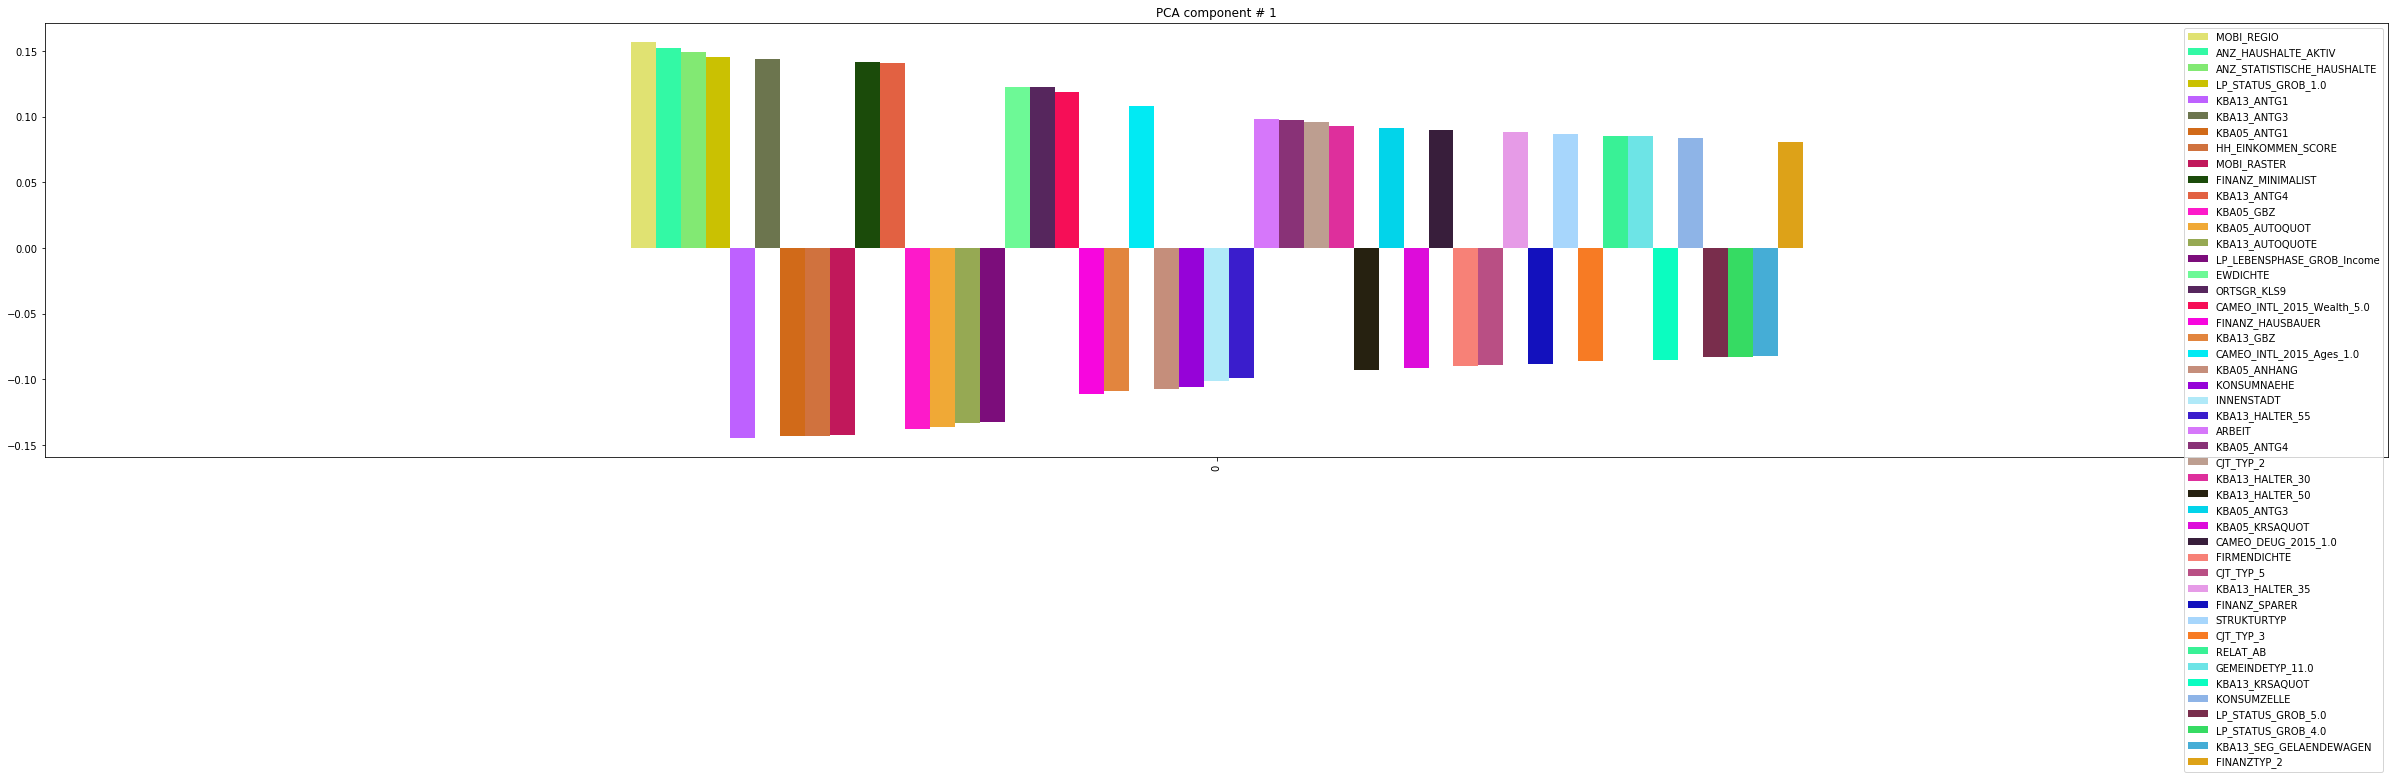

In [51]:
dsh.AnalyzePCAResult(pcaReduced, 0, azClust)

In [52]:
_ = AnalysePCAComponent(pcaReduced.components_, 1, 100, azClust, False)

---------- Component 1 ----------
Positive:  KOMBIALTER 0.1997661539254379  - Negative:  PRAEGENDE_JUGENDJAHRE_Ages -0.2035343554102923
Positive:  FINANZ_SPARER 0.1850480158095759  - Negative:  CJT_TYP_1 -0.18973348650746408
Positive:  FINANZ_UNAUFFAELLIGER 0.1768356522089201  - Negative:  CJT_TYP_2 -0.18245752921755487
Positive:  CJT_TYP_4 0.16821668313623353  - Negative:  FINANZ_VORSORGER -0.17799363078124147
Positive:  CJT_TYP_5 0.16549912589723798  - Negative:  ONLINE_AFFINITAET -0.1381687125629316
Positive:  FINANZ_ANLEGER 0.16508571032541278  - Negative:  RT_KEIN_ANREIZ -0.13574900024170486
Positive:  SEMIO_PFLICHT 0.1616436964615941  - Negative:  RT_UEBERGROESSE -0.13375028699067268
Positive:  SEMIO_TRADV 0.16132892181690395  - Negative:  SEMIO_LUST -0.13081400721631886
Positive:  CJT_TYP_3 0.15881227414033108  - Negative:  SEMIO_ERL -0.11696088780714152
Positive:  CJT_TYP_6 0.15808677404398797  - Negative:  FINANZTYP_2 -0.11025438577271333
Positive:  ALTERSKATEGORIE_GROB_4 0.15

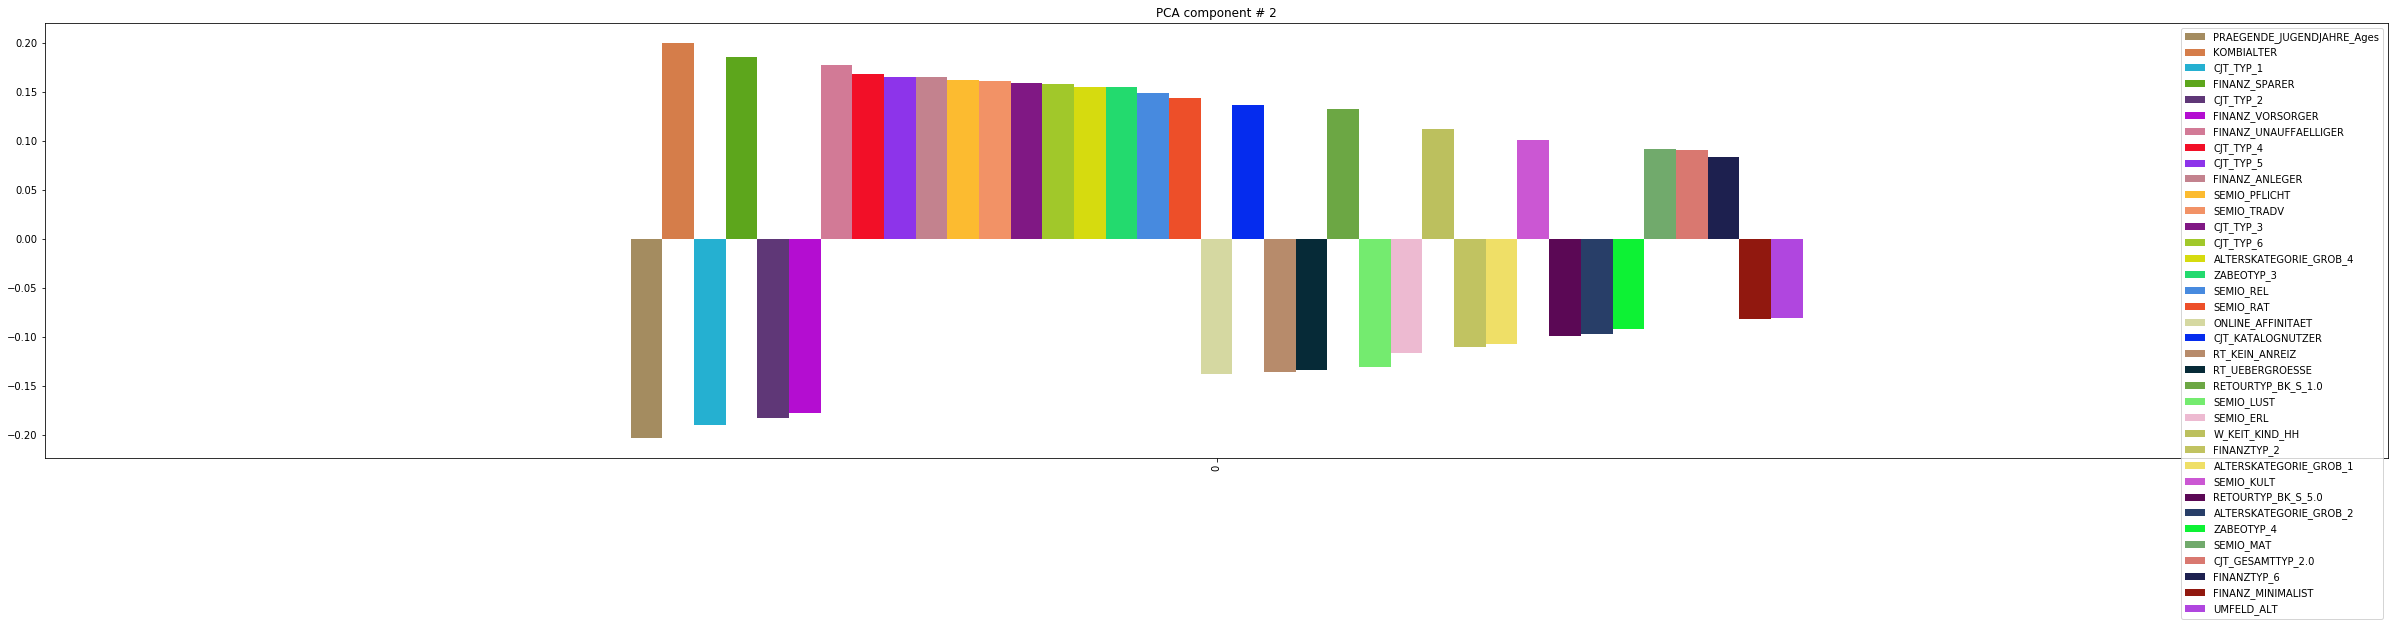

In [53]:
dsh.AnalyzePCAResult(pcaReduced, 1, azClust)

In [54]:
_ = AnalysePCAComponent(pcaReduced.components_, 2, 100, azClust, False)

---------- Component 2 ----------
Positive:  KBA13_HERST_BMW_BENZ 0.19951872868163553  - Negative:  KBA13_SITZE_5 -0.1685523333131025
Positive:  KBA13_MERCEDES 0.17170548041240047  - Negative:  KBA13_SEG_KLEINWAGEN -0.13905043910784226
Positive:  KBA13_SEG_OBEREMITTELKLASSE 0.16963057438014373  - Negative:  KBA13_HALTER_25 -0.1342288338319786
Positive:  KBA13_BMW 0.16510383231857628  - Negative:  KBA13_SEG_KOMPAKTKLASSE -0.12514717310864187
Positive:  KBA13_SITZE_4 0.1645198996640357  - Negative:  KBA13_HALTER_20 -0.12339931611288557
Positive:  KBA13_SEG_SPORTWAGEN 0.15530534020579956  - Negative:  KBA13_KMH_180 -0.1216305707276388
Positive:  KBA05_HERST1 0.13271676225307166  - Negative:  KBA13_HERST_ASIEN -0.11522437514846823
Positive:  KBA13_SEG_OBERKLASSE 0.13103365495501512  - Negative:  KBA13_HERST_FORD_OPEL -0.11366578377014527
Positive:  KBA13_KW_121 0.1283896761980604  - Negative:  KBA13_FAB_ASIEN -0.10976735022401764
Positive:  KBA13_KMH_250 0.1258823550201646  - Negative:  KB

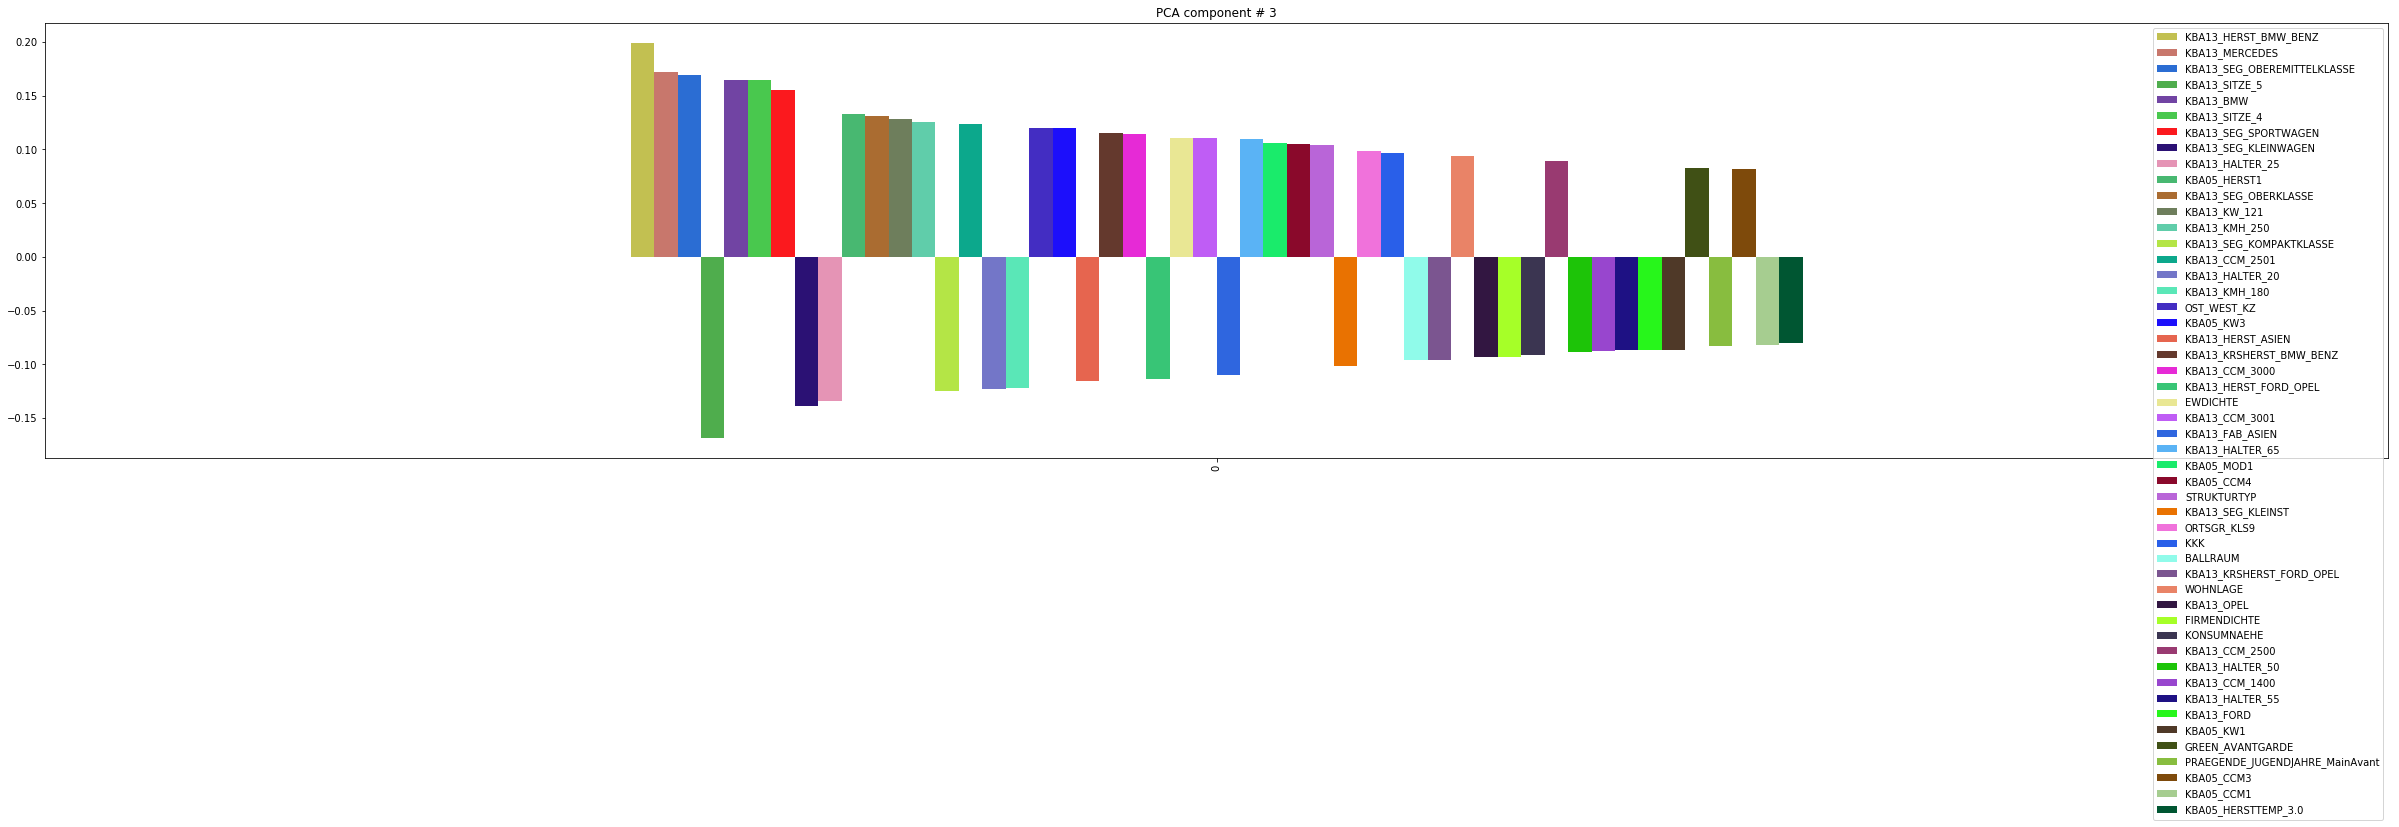

In [55]:
dsh.AnalyzePCAResult(pcaReduced, 2, azClust)

In [56]:
_ = AnalysePCAComponent(pcaReduced.components_, 3, 100, azClust, False)

---------- Component 3 ----------
Positive:  ONLINE_AFFINITAET 0.15629311992681086  - Negative:  VK_DISTANZ -0.18778938748019455
Positive:  D19_GESAMT_ONLINE_QUOTE_12 0.14069418550110657  - Negative:  VK_DHT4A -0.1764685801417663
Positive:  D19_VERSAND_ONLINE_QUOTE_12 0.13575967547830728  - Negative:  VK_ZG11 -0.17171914150078404
Positive:  ARBEIT 0.13510693168703933  - Negative:  OST_WEST_KZ -0.1485089100737961
Positive:  GREEN_AVANTGARDE 0.124546156958046  - Negative:  KBA13_SITZE_6 -0.1476283449357902
Positive:  KBA05_VORB0 0.11723086173212638  - Negative:  PRAEGENDE_JUGENDJAHRE_MainAvant -0.124546156958046
Positive:  KBA13_FAB_SONSTIGE 0.1147518959027146  - Negative:  LP_FAMILIE_GROB_1.0 -0.12115957714799978
Positive:  KBA13_HERST_SONST 0.1147518959027146  - Negative:  D19_KONSUMTYP -0.12077199773700444
Positive:  ANZ_PERSONEN 0.11449621000206633  - Negative:  KBA13_BJ_2000 -0.1129948541713516
Positive:  KBA13_VORB_0 0.11341295805468433  - Negative:  KBA13_SEG_GROSSRAUMVANS -0.1063

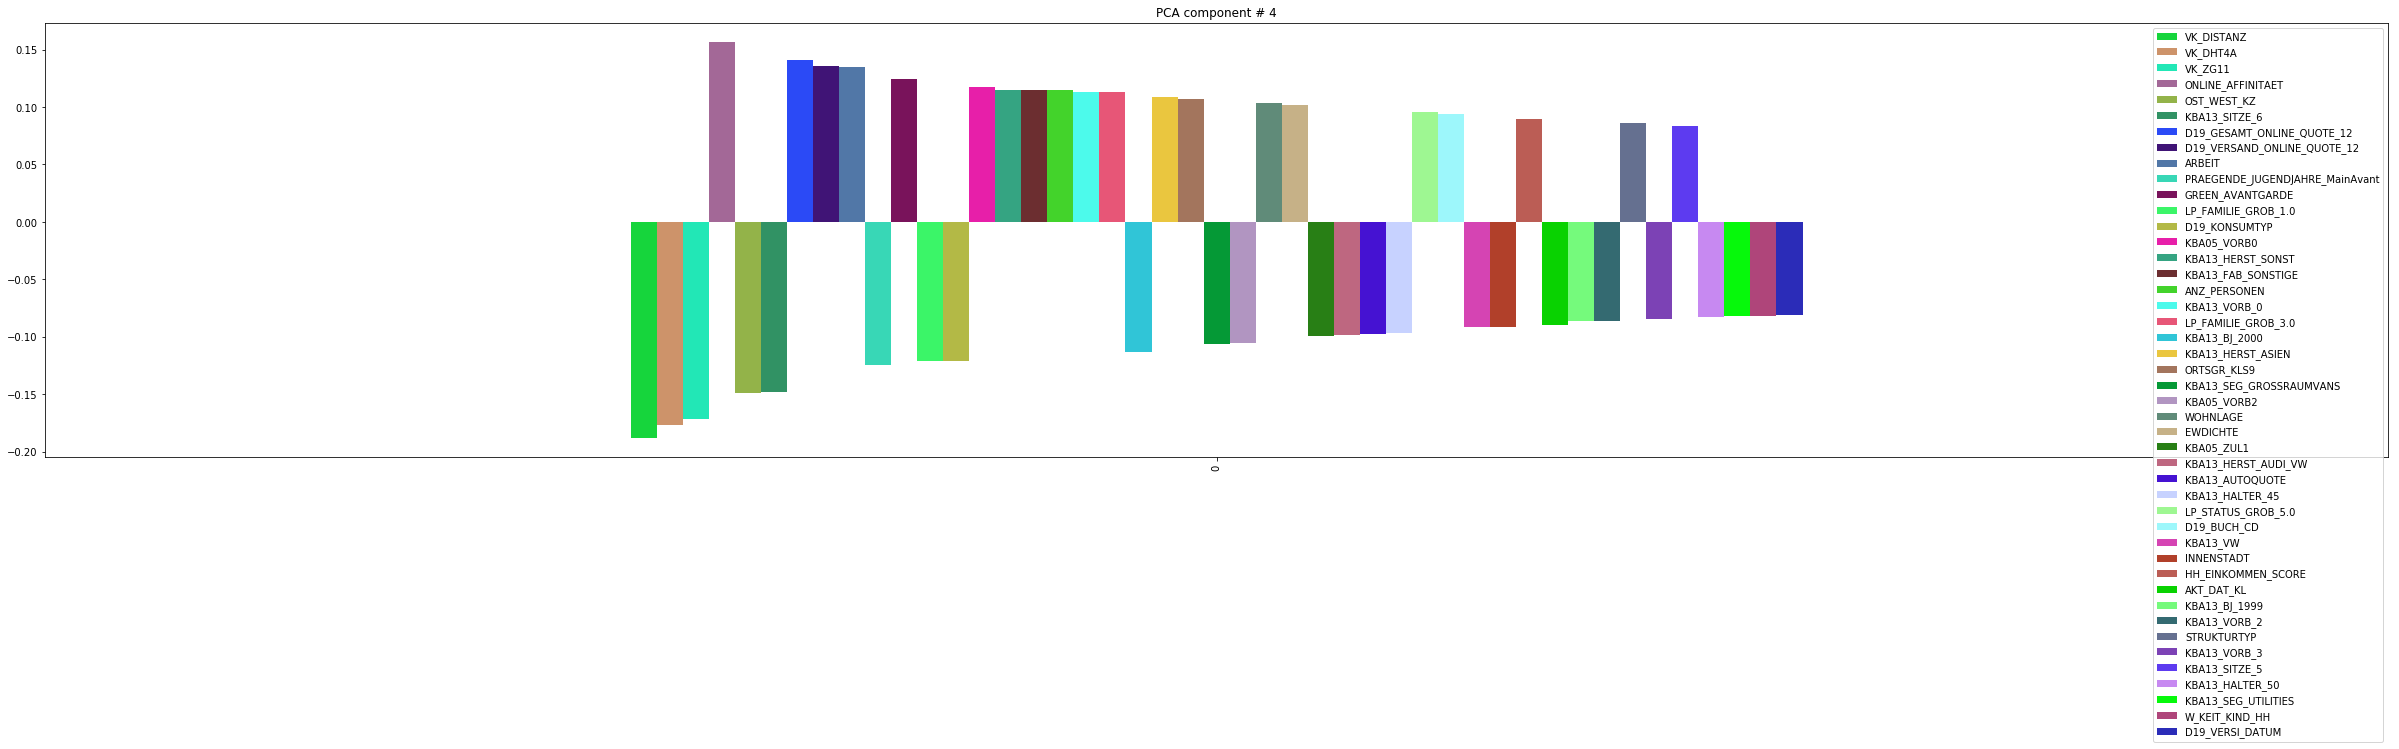

In [57]:
dsh.AnalyzePCAResult(pcaReduced, 3, azClust)

With PCA we found our N vectors with that we can explain our dataset up to 90%. A vector is a principal component and equal to an eigen vector of the data matrix. Each entry in an eigen vector represents a feature. The higher the absulte, the higher the feature is driving this component (having an large influence on the pc/vectors direction).

Two features both having positive signs means that they are positively correlated. That means if feature X increases, then feature Y increates.
On the other hand there might be negatively correlated features and that means if X increaes, Y decreases.

I will interpret the first three components.


Results from first submit for the first principal component:

Positive:  KBA13_ANTG1 0.13287799994073335  - Negative:  MOBI_REGIO -0.1413470544968964
Positive:  PLZ8_ANTG1 0.13285037030531835  - Negative:  ANZ_HAUSHALTE_AKTIV -0.13697320532121682
Positive:  LP_STATUS_GROB 0.13233742431770154  - Negative:  ANZ_STATISTISCHE_HAUSHALTE -0.13558719688942802
Positive:  MOBI_RASTER 0.13063143326697485  - Negative:  KBA13_ANTG3 -0.13303447356231998
Positive:  HH_EINKOMMEN_SCORE 0.12908204856395805  - Negative:  PLZ8_ANTG3 -0.13254118873140058
Positive:  KBA05_ANTG1 0.128482350816456  - Negative:  KBA13_ANTG4 -0.12886600141945365
Positive:  KBA05_GBZ 0.12381366601190492  - Negative:  PLZ8_ANTG4 -0.12682190772454793
Positive:  KBA05_AUTOQUOT 0.12378926922533495  - Negative:  FINANZ_MINIMALIST -0.11234066544002844
Positive:  KBA13_AUTOQUOTE 0.12117735285183613  - Negative:  EWDICHTE -0.11095347728539558
Positive:  LP_LEBENSPHASE_GROB_Income 0.11752208321569954  - Negative:  ORTSGR_KLS9 -0.10980048027579437
Positive:  FINANZ_HAUSBAUER 0.10765455155311503  - Negative:  CAMEO_INTL_2015_Wealth_5.0 -0.10611507985557994
Positive:  GEMEINDETYP 0.10742586071861886  - Negative:  VK_DISTANZ -0.10035941645835471

We can see that positive/negative has switched. That means that now persons who:
- tend to live in areas with an high share of 1-2 family-houses and low share of >5 family houses in the micro/macro cell and the plz 8 region, be homeowners/top earners, with a low movement rate and a lower population density, have a higher income and don't tend to be no financial minimalists.

DECREASE the component. People who live in areas with high movement rates, high share of >5 family houses, being financial minimalists etc increase the component.

The first description for this latent feature was:
This feature describes setteled families with an income over average don't having any financial problems.
but now it is the opposite:
This feature describes families who might have not enough money to by a home/flat/appartment, tending to have a lower income  and might have financial problem, they are financial minimalists.


PCA 1: People described by this component
- are more likely to be advertising and consumption minimalist/traditionalists than advertisingintereset or cross-channel enthusiasts, but showing a high online affinity, they do not tend to be a money safer, investor or inconspicuous but rather to be financially prepared, and the 80s/90s were the dominating movement in the persons youth.

This feature describes people who are mid-aged (30-40), online interested but don't tend to be cross-channel enthusiasts.


PCA 2: The score for this component increases when people
- seem to be those who have expensive cars (very likely to be sport cars because this component says it's very unlikely that these cars have five or four seats), the engines in those cars tend to be huge (over 2500ccm) and the maximum speeds tends to be over 250km rather than limited to 210 km/h, it's very unlikely that those persons tend to be under 30 years, they tend to be over 60, the manufacturers Opel, Ford, and asia pacific cars are rarely present.

This feature describes older persons who tend to be pensioners and like to drive fast sport cars.

### Clustering - KMeans

Now I use KMeans to find centroids in the pca transformed data.

In [58]:
from sklearn.metrics import silhouette_score

In [59]:
def ClusterData(data, maxClusterSize = 20, minClusterSize = 2):
    '''
    Uses kmeans to cluster data.
    
    INPUT: 
    data: Dataframe
    maxClusterSize: max number of clusters to calculate
    '''
    km = []
    kAverages = []
    kPredicts = []
    kInertia = []
    
    dsh.PrintLine()
    
    tmpData = data
    
    clusterNumbers = list(np.arange(minClusterSize, maxClusterSize + 1, 1))
    for ind in clusterNumbers:
        start = datetime.now()
        print('Prediction for {} clusters started {}'.format(ind, start))

        kmeans = KMeans(n_clusters = ind, random_state = 47, n_jobs = -1)

        kPredicts.append(kmeans.fit_predict(tmpData))
        
        # compute the average within-cluster distances.
        tmpAver = abs((kmeans.score(tmpData)))
        kAverages.append(tmpAver)
        kInertia.append(kmeans.inertia_)
        km.append(kmeans)

        dsh.PrintLine('Prediction for {} clusters with average {} took: {}'.format(ind, tmpAver, datetime.now() - start))
        dsh.PrintLine()
    print('-' * 40)
    
    return km, kAverages, kPredicts, kInertia

def ClusterDataMini(data, maxClusterSize = 25, minClusterSize = 2):
    '''
    Uses kmeans to cluster data.
    
    INPUT: 
    data: Dataframe
    maxClusterSize: max number of clusters to calculate
    '''
    km = []
    kAverages = []
    kPredicts = []
    kInertia = []
    silSc = []


    dsh.PrintLine()
    
    tmpData = data
    
    clusterNumbers = list(np.arange(minClusterSize, maxClusterSize + 1, 1))
    for ind in clusterNumbers:
        start = datetime.now()
        print('Prediction for {} clusters started {}'.format(ind, start))

        kmeans = MiniBatchKMeans(n_clusters = ind, random_state = 47)

        kPredicts.append(kmeans.fit_predict(tmpData))

        silSc.append(silhouette_score(tmpData, kPredicts[len(kPredicts) - 1], sample_size = 10000))
        
        # compute the average within-cluster distances.
        tmpAver = abs((kmeans.score(tmpData)))
        kAverages.append(tmpAver)
        kInertia.append(kmeans.inertia_)
        km.append(kmeans)

        dsh.PrintLine('Prediction for {} clusters with average {} took: {}'.format(ind, tmpAver, datetime.now() - start))
        dsh.PrintLine()
    print('-' * 40)
    
    return km, kAverages, kPredicts, kInertia, silSc

def PlotKMeanScores(results, maxClusterSize):
    '''
    Plot KMean results.
    results: Array where [1] contains scores
    maxClusterSize: Used clusters
    '''
    plt.figure(figsize = (15, 10))
    plt.ylabel('Cluster Score')
    plt.xlabel('Clusters')
    plt.ylim(int(min(results[1])) - 5, int(max(results[1])) + 5, 5)

    #x=[2*v for v in range(10)]
    ticks = [2 * v for v in range(int(maxClusterSize / 2) - 1)]
    tick2 = [2 * (v + 1) for v in range(int(maxClusterSize / 2) - 1)]

    plt.xticks(ticks, tick2)
    plt.style.context('seaborn-whitegrid')
    _ = plt.plot(results[1], marker = 'o', color = 'b')

In [ ]:
kmBig = ClusterData(azPcaReduced, maxClusterSize = 12)

In [ ]:
ax = pd.DataFrame(kmBig[1], columns = ['ClusterScores']).plot(marker = 'o', figsize = (10, 10))

In [60]:
kmMini = ClusterDataMini(azPcaReduced, maxClusterSize = 40)

-------------------- - --------------------
Prediction for 2 clusters started 2018-12-26 16:47:48.314831
-------------------- Prediction for 2 clusters with average 267751088.0952898 took: 0:00:06.036834 --------------------
-------------------- - --------------------
Prediction for 3 clusters started 2018-12-26 16:47:54.351665
-------------------- Prediction for 3 clusters with average 262147024.70579728 took: 0:00:06.314118 --------------------
-------------------- - --------------------
Prediction for 4 clusters started 2018-12-26 16:48:00.665783
-------------------- Prediction for 4 clusters with average 257382219.9341639 took: 0:00:06.092711 --------------------
-------------------- - --------------------
Prediction for 5 clusters started 2018-12-26 16:48:06.758494
-------------------- Prediction for 5 clusters with average 253844596.84558445 took: 0:00:06.212394 --------------------
-------------------- - --------------------
Prediction for 6 clusters started 2018-12-26 16:48:12.

-------------------- Prediction for 38 clusters with average 234667386.3575677 took: 0:00:06.902006 --------------------
-------------------- - --------------------
Prediction for 39 clusters started 2018-12-26 16:51:54.864815
-------------------- Prediction for 39 clusters with average 240887387.97749934 took: 0:00:06.779102 --------------------
-------------------- - --------------------
Prediction for 40 clusters started 2018-12-26 16:52:01.643917
-------------------- Prediction for 40 clusters with average 232266310.3913199 took: 0:00:07.037314 --------------------
-------------------- - --------------------
----------------------------------------


Text(0.5,1,'Score KMiniBatch')

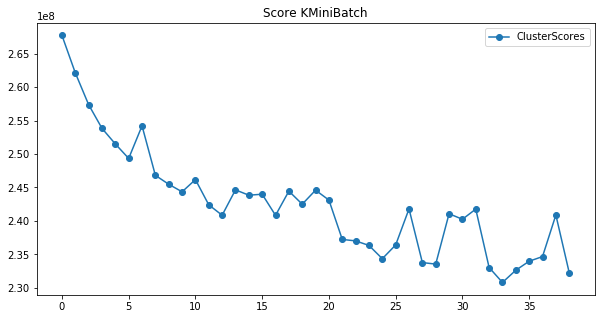

In [65]:
ax = pd.DataFrame(kmMini[1], columns = ['ClusterScores']).plot(marker = 'o', figsize = (10, 5))
ax.set_title('Score KMiniBatch')

Text(0.5,1,'Silhouette Score')

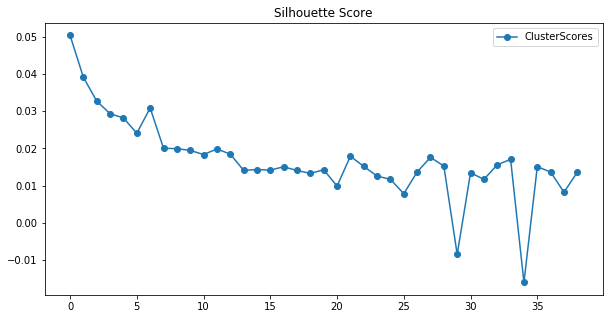

In [62]:
ax = pd.DataFrame(kmMini[4], columns = ['ClusterScores']).plot(marker = 'o', figsize = (10, 5))

ax.set_title('Silhouette Score')

The first plots show the average within-cluster distances from each point to their assigned cluster's centroid, the seccond plot shows the silhouette score (suggested from my first reviewer). The score is computed as: (b - a)/(max(a,b). The outputs are between -1 and 1 and mean: 1 best value, 0 overlapping clusters , -1 worst value.

Having a look at the Silhouette plot, the score is between 0.05 and -0.04, mostly around 0.01. (Honestly, I cannot see how the silhouette metric helps me expect showing me that almost each cluster is overlapping and I don't know what needed to be fixed to increate the silhouette score...)

The KMiniBatch plot shows 

One idea before was to implement this method https://www.linkedin.com/pulse/finding-optimal-number-clusters-k-means-through-elbow-asanka-perera/ as I did for the first submit.

Finally, I decided to use 22 clusters because the difference between the score for 22 clusters and 30 clusters or more is marginal, so I don't see any benefit of using more than 22 clusters.

UPDATE:
    
I decided now to keep 14 clusters (for explanation I refer to my blog entry. I added some lines via paint to the plots above).

In [ ]:
def FindBestCluster(kAverages, nbrClusters, nbrMinClusters = 2):
    # Find Point p with max(dist(p, L)) where L = Line between P_c2 and P_cNbrClusters
    '''
    y = mx + b
    m = (y2 - y1) / (x2 - x1) where x2 > x1
    b = y - mx
    '''
    m = (kAverages[len(kAverages) - 1] - kAverages[0]) / (nbrClusters - nbrMinClusters)
    b = kAverages[len(kAverages) - 1] - m * nbrClusters

    m_ = -1 / m
    maxDist = 0
    print('-' * 40)

    for ind in range(len(kAverages)):
        x = ind + 2
        y = kAverages[ind]

        # Calculate new line
        b_ = y - m_ * x

        # Calc cut: m*x + b = m_*x + b_
        # <=> b - b_ = x * (m_ - m)
        # <=> x = (b - b_) / (m_ - m)
        cut_x = (b - b_) / (m_ - m)
        cut_y = m * cut_x + b

        # Distance: sqrt(x^2 + y^2)
        dist = math.sqrt((cut_x - x) * (cut_x - x) + (cut_y - y) * (cut_y - y))

        print('Distance P{} ({} cluster) to line: '.format(ind, x), dist)

        if dist > maxDist:
            maxDist = dist
            _usedComponents2 = ind
        elif dist <= maxDist:
            continue
    
    return _usedComponents2 + nbrMinClusters

In [ ]:
nbrUsedCluster = FindBestCluster(kmBig[1], nbrMinClusters = 2, nbrClusters = 16)
nbrUsedCluster

As mentioned above, I will use 22 clusters.

In [66]:
nbrUsedCluster = 14

In [67]:
# kmWork = kmResultWholeSet[0][4]
kmWork = KMeans(n_clusters = nbrUsedCluster, random_state = 47, n_jobs = -1)

kmWork.fit_transform(azPcaReduced)

array([[24.632216  , 24.87701196, 24.26911561, ..., 23.43673521,
        22.35442331, 21.06579351],
       [17.71996132, 19.15343265, 17.8301028 , ..., 16.01934949,
        16.47383666, 17.54339247],
       [14.13365178, 19.49604034, 17.17233517, ..., 16.40334985,
        16.70318588, 20.04927911],
       ...,
       [19.65814101, 23.24369763, 19.78285298, ..., 19.31147074,
        17.42715312, 20.28486256],
       [22.74561739, 21.04434345, 22.54423717, ..., 22.40603625,
        20.1056713 , 16.20511616],
       [16.76718823, 17.29630201, 19.26715502, ..., 18.89249169,
        18.44832484, 19.28390185]])

In [68]:
len(kmWork.cluster_centers_)

14

### Cluster Customers

In [72]:
cusClust = PrepareForSegmentation(customers)

for col in azClust.columns:
    if not col in cusClust:
        print('Column not contained, adding with default value 0: ', col)
        cusClust[col] = 0
        
custPca = Impute(cusClust, False)
custPca = Scale(custPca, False)

custPca = pcaReduced.transform(custPca.values)

-------------------- Start converting missing values to nan --------------------
CAMEO_DEUG_2015 - [-1, '-1', '-1.0', None, 'X'] - 50554 - 0
Converted to float:  CAMEO_DEUG_2015
CAMEO_INTL_2015 - [-1, '-1', '-1.0', None, 'XX'] - 50554 - 0
Converted to float:  CAMEO_INTL_2015
HEALTH_TYP - [-1, '-1', '-1.0', 0, '0', '0.0', -1, -1.0] - 48990 - 0
KBA05_ALTER1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_ALTER2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_ALTER3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_ALTER4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_ANHANG - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 871 - 0
KBA05_AUTOQUOT - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 934 - 0
KBA05_CCM1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_CCM2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_CCM3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_CCM4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 933 - 0
KBA05_DIESEL - ['-1', -1.0, '-1

-------------------- Convert undocumented values to nan --------------------
-------------------- Finished --------------------
-------------------- Start finding and removing columns matchting to wildcards: ['LNR', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM', 'VERDICHTUNGSRAUM', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ', 'AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL', 'D19_KOSMETIK', 'D19

-------------------- - --------------------
current column:  MOBI_REGIO
-------------------- Applying reorder on MOBI_REGIO: {1: 6.0, 2: 5.0, 3: 4.0, 4: 3.0, 5: 2.0, 6: 1.0} --------------------
Having meanings:  ['very high mobility']  -  ['very high mobility', 'high mobility', 'middle mobility', 'low mobility', 'very low mobility ']
-------------------- - --------------------
current column:  REGIOTYP
-------------------- Applying reorder on REGIOTYP: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'upper class', 'conservatives', 'upper middle class', 'middle class', 'lower middle class', 'traditional workers']
-------------------- - --------------------
current column:  RETOURTYP_BK_S
-------------------- Applying reorder on RETOURTYP_BK_S: {1: 5.0, 2: 4.0, 3: 3.0, 4: 2.0, 5: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'influenceable Crazy-Shopper', 'demanding Heavy-Returner', 'in

Size after encoding:  273
Columns successfully one hot encoded :)  New columns are:  ['CAMEO_DEUG_2015_1.0', 'CAMEO_DEUG_2015_2.0', 'CAMEO_DEUG_2015_3.0', 'CAMEO_DEUG_2015_4.0', 'CAMEO_DEUG_2015_5.0', 'CAMEO_DEUG_2015_6.0', 'CAMEO_DEUG_2015_7.0', 'CAMEO_DEUG_2015_8.0', 'CAMEO_DEUG_2015_9.0']
Removed columns after one hot encoding:  ['CAMEO_DEUG_2015']
-------------------- Finished applying one-hot encoding --------------------
-------------------- Start applying one-hot encoding on: ['CAMEO_INTL_2015_Ages'] --------------------
Columns before one hot encoding:  273
Columns to be removed and replaced:  ['CAMEO_INTL_2015_Ages']
Size after encoding:  277
Columns successfully one hot encoded :)  New columns are:  ['CAMEO_INTL_2015_Ages_1.0', 'CAMEO_INTL_2015_Ages_2.0', 'CAMEO_INTL_2015_Ages_3.0', 'CAMEO_INTL_2015_Ages_4.0', 'CAMEO_INTL_2015_Ages_5.0']
Removed columns after one hot encoding:  ['CAMEO_INTL_2015_Ages']
-------------------- Finished applying one-hot encoding ------------------

-------------------- Finished applying one-hot encoding --------------------
--------------------  --------------------
Feature does not exist anymore: LP_FAMILIE_FEIN
-------------------- - --------------------
-------------------- Start applying one-hot encoding on: ['LP_FAMILIE_GROB'] --------------------
Columns before one hot encoding:  361
Columns to be removed and replaced:  ['LP_FAMILIE_GROB']
Size after encoding:  363
Columns successfully one hot encoded :)  New columns are:  ['LP_FAMILIE_GROB_1.0', 'LP_FAMILIE_GROB_2.0', 'LP_FAMILIE_GROB_3.0']
Removed columns after one hot encoding:  ['LP_FAMILIE_GROB']
-------------------- Finished applying one-hot encoding --------------------
--------------------  --------------------
Feature does not exist anymore: LP_LEBENSPHASE_FEIN
-------------------- - --------------------
--------------------  --------------------
Feature does not exist anymore: LP_LEBENSPHASE_GROB
-------------------- - --------------------
--------------------  --

In [73]:
kMeanPredictCust = kmWork.predict(custPca)

In [74]:
kMeanPredictAzdias = kmWork.predict(azPcaReduced)

In [75]:
np.bincount(kMeanPredictAzdias)

array([72810, 36861, 32432, 62281, 43806, 54749, 71982, 67773, 73572,
       35417, 36826, 61845, 62425, 63968], dtype=int64)

In [76]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

demBinCount = np.bincount(kMeanPredictAzdias)
demDic = {}
for ind in range(len(demBinCount)):
    demDic[ind] = demBinCount[ind] * 100 / azRun.shape[0]

In [77]:
custBinCount = np.bincount(kMeanPredictCust)
custDic = {}
for ind in range(len(custBinCount)):
    custDic[ind] = custBinCount[ind] * 100 / cusClust.shape[0]

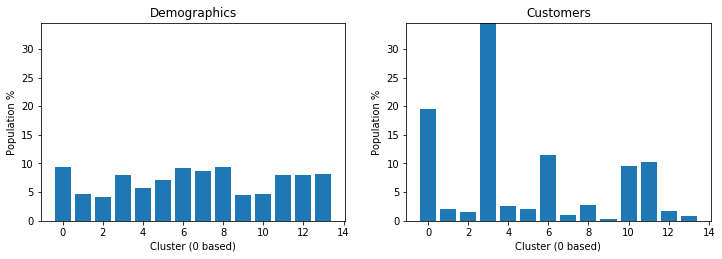

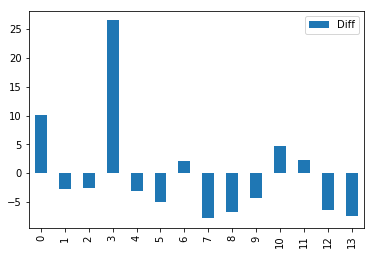

In [78]:
maxY = max([max(demDic.values()), max(custDic.values())])

fig1 = plt.figure(figsize = (12, 8))
ax1 = fig1.add_subplot(2, 2, 1)
plt.ylabel('Population %')
plt.xlabel('Cluster (0 based)')
plt.title('Demographics')
ax1.set_ylim(0, maxY)
_ = ax1.bar(list(demDic.keys()), list(demDic.values()))

ax2 = fig1.add_subplot(2, 2, 2)
plt.ylabel('Population %')
plt.xlabel('Cluster (0 based)')
plt.title('Customers')
ax2.set_ylim(0, maxY)
_ = plt.bar(list(custDic.keys()), list(custDic.values()))

clustDiff = []
for ind in range(0, len(custDic)):
    clustDiff.append(list(custDic.values())[ind] - list(demDic.values())[ind])   
ax = pd.DataFrame({'Diff' : clustDiff}).plot(kind='bar')

In [79]:
ovRep = {}
unRep = {}

limit = 0.3
limOv, limUn = 1 + limit, 1 - limit

for ind in range(len(custDic.keys())):
    tmp = custDic[ind] / demDic[ind]
    if tmp >= limOv:
        ovRep[ind] = tmp
    elif tmp <= limUn:
        unRep[ind] = tmp

print('-' * 40)
if len(ovRep) > 0 or len(unRep) > 0:
    if len(ovRep) > 0:
        print('Overrepresented clusters (index zero based): ', ovRep)
    if len(unRep) > 0:
        if len(ovRep) > 0:
            print('-' * 20)
        print('Underrepresented clusters (index zero based): ', unRep)
else:
    print('No over/underrepresented clusters found.')
print('-' * 40)

----------------------------------------
Overrepresented clusters (index zero based):  {0: 2.0850368776425032, 3: 4.301452668883969, 10: 2.0026896306731894}
--------------------
Underrepresented clusters (index zero based):  {1: 0.4218155471749716, 2: 0.37490662572518074, 4: 0.464133959748793, 5: 0.2843023204497968, 7: 0.10866440063034738, 8: 0.2969640536624247, 9: 0.07539888498906701, 12: 0.21397815780406398, 13: 0.09290425686796946}
----------------------------------------


In [80]:
# To get the original values back from a cluster center, I multiply center_element_i with pca_component_i (eigenvector)
# and sum it up to get the point in the original data.

def PrintClusterPcaAssigned(_clust):
    '''
    Print cluster components.
    _clust: Cluster center 
    '''
    dic = {}
    for ind, val in enumerate(list(_clust)):
        dic[val] = ind # dirty way, I know... 
    print('Weights for PCs with 0 based index:')
    for val in sorted(list(dic.keys())):
        print ('Weight for principal component ', dic[val], ': ', val)
    return


In [81]:
for ind, val in enumerate(kmWork.cluster_centers_):
    dsh.PrintLine('Cluster center {}'.format(ind))
    
    c3orig = pcaReduced.inverse_transform(val)
    invScale = CleanConfig.Scaler.inverse_transform(c3orig)
    
    for ind2 in range(len(invScale)):
        print(azClust.columns[ind2], ', ', invScale[ind2])

-------------------- Cluster center 0 --------------------
AKT_DAT_KL ,  2.9284433837771138
ANZ_HAUSHALTE_AKTIV ,  0.9905766714670944
ANZ_HH_TITEL ,  0.005305092382290912
ANZ_KINDER ,  0.08115141142362853
ANZ_PERSONEN ,  1.9135004568845397
ANZ_STATISTISCHE_HAUSHALTE ,  0.9746912380794979
ANZ_TITEL ,  0.0020895597657933584
ARBEIT ,  2.2150298295501742
BALLRAUM ,  5.587329013730726
CJT_KATALOGNUTZER ,  3.7589581945324055
CJT_TYP_1 ,  2.1835247490093037
CJT_TYP_2 ,  1.760004145120972
CJT_TYP_3 ,  4.4230647911455865
CJT_TYP_4 ,  4.04139947001106
CJT_TYP_5 ,  4.391828299102638
CJT_TYP_6 ,  4.3556624518977465
D19_BANKEN_ONLINE_QUOTE_12 ,  0.392190643663597
D19_BUCH_CD ,  2.1285792378226187
D19_GESAMT_ONLINE_QUOTE_12 ,  2.5422635450072564
D19_KONSUMTYP ,  5.338631426453487
D19_SOZIALES ,  0.8246377129725022
D19_TELKO_ONLINE_QUOTE_12 ,  0.01551316030586285
D19_VERSAND_ONLINE_QUOTE_12 ,  2.243427561479646
D19_VERSI_DATUM ,  8.877430576759792
D19_VERSI_OFFLINE_DATUM ,  9.917220273790926
D19_VERS

CAMEO_INTL_2015_Wealth_3.0 ,  0.04895493892241799
CAMEO_INTL_2015_Wealth_4.0 ,  0.2863336481524428
CAMEO_INTL_2015_Wealth_5.0 ,  0.6014908739087041
CJT_GESAMTTYP_1.0 ,  0.24711797255300968
CJT_GESAMTTYP_2.0 ,  0.3154479914026982
CJT_GESAMTTYP_3.0 ,  0.10264791026951048
CJT_GESAMTTYP_4.0 ,  0.15480811711537656
CJT_GESAMTTYP_5.0 ,  0.09907279816926962
CJT_GESAMTTYP_6.0 ,  0.07579475621143017
D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_DIREKT ,  0.017480787599901182
D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_GROSS ,  0.0075184752206258
D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_LOKAL ,  0.0009663360083019045
D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST ,  0.0027075821830781182
D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_GEH ,  0.008424115524188373
D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_REST ,  0.022275490418332478
D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG ,  0.0005792805419520235
D19_LETZTER_KAUF_BRANCHE_D19_BIO_OEKO ,  0.0011492029622070673
D19_LETZTER_KAUF_BRANCHE_D19_BUCH_CD ,  0.030468904969976757
D19_LETZTER_KAUF_BRA

KBA05_MOD1 ,  1.8282784221117656
KBA05_MOD2 ,  3.031002488939713
KBA05_MOD3 ,  2.961583561840183
KBA05_MOD4 ,  2.725152373223224
KBA05_MOD8 ,  1.4976154682092697
KBA05_MOTRAD ,  1.2707071867616329
KBA05_VORB0 ,  3.5223638167682085
KBA05_VORB1 ,  2.911996607242014
KBA05_VORB2 ,  2.1234061671192257
KBA05_ZUL1 ,  2.584817261129928
KBA05_ZUL2 ,  3.041969176162035
KBA05_ZUL3 ,  3.0720360425213094
KBA05_ZUL4 ,  2.6676363422322935
KBA13_ANTG1 ,  2.6796509524358023
KBA13_ANTG2 ,  2.6207078488268687
KBA13_ANTG3 ,  1.2085307241697305
KBA13_ANTG4 ,  0.3508565442193597
KBA13_ANZAHL_PKW ,  6.446266382403773
KBA13_AUDI ,  3.0703714263904285
KBA13_AUTOQUOTE ,  2.997175786832188
KBA13_BJ_1999 ,  2.6593456610982424
KBA13_BJ_2000 ,  2.5202700971380674
KBA13_BJ_2004 ,  3.085283595108072
KBA13_BJ_2006 ,  3.247663042531377
KBA13_BJ_2008 ,  2.8754032445504016
KBA13_BJ_2009 ,  2.7794552788965374
KBA13_BMW ,  3.38421675903834
KBA13_CCM_1000 ,  2.1604401921570218
KBA13_CCM_1200 ,  2.0708800225216852
KBA13_CCM_

D19_LETZTER_KAUF_BRANCHE_D19_BUCH_CD ,  0.05475977478799067
D19_LETZTER_KAUF_BRANCHE_D19_DIGIT_SERV ,  0.0033564175636208986
D19_LETZTER_KAUF_BRANCHE_D19_DROGERIEARTIKEL ,  0.031839592258433996
D19_LETZTER_KAUF_BRANCHE_D19_ENERGIE ,  0.01961186811403955
D19_LETZTER_KAUF_BRANCHE_D19_FREIZEIT ,  0.011824204876274388
D19_LETZTER_KAUF_BRANCHE_D19_GARTEN ,  0.005478864479385711
D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK ,  0.0035735987034657395
D19_LETZTER_KAUF_BRANCHE_D19_HAUS_DEKO ,  0.03798892535181891
D19_LETZTER_KAUF_BRANCHE_D19_KINDERARTIKEL ,  0.012037753883660036
D19_LETZTER_KAUF_BRANCHE_D19_KOSMETIK ,  0.0010978098232596561
D19_LETZTER_KAUF_BRANCHE_D19_LEBENSMITTEL ,  0.010616445414739337
D19_LETZTER_KAUF_BRANCHE_D19_LOTTO ,  0.0006217609196750983
D19_LETZTER_KAUF_BRANCHE_D19_NAHRUNGSERGAENZUNG ,  0.0055054481544111675
D19_LETZTER_KAUF_BRANCHE_D19_RATGEBER ,  0.004377833335467352
D19_LETZTER_KAUF_BRANCHE_D19_REISEN ,  0.003844852414021088
D19_LETZTER_KAUF_BRANCHE_D19_SAMMELARTIKEL ,  0.

KBA13_SITZE_6 ,  3.0445020396045073
KBA13_TOYOTA ,  3.1313106883564226
KBA13_VORB_0 ,  2.974280101771674
KBA13_VORB_1 ,  2.913404601222052
KBA13_VORB_1_2 ,  2.941502643639151
KBA13_VORB_2 ,  3.131570660087606
KBA13_VORB_3 ,  2.61140996883122
KBA13_VW ,  2.754951605766398
KKK ,  2.0496564180812364
KOMBIALTER ,  3.9566980876769438
KONSUMNAEHE ,  2.35276200055598
MIN_GEBAEUDEJAHR ,  7.597538629001058
MOBI_RASTER ,  1.2568531609863
MOBI_REGIO ,  5.133819745513925
ONLINE_AFFINITAET ,  1.3761960140552998
ORTSGR_KLS9 ,  6.601238625326093
REGIOTYP ,  2.8428096254107578
RELAT_AB ,  3.698288745287112
RT_KEIN_ANREIZ ,  2.3875597063856464
RT_SCHNAEPPCHEN ,  3.7657352825015464
RT_UEBERGROESSE ,  1.5647250090080755
SEMIO_DOM ,  3.6227767465859833
SEMIO_ERL ,  2.1924482182470157
SEMIO_FAM ,  4.613297669366028
SEMIO_KAEM ,  3.4122357667730943
SEMIO_KRIT ,  3.2143639335457266
SEMIO_KULT ,  5.0469842217694225
SEMIO_LUST ,  2.161817809504331
SEMIO_MAT ,  4.800774757549317
SEMIO_PFLICHT ,  5.3824622422356

KBA05_VORB2 ,  2.9859786956335643
KBA05_ZUL1 ,  3.0612071867227932
KBA05_ZUL2 ,  2.9578608304606706
KBA05_ZUL3 ,  2.6211671881667176
KBA05_ZUL4 ,  2.0427521075131074
KBA13_ANTG1 ,  2.2681054754573213
KBA13_ANTG2 ,  2.9968420723300087
KBA13_ANTG3 ,  1.5854885814803765
KBA13_ANTG4 ,  0.5496855292067726
KBA13_ANZAHL_PKW ,  6.489355200999752
KBA13_AUDI ,  3.03821758908713
KBA13_AUTOQUOTE ,  2.903045054361951
KBA13_BJ_1999 ,  2.972773408277995
KBA13_BJ_2000 ,  2.9696486636408754
KBA13_BJ_2004 ,  3.003598736461442
KBA13_BJ_2006 ,  3.0011434390833704
KBA13_BJ_2008 ,  2.4672743238113446
KBA13_BJ_2009 ,  2.4446761424679346
KBA13_BMW ,  3.297874546396963
KBA13_CCM_1000 ,  2.4441895266572646
KBA13_CCM_1200 ,  2.328467281191312
KBA13_CCM_1400 ,  2.9625244528409254
KBA13_CCM_1500 ,  2.6070234741025713
KBA13_CCM_1600 ,  2.962539244902053
KBA13_CCM_1800 ,  2.377628063455143
KBA13_CCM_2000 ,  3.144800670930001
KBA13_CCM_2500 ,  2.568753128913346
KBA13_CCM_2501 ,  2.6661851050435272
KBA13_CCM_3000 ,  2

KBA13_KW_120 ,  3.1452484871299333
KBA13_KW_121 ,  4.372436637878058
KBA13_KW_30 ,  1.2520250675696771
KBA13_KW_40 ,  1.6512882109394469
KBA13_KW_50 ,  1.4968436148364448
KBA13_KW_60 ,  1.4750312725767794
KBA13_KW_70 ,  1.7098969133477488
KBA13_KW_80 ,  1.720094824224911
KBA13_KW_90 ,  2.323950845877454
KBA13_MAZDA ,  2.643831006882973
KBA13_MERCEDES ,  4.374964278468178
KBA13_NISSAN ,  2.4154741331912035
KBA13_OPEL ,  1.7165067578324866
KBA13_PEUGEOT ,  3.0558604592710767
KBA13_RENAULT ,  2.4348905043699682
KBA13_SEG_GELAENDEWAGEN ,  3.7353222683733565
KBA13_SEG_GROSSRAUMVANS ,  2.90763915149909
KBA13_SEG_KLEINST ,  1.9434771984903079
KBA13_SEG_KLEINWAGEN ,  1.769530679304554
KBA13_SEG_KOMPAKTKLASSE ,  2.2406900512304473
KBA13_SEG_MINIVANS ,  2.4016565950577866
KBA13_SEG_MINIWAGEN ,  3.1030333933461955
KBA13_SEG_MITTELKLASSE ,  2.9124161629594214
KBA13_SEG_OBEREMITTELKLASSE ,  4.365996448280265
KBA13_SEG_OBERKLASSE ,  4.35517020359928
KBA13_SEG_SONSTIGE ,  3.2360393370020426
KBA13_SEG

KBA05_AUTOQUOT ,  3.9293394482567456
KBA05_CCM1 ,  2.85254400195761
KBA05_CCM2 ,  2.9489900213737408
KBA05_CCM3 ,  3.264113622286287
KBA05_CCM4 ,  1.2108375966277436
KBA05_DIESEL ,  2.449161129365769
KBA05_FRAU ,  2.8949208204701113
KBA05_GBZ ,  4.1465452433221675
KBA05_HERST1 ,  2.3228532575961225
KBA05_HERST2 ,  3.3356147478466824
KBA05_HERST3 ,  3.04331835107274
KBA05_HERST4 ,  2.6469350591288454
KBA05_HERST5 ,  2.5519227328746865
KBA05_KRSAQUOT ,  3.465296572430628
KBA05_KRSHERST1 ,  2.901619978862626
KBA05_KRSHERST2 ,  3.098238432604703
KBA05_KRSHERST3 ,  3.1217267665588055
KBA05_KRSKLEIN ,  2.0003240716294175
KBA05_KRSOBER ,  1.973672981816007
KBA05_KRSVAN ,  2.0425901597751843
KBA05_KRSZUL ,  1.9362815444765733
KBA05_KW1 ,  2.975102614321301
KBA05_KW2 ,  3.0862519594140676
KBA05_KW3 ,  1.3312816150700524
KBA05_MOD1 ,  1.3462717326298164
KBA05_MOD2 ,  3.052428386088316
KBA05_MOD3 ,  2.996489413779157
KBA05_MOD4 ,  2.906175676805404
KBA05_MOD8 ,  1.5280284711641818
KBA05_MOTRAD , 

KBA05_MODTEMP_2.0 ,  0.3059476297669147
KBA05_MODTEMP_3.0 ,  0.37048482360650886
KBA05_MODTEMP_4.0 ,  0.11336106343985618
KBA05_MODTEMP_5.0 ,  0.19206457408606584
LP_FAMILIE_GROB_1.0 ,  0.5846377984996587
LP_FAMILIE_GROB_2.0 ,  0.08114875053641316
LP_FAMILIE_GROB_3.0 ,  0.2978034916892015
LP_STATUS_GROB_1.0 ,  0.9061368103147058
LP_STATUS_GROB_2.0 ,  0.05001282129429521
LP_STATUS_GROB_3.0 ,  0.010777872604185286
LP_STATUS_GROB_4.0 ,  0.019558250008558403
LP_STATUS_GROB_5.0 ,  0.008945695894701122
NATIONALITAET_KZ_1.0 ,  0.23027398673001293
NATIONALITAET_KZ_2.0 ,  0.06688546118006058
NATIONALITAET_KZ_3.0 ,  0.6054620838948694
RETOURTYP_BK_S_1.0 ,  0.2745280690293068
RETOURTYP_BK_S_2.0 ,  0.20680045457189125
RETOURTYP_BK_S_3.0 ,  0.1266361544625157
RETOURTYP_BK_S_4.0 ,  0.12850836655065212
RETOURTYP_BK_S_5.0 ,  0.2589584055020785
SHOPPER_TYP_1.0 ,  0.09057000789170072
SHOPPER_TYP_2.0 ,  0.36251632705868536
SHOPPER_TYP_3.0 ,  0.273391736558756
SHOPPER_TYP_4.0 ,  0.16923880845731976
ZABEOT

In [82]:
PrintClusterPcaAssigned(kmWork.cluster_centers_[7])

Weights for PCs with 0 based index:
Weight for principal component  1 :  -4.481695149195348
Weight for principal component  6 :  -1.1595872497810056
Weight for principal component  10 :  -0.8169987892127953
Weight for principal component  3 :  -0.6952360374916814
Weight for principal component  17 :  -0.5204322442566907
Weight for principal component  8 :  -0.5118723158133693
Weight for principal component  4 :  -0.4839005569209024
Weight for principal component  7 :  -0.38083894145114877
Weight for principal component  32 :  -0.18934498683370518
Weight for principal component  27 :  -0.1797228106829102
Weight for principal component  14 :  -0.17430290808750265
Weight for principal component  37 :  -0.1562591963355074
Weight for principal component  76 :  -0.15099466481463752
Weight for principal component  26 :  -0.1395082563241315
Weight for principal component  64 :  -0.12391537199923583
Weight for principal component  42 :  -0.12270666252428501
Weight for principal component  95 : 

In [83]:
PrintClusterPcaAssigned(kmWork.cluster_centers_[13])

Weights for PCs with 0 based index:
Weight for principal component  5 :  -2.028753160664613
Weight for principal component  1 :  -1.896298712430976
Weight for principal component  7 :  -1.1204757735609587
Weight for principal component  2 :  -1.0532057388035765
Weight for principal component  11 :  -0.9741982277023723
Weight for principal component  3 :  -0.9096400229842343
Weight for principal component  6 :  -0.7623901533448997
Weight for principal component  14 :  -0.34923857748343484
Weight for principal component  21 :  -0.24540173099837012
Weight for principal component  43 :  -0.22148644645307708
Weight for principal component  10 :  -0.21458649542366934
Weight for principal component  18 :  -0.18824005593092777
Weight for principal component  46 :  -0.1562678333896248
Weight for principal component  25 :  -0.15084992034492983
Weight for principal component  40 :  -0.14846561806505187
Weight for principal component  20 :  -0.14141699639837746
Weight for principal component  52 :

In [84]:
PrintClusterPcaAssigned(kmWork.cluster_centers_[0])

Weights for PCs with 0 based index:
Weight for principal component  0 :  -5.95519916137888
Weight for principal component  3 :  -2.7271034000315275
Weight for principal component  2 :  -1.6942290950189718
Weight for principal component  5 :  -0.5328918062101449
Weight for principal component  12 :  -0.4439079746224268
Weight for principal component  29 :  -0.4317869376566255
Weight for principal component  33 :  -0.2635926489735513
Weight for principal component  14 :  -0.23709991885468945
Weight for principal component  24 :  -0.22847229191096818
Weight for principal component  42 :  -0.208516057873062
Weight for principal component  26 :  -0.20101608059520368
Weight for principal component  15 :  -0.16806504276974435
Weight for principal component  52 :  -0.15214876550178189
Weight for principal component  70 :  -0.13652959363876252
Weight for principal component  32 :  -0.13046335175567425
Weight for principal component  8 :  -0.1298410622401921
Weight for principal component  25 : 

In [85]:
PrintClusterPcaAssigned(kmWork.cluster_centers_[3])

Weights for PCs with 0 based index:
Weight for principal component  0 :  -5.520006227634084
Weight for principal component  6 :  -1.4102053924132845
Weight for principal component  14 :  -0.6236730844044215
Weight for principal component  7 :  -0.4825791987713934
Weight for principal component  17 :  -0.40916477762097664
Weight for principal component  21 :  -0.3822975852457032
Weight for principal component  12 :  -0.3525263773485299
Weight for principal component  11 :  -0.35068155925111244
Weight for principal component  5 :  -0.337141876109948
Weight for principal component  18 :  -0.2925610092734555
Weight for principal component  13 :  -0.29157302546195857
Weight for principal component  43 :  -0.2755128175816762
Weight for principal component  73 :  -0.2377018930446338
Weight for principal component  27 :  -0.1731955846403806
Weight for principal component  167 :  -0.17253725962566857
Weight for principal component  30 :  -0.17118738606089376
Weight for principal component  35 :

In [88]:
cusClust['Cluster'] = kMeanPredictCust

In [91]:
azRun['Cluster'] = kMeanPredictAzdias

In [90]:
def PlotCompareClust(df1, df2, df3, df4, columns, kind = 'Bar', fzh = 6, name1 = 'Underrepresented', name2 = 'Overrepresented'):
    '''
    Compare clusters via value counts.
    
    INPUT:
    df1..4: Dataframes
    kind: kind for plot
    fzh: Figure seize height
    name1,2: Titles for left and right
    '''
    lim = 1
    fzh = len(columns) * fzh + 4
    v, h = len(columns), 4
    plt.figure(figsize = (20, fzh - 2))
    for ind, col in enumerate(columns):
        for ind2, df in enumerate([df1, df2, df3, df4]):
            plt.subplot(v, h, h * ind + ind2 + 1)
            ax = (df[col].value_counts().sort_index() / df.shape[0] * 100).plot(kind = kind)
            name = name1 if ind2 < 2 else name2
            ax.set_title(col + '\n{}'.format(name))
            ax.set_ylabel('Percent of whole data set')
            ax.set_ylim(0, 100)

In [92]:
ur1 = azRun[azRun['Cluster'] == 7]
ur2 = azRun[azRun['Cluster'] == 13]
or1 = azRun[azRun['Cluster'] == 0]
or2 = azRun[azRun['Cluster'] == 3]

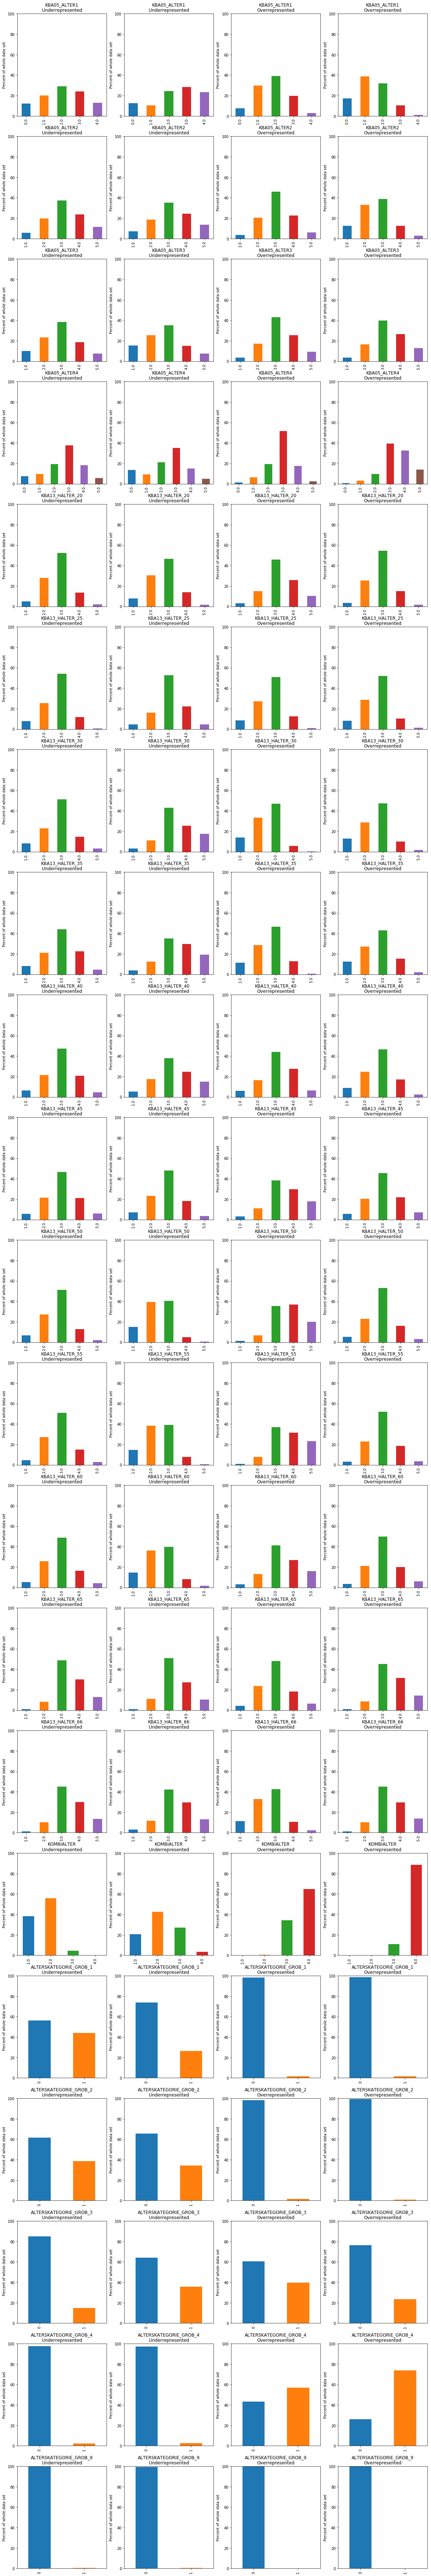

In [93]:
PlotCompareClust(
    ur1,
    ur2, 
    or1,
    or2,
    columns = dsh.GetMatches(azRun.columns, '*alter*'))

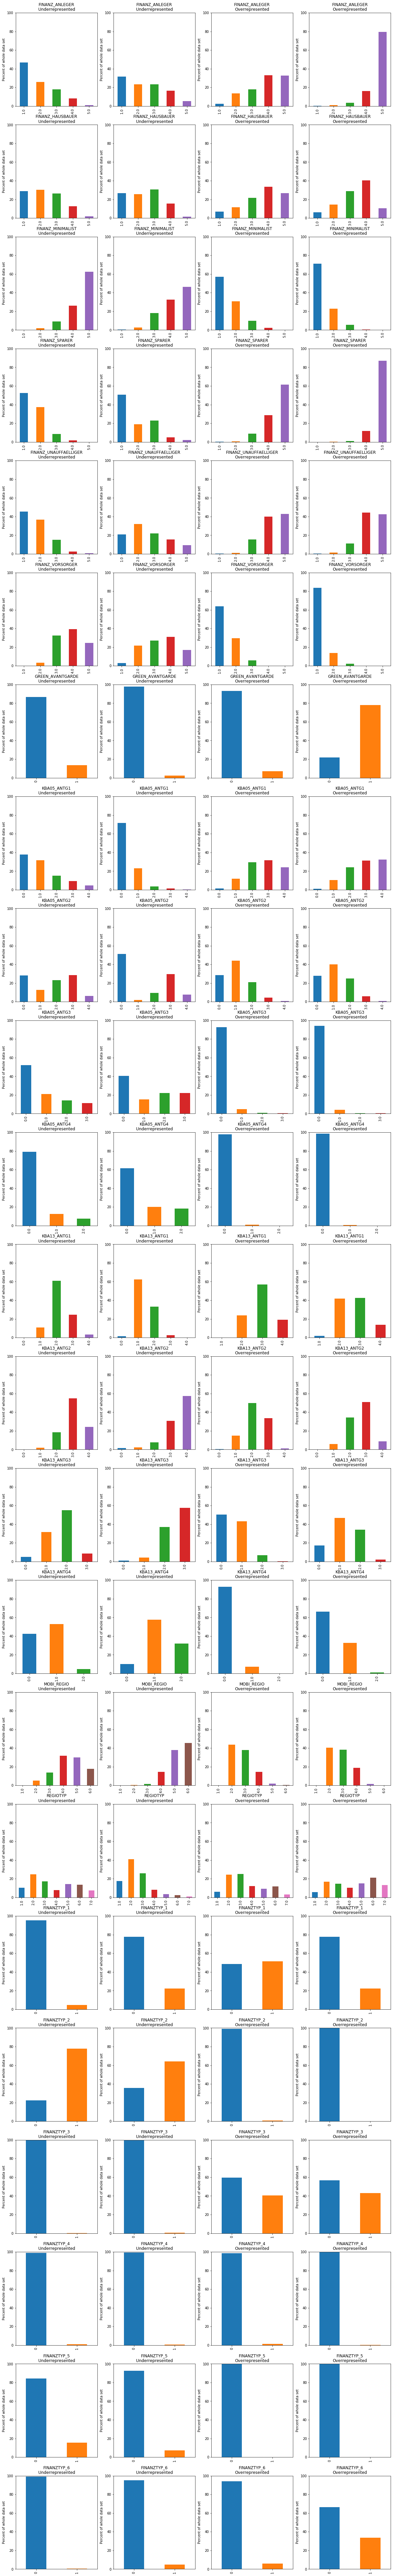

In [94]:
PlotCompareClust(
    ur1,
    ur2, 
    or1,
    or2,
    columns = dsh.GetMatches(azRun.columns, ['*finanz*', '*reg*', '*antg*']))

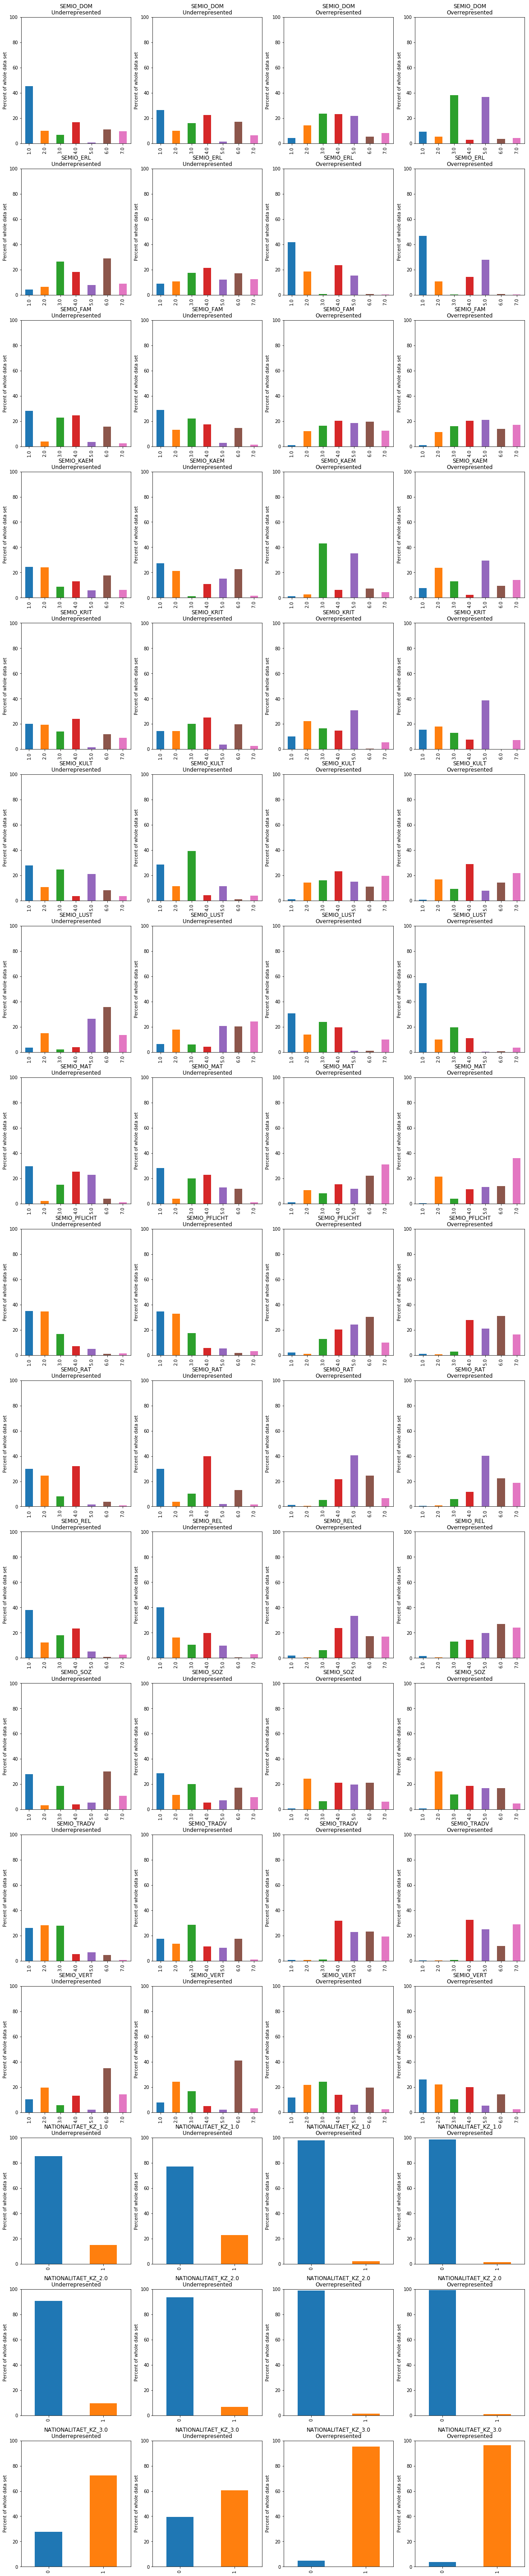

In [95]:
PlotCompareClust(
    ur1,
    ur2, 
    or1,
    or2,
    columns = dsh.GetMatches(azRun.columns, ['*nat*', '*semio*']))

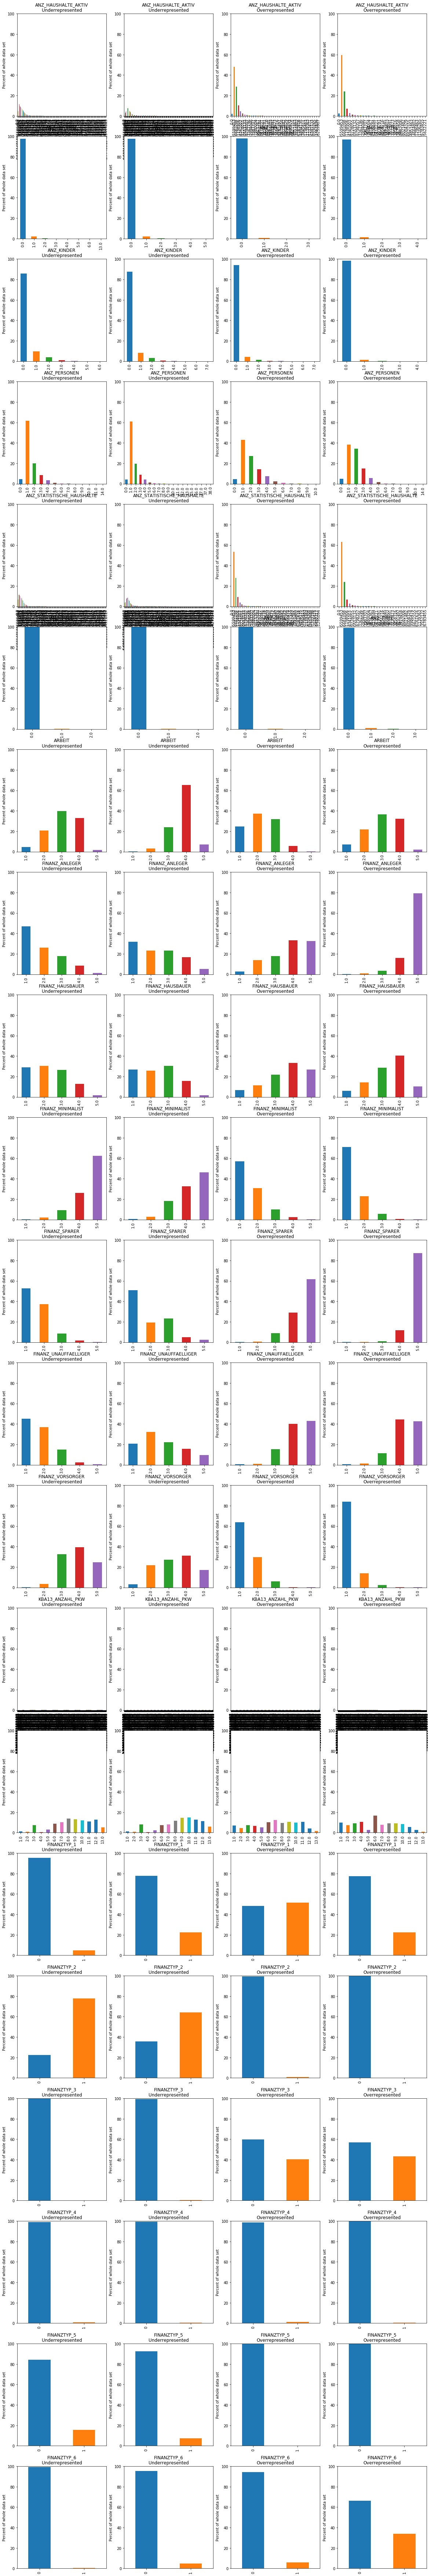

In [96]:
PlotCompareClust(
    ur1,
    ur2, 
    or1,
    or2,
    columns = dsh.GetMatches(azRun.columns, ['*anz*', '*arb*']))

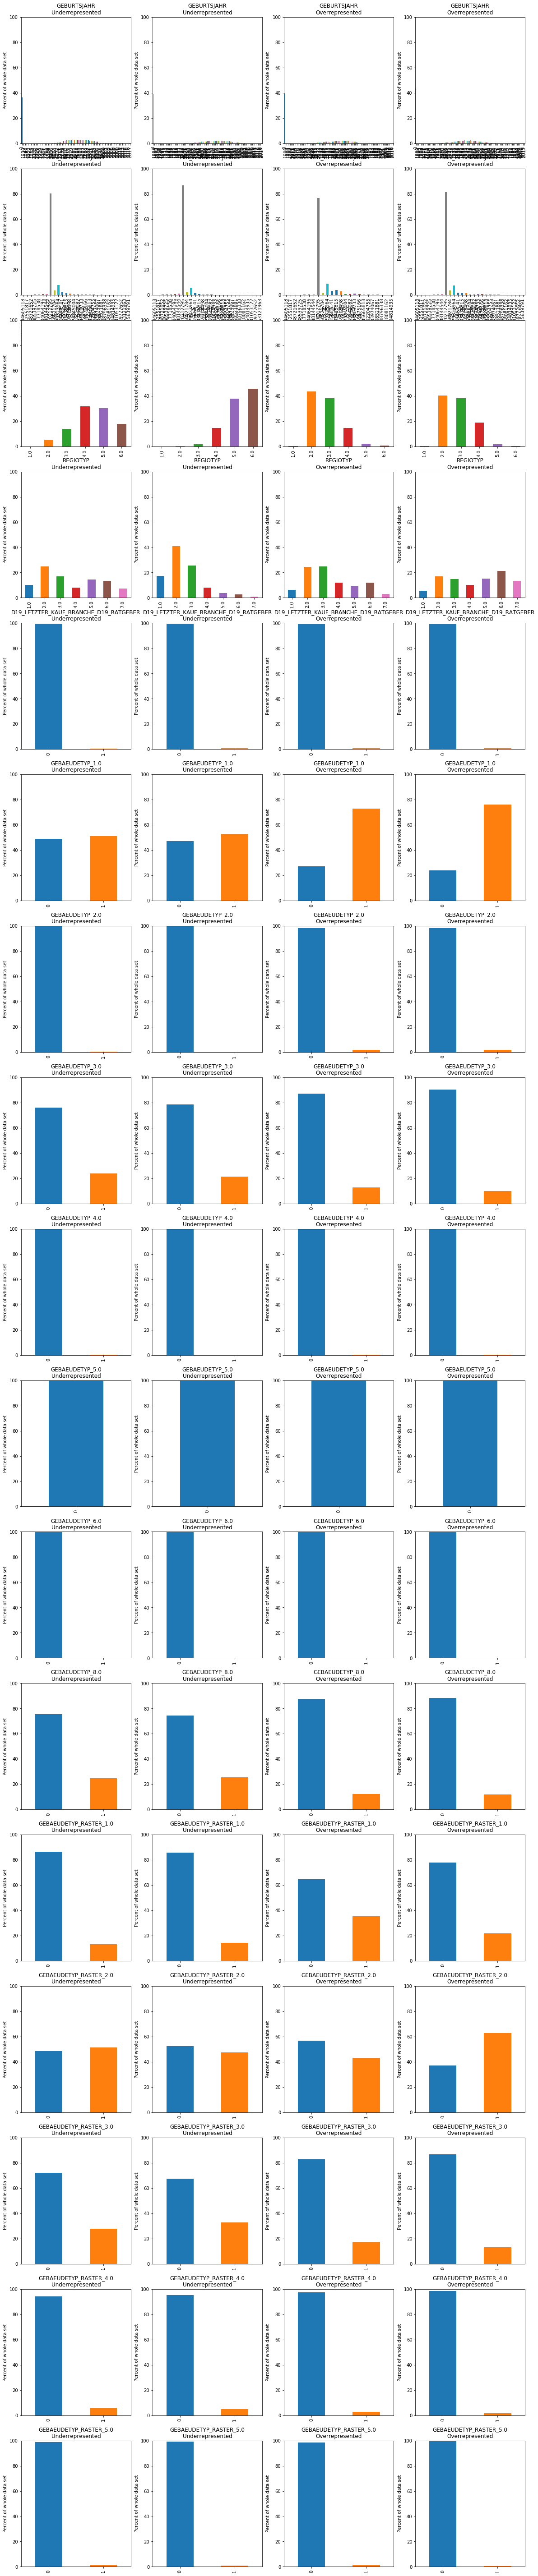

In [97]:
PlotCompareClust(
    ur1,
    ur2, 
    or1,
    or2,
    columns = dsh.GetMatches(azRun.columns, ['*reg*', '*geb*']))

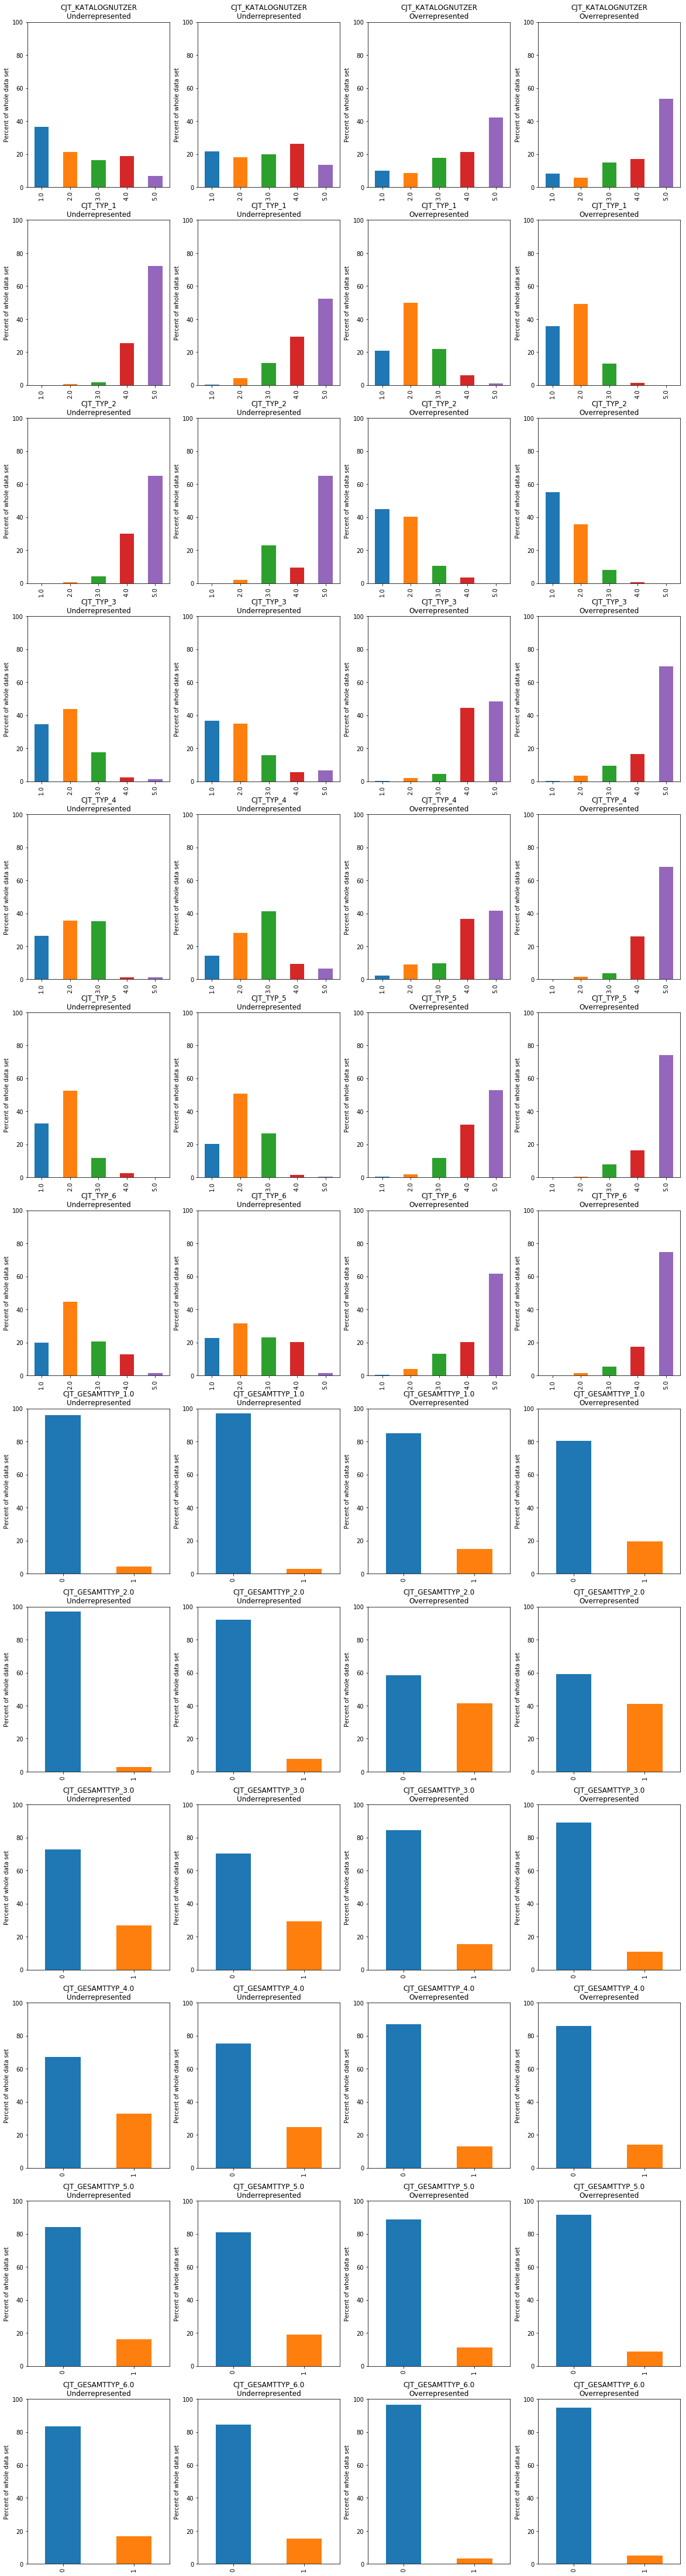

In [98]:
PlotCompareClust(
    ur1,
    ur2, 
    or1,
    or2,
    columns = dsh.GetMatches(azRun.columns, ['*cjt*']))

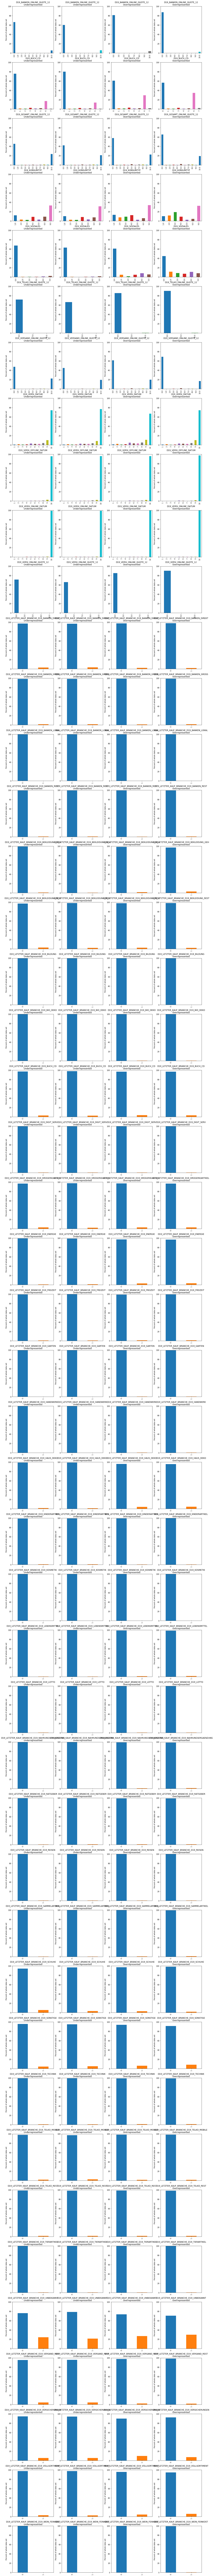

In [99]:
PlotCompareClust(
    ur1,
    ur2, 
    or1,
    or2,
    columns = dsh.GetMatches(azRun.columns, ['*d19*']))

I will refer to the zero based index of the cluster centers I discuss now:

The proportion of data shows differences. The Azdias dataset is almost uniformly distributed ("almost" because the clusters 4, 5 are kind of outliners. The sixth is lower than the average, the fifth is nearly at 10%. 

The AZ Direct customer dataset has a high proportion of cluster 3, 10, 12 and a low proportion of 5, 6, 7 and 2 and 11 are almost equal (just a few percent difference).

So having a look at the diagrams and for example the cluster center 3, I can say that:

The customers seem to be more financial investors, no financial minimalists (over 60% in 5th cluster), but rather money savers. 
This goes along with the fact that FINANZTYP_2, 5 are almost not present, but 3 and 1 are overrepresented.
They tend to be over 45 
ALTERSKATEGORIE is one-hot encoded and the fact that 3/4 are are over .35 and .58 means that these people tend to be over 45, more likely to be 60 (PRAEGENDE_JUGENDJAHRE_Ages 6.3462783537449665). Finally, they live in regions with a low movement rate.


In contrast to these people stand those whoe are described by cluster center 5 and 7. They are younger than 45 and the tendency to be a financial minimalist is very high, being a money saver, investor or a person with a own house in focus is very low. They live in regions with a high share of households with 6 persons and more and a high movement rate. 
All these descriptions go with the fact that people in the underrepresented clusters tend to be not traditional minded, but the people in the overrepresented cluster are highly trad. minded.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [101]:
dsh.GetMatches(azdiasTrain.columns, '*cameo*')

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']

In [102]:
azdiasTrainPrep = PrepareForSegmentation(azdiasTrain, testData = True)

-------------------- Start converting missing values to nan --------------------
CAMEO_DEUG_2015 - [-1, '-1', '-1.0', None, 'X'] - 7899 - 0
Converted to float:  CAMEO_DEUG_2015
CAMEO_INTL_2015 - [-1, '-1', '-1.0', None, 'XX'] - 7899 - 0
Converted to float:  CAMEO_INTL_2015
HEALTH_TYP - [-1, '-1', '-1.0', 0, '0', '0.0', -1, -1.0] - 7397 - 0
KBA05_ALTER1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_ALTER2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_ALTER3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_ALTER4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_ANHANG - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 361 - 0
KBA05_AUTOQUOT - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_CCM1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_CCM2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_CCM3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_CCM4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 383 - 0
KBA05_DIESEL - ['-1', -1.0, '-1.0'

Columns found to remove:  110
-------------------- Finished removing columns matchting to wildcards --------------------
-------------------- Start logscaling --------------------
--------------------  --------------------
Finished logscaling: ['ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']
-------------------- - --------------------
-------------------- Preparing column: CAMEO_INTL_2015 --------------------
24.0    4210
14.0    3674
51.0    3214
41.0    3064
25.0    2455
43.0    2452
45.0    1906
54.0    1856
22.0    1684
13.0    1633
55.0    1546
23.0    1205
15.0    1177
34.0     965
44.0     761
31.0     725
35.0     614
12.0     597
52.0     465
32.0     438
33.0     422
Name: CAMEO_INTL_2015, dtype: int64
4.0    11466
5.0     7698
1.0     7003
3.0     5712
2.0     3184
Name: CAMEO_INTL_2015_Ages, dtype: int64
2.0    9554
4.0    8183
5.0    7081
1.0    7081
3.0    3164
Name: CAMEO_INTL_2015_Wealth, dtype: int64
-------------------- Pre

-------------------- - --------------------
current column:  SEMIO_LUST
-------------------- Applying reorder on SEMIO_LUST: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest affinity', 'very high affinity', 'high affinity', 'average affinity', 'low affinity', 'very low affinity']
-------------------- - --------------------
current column:  SEMIO_MAT
-------------------- Applying reorder on SEMIO_MAT: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest affinity', 'very high affinity', 'high affinity', 'average affinity', 'low affinity', 'very low affinity']
-------------------- - --------------------
current column:  SEMIO_PFLICHT
-------------------- Applying reorder on SEMIO_PFLICHT: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest affinity

-------------------- Start applying one-hot encoding on: ['FINANZTYP'] --------------------
Columns before one hot encoding:  321
Columns to be removed and replaced:  ['FINANZTYP']
Size after encoding:  326
Columns successfully one hot encoded :)  New columns are:  ['FINANZTYP_1', 'FINANZTYP_2', 'FINANZTYP_3', 'FINANZTYP_4', 'FINANZTYP_5', 'FINANZTYP_6']
Removed columns after one hot encoding:  ['FINANZTYP']
-------------------- Finished applying one-hot encoding --------------------
-------------------- Start applying one-hot encoding on: ['GEBAEUDETYP'] --------------------
Columns before one hot encoding:  326
Columns to be removed and replaced:  ['GEBAEUDETYP']
Size after encoding:  331
Columns successfully one hot encoded :)  New columns are:  ['GEBAEUDETYP_1.0', 'GEBAEUDETYP_2.0', 'GEBAEUDETYP_3.0', 'GEBAEUDETYP_4.0', 'GEBAEUDETYP_6.0', 'GEBAEUDETYP_8.0']
Removed columns after one hot encoding:  ['GEBAEUDETYP']
-------------------- Finished applying one-hot encoding -------------

Size after encoding:  382
Columns successfully one hot encoded :)  New columns are:  ['ZABEOTYP_1', 'ZABEOTYP_2', 'ZABEOTYP_3', 'ZABEOTYP_4', 'ZABEOTYP_5', 'ZABEOTYP_6']
Removed columns after one hot encoding:  ['ZABEOTYP']
-------------------- Finished applying one-hot encoding --------------------
-------------------- One-Hot encoding successfully finished --------------------


In [103]:
TrainPrepLabels = azdiasTrainPrep['RESPONSE']

In [104]:
azdiasTrainPrepX = azdiasTrainPrep.drop('RESPONSE', axis = 1)

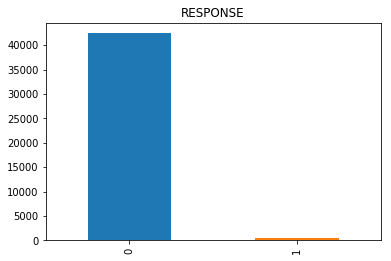

In [105]:
ax = TrainPrepLabels.value_counts().plot(kind = 'bar')
_ = ax.set_title('RESPONSE')

#### Models
I decided to use ensemble methods because they combine different models to one. For example the basis model that RandomForest/Adaboost/GradientBoosting-Classifiers build on is decision trees. They can be used for regression as well as for classification that is needed here. 

Beside these three models, I added LogisticRegression because I was interested into that performance.

#### Metric

Regression metrics like Mean Average Error, Root Mean Square Error, .. cannot be used as we have a binary classification problem. 
For classification, there are metrics like Precison-Recall, ROC_AUC, Log-Loss but we will use ROC_AUC curve. 
AUC_ROC stands for "Area Under the Receiver Operating Characteristic curve". ROC plots the true positive rate against the false positive rate by various thresholds and the area under this curve describes the accuracy of the model as the maximum area is 1x1. A perfect classifier creates a dot in the top left corner (100% correct predicted with 0 false positives). The worse the model, the closer to the diagonal.

#### Model evaluation
I decided to use learning_curve from scikit learn as the documentation says: 

A cross-validation generator splits the whole dataset k times in training and test data. Subsets of the training set with varying sizes will be used to train the estimator and a score for each training subset size and the test set will be computed. Afterwards, the scores will be averaged over all k runs for each training subset size.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve

Update:

My first score was bad (nearly circa 60%), to improve the score, my reviewer recommendet https://www.kaggle.com/qianchao/smote-with-imbalance-data. 

I implemented this in the existing function but uncommented the part because following exception comes up:

This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

My understanding of train_sizes=np.linspace(.1, 1.0, numTrain) is that we pass the % of "1" we like to have in train and that the data will be splitted. Then, I was unsure if I need to shuffe the data again. That's why I call after sm.fit_sample again the shuffe method. And now, the error does not occurr.

In [106]:
rndom = 42
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(random_state = rndom), 
    'AdaBoostClassifier': AdaBoostClassifier(random_state = rndom), 
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state = rndom),
}

In [200]:
def ShuffleData(X, y):
    '''
    Shuffles data.

    INPUT:
    X: DataFrame
    y: Series
        
    OUTPUT:
    X2: shuffled DataFrame X
    y2: shuffled Series y2
    '''
    X2 = pd.concat([X,y], axis=1)
    X2 = X2.sample(frac=1, random_state=42)
    y2 = X2["RESPONSE"]
    X2 = X2.drop(["RESPONSE"], axis=1)
    return X2, y2

def TrainModels(trainX, trainY, models, useSmote = False):
    dsh.PrintEncapsulate(list(models.keys()), header = 'Start training with models:')
    results = []
    
#     X, y = ShuffleData(azdiasTrainPrepX, TrainPrepLabels)
        
#     X = Impute(X, False)
#     X = Scale(X, False)
    
    for name, mod in models.items():
        
        #X, y = ShuffleData(X, y)
        X, y = ShuffleData(trainX, trainY)
        
        if not 'GEBAEUDETYP_5.0' in X.columns:
            X['GEBAEUDETYP_5.0'] = 0
        
        X = Impute(X, False)
        X = Scale(X, False)
        colsX = X.columns
        if useSmote:
    #         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
            sm = SMOTE(random_state=2)
            X, y = sm.fit_sample(X, y.ravel())
            X = pd.DataFrame(data = X, columns = colsX)
            X, y = ShuffleData(X, pd.Series(y, name = 'RESPONSE'))
        print(len(y), y.sum())
    
        numTrain = 10
        
        dtstart = datetime.now()
        
        print('{} started trainig: {}'.format(name, dtstart))
        
        trainSizes, trainScores, testScores = learning_curve(
            mod, 
            X, 
            y, 
            cv = None,
            n_jobs = -1,
            scoring = 'roc_auc', 
            train_sizes=np.linspace(.1, 1.0, numTrain)
        )
        
        print('Finished trainig: {}'.format(datetime.now() - dtstart))
        
        train_scores_mean = np.mean(trainScores, axis=1)
        test_scores_mean = np.mean(testScores, axis=1)
        print("Roc_auc train score = {}".format(train_scores_mean[-1].round(2)))
        print("Roc_auc validation score = {}".format(test_scores_mean[-1].round(2)))

        plt.grid()

        plt.title("Learning Curves")
        plt.xlabel("% of training set")
        plt.ylabel("Score")

        plt.plot(np.linspace(.1, 1.0, numTrain)*100, train_scores_mean, 'o-', color="g",
                 label="Training score")
        plt.plot(np.linspace(.1, 1.0, numTrain)*100, test_scores_mean, 'o-', color="y",
                 label="Cross-validation score")

        plt.yticks(np.arange(0.45, 1.02, 0.05))
        plt.xticks(np.arange(0., 100.05, numTrain))
        plt.legend(loc="best")
        print("")
        plt.show()
        
        results.append((trainSizes, trainScores, testScores, mod))
        
    return results

-------------------- Start training with models: --------------------
['LogisticRegression', 'RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier']
-------------------- - --------------------
84860 42430
LogisticRegression started trainig: 2018-12-26 20:58:59.366933
Finished trainig: 0:06:36.075797
Roc_auc train score = 0.87
Roc_auc validation score = 0.86



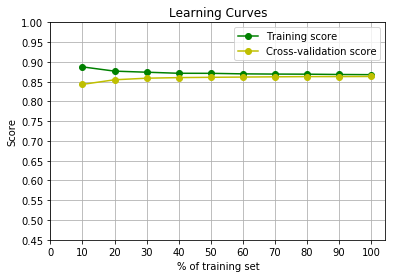

84860 42430
RandomForestClassifier started trainig: 2018-12-26 21:05:38.006806
Finished trainig: 0:00:58.123431
Roc_auc train score = 0.99
Roc_auc validation score = 0.99



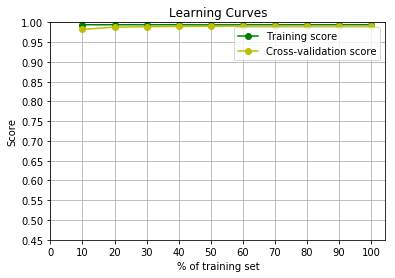

84860 42430
AdaBoostClassifier started trainig: 2018-12-26 21:06:38.636139
Finished trainig: 0:07:35.594368
Roc_auc train score = 0.98
Roc_auc validation score = 0.98



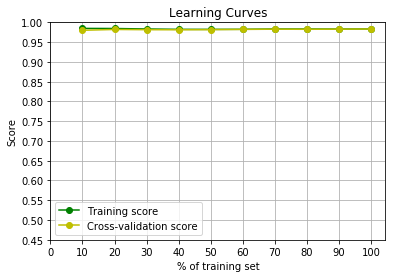

84860 42430
GradientBoostingClassifier started trainig: 2018-12-26 21:14:16.760294
Finished trainig: 0:17:42.196384
Roc_auc train score = 0.99
Roc_auc validation score = 0.99



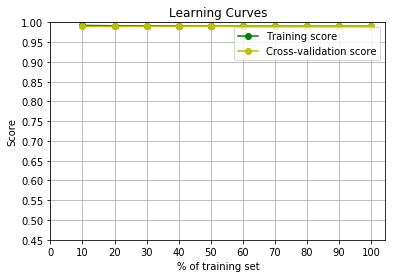

[(array([ 5657, 11314, 16971, 22628, 28286, 33943, 39600, 45257, 50914,
         56572]), array([[0.88949972, 0.8863006 , 0.8863006 ],
         [0.87738716, 0.87626571, 0.87626571],
         [0.87412013, 0.87381812, 0.87381812],
         [0.87121606, 0.87121983, 0.87121983],
         [0.87125061, 0.87101595, 0.87098084],
         [0.86953181, 0.86922027, 0.87047281],
         [0.86958811, 0.86853403, 0.86947708],
         [0.86905571, 0.86840889, 0.86938454],
         [0.86803278, 0.86765471, 0.86884366],
         [0.86756344, 0.86677803, 0.86880294]]), array([[0.84427051, 0.84523049, 0.83986861],
         [0.85589699, 0.85682814, 0.85146421],
         [0.86026505, 0.85959627, 0.85637857],
         [0.86129643, 0.86178358, 0.85767339],
         [0.86210033, 0.86269366, 0.8582346 ],
         [0.86264696, 0.86320739, 0.85905371],
         [0.8629544 , 0.86380379, 0.8599844 ],
         [0.86368092, 0.86410883, 0.86054869],
         [0.86352215, 0.86433764, 0.86062401],
         [0.8640241

In [201]:
TrainModels(azdiasTrainPrepX, TrainPrepLabels, models, True)

-------------------- Start training with models: --------------------
['LogisticRegression', 'RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier']
-------------------- - --------------------
LogisticRegression started trainig: 2018-12-26 18:29:53.034608
Finished trainig: 0:02:08.680161
Roc_auc train score = 0.82
Roc_auc validation score = 0.63



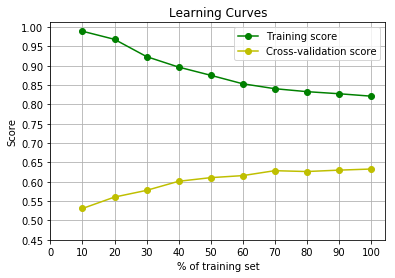

RandomForestClassifier started trainig: 2018-12-26 18:32:03.602418
Finished trainig: 0:00:11.950661
Roc_auc train score = 0.99
Roc_auc validation score = 0.51



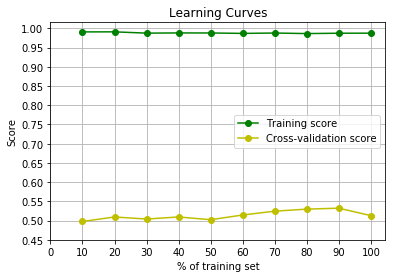

AdaBoostClassifier started trainig: 2018-12-26 18:32:17.398212
Finished trainig: 0:01:42.809775
Roc_auc train score = 0.84
Roc_auc validation score = 0.72



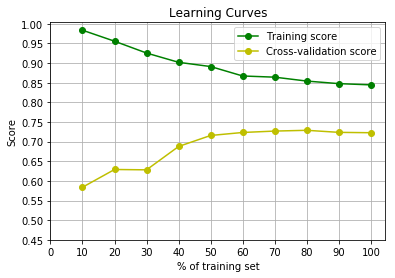

GradientBoostingClassifier started trainig: 2018-12-26 18:34:02.050147
Finished trainig: 0:06:25.908533
Roc_auc train score = 0.92
Roc_auc validation score = 0.76



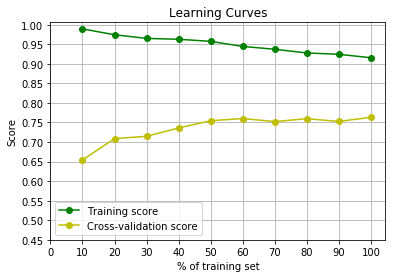

[(array([ 2864,  5728,  8592, 11456, 14320, 17184, 20048, 22912, 25776,
         28640]), array([[0.98608357, 0.99101448, 0.99101448],
         [0.97915209, 0.96292864, 0.96292864],
         [0.93712793, 0.91698122, 0.91698122],
         [0.89395675, 0.89795022, 0.89795022],
         [0.85421859, 0.88687653, 0.88527287],
         [0.83503971, 0.8589271 , 0.86655799],
         [0.82222452, 0.8512457 , 0.8488557 ],
         [0.81861175, 0.84590309, 0.83488635],
         [0.81780341, 0.83563282, 0.8298    ],
         [0.81477841, 0.82922507, 0.82045861]]), array([[0.53346955, 0.53528027, 0.52420335],
         [0.55822733, 0.56628841, 0.55702068],
         [0.5640034 , 0.57552657, 0.59401089],
         [0.58790284, 0.59365816, 0.62234497],
         [0.59005407, 0.59451822, 0.64750924],
         [0.61338631, 0.59472914, 0.63977308],
         [0.64967994, 0.5884147 , 0.64808208],
         [0.65677192, 0.58601828, 0.63684376],
         [0.66129522, 0.59250409, 0.63654017],
         [0.6673374

In [124]:
TrainModels(azdiasTrainPrepX, TrainPrepLabels, models, False)

Lets start with the worst:

The error for RandomForestClassifier is low on the train set (roc score almost 100%), but high on the test set (roc score circa 50%). This means that the model is totally overfitted and we cannot improve the precision by adding more samples. These lines won't come closer.

LogisticRegression and Adaboostclassifier are very similar in this case and better than RandomForest. The training score decreases to 77-79% and test test score increases to 51-56%. 

GradientBoostClassifier scores with 58% in test, 91% in train, so I decide to use this classifier for parameter optimization.

UPDATE:
    
As mentioned above, I decided to treat D19 features value 0 as missing value, dropped PLZ8 columns because I didn't see any benefit of keeping PLZ8 (Munich) information for customers. Additionally, I forgot to one-hot encode some '*TYP' columns. And the results drastically changed.

The plots using SMOTE.. I don't know if I can trust these results because I rather think that I probably implemented the SMOTE not correctly... RandomForestClassifier who was overfitted not using SMOTE, but now with almost 100% score?? 

I refer to the plots based on training NOT using SMOTE. 

LinearRegression is based on bayesian theory of independent probabilities. This algorithms assumes that each feature is independent to others and that P(x|y) = P(x) * P(y). As we can see, only this assumption applied on the data does not score very well.

RandomForestClassifier consists of a bunch of DecisionTrees and this model is completly overfitted. Training score is nearly 100% but train score is +- 50%.

The best models are AdaBoost/GradientBoost-Classifier. These two are ensemble methods. EM use different classifiers during training and those classifiers with the best accuracy will be used. That means that ensemble methods 
stabilize machine learn algorithms and increase their accuracy
and help to reduce overfitting as well as the variance of single estimators because several estimates from several models are combined.

The difference between AdaBoost and GradientBoost is the way weak learners are created. Weak learners are simple models that later will be combined to a good classifier.

Adaboost modifies the distribution of samples by updating the weights attached to each instance. In contrast, GradientBoost trains on the remaining errors. Weak lerners are fitted to these errors and via gradient descent the weights are calculated. Adaboost changes the sample distribution and the weights are increased if the weak lerner predicted bad, and decreased, if the weak learner predicted well.

In [118]:
GradientBoostingClassifier().get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

I decided to use GradientBoosting and decided to train following parameters. 

In [213]:
parameters = {'learning_rate': [0.001, 0.01], 'n_estimators': [50, 100, 500], 
              'max_depth': [3, 5, 8]}

gsX, gsY = azdiasTrainPrepX.copy(deep = True), TrainPrepLabels.copy(deep = True)

gsX = Scale(Impute(gsX))

X_train, X_test, y_train, y_test = train_test_split(gsX, gsY, stratify=gsY, test_size=0.2)

model = GradientBoostingClassifier(random_state = rndom)
gs = GridSearchCV(model, parameters, scoring = 'roc_auc', verbose = 10, n_jobs = -1)

# Fit the grid search object to the training data and find the optimal parameters
gs.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  37 out of  54 | elapsed: 10.7min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done  43 out of  54 | elapsed: 15.9min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  49 out of  54 | elapsed: 24.0min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 31.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.001, 0.01], 'n_estimators': [50, 100, 500], 'max_depth': [3, 5, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [214]:
# Get the estimator and predict
print(gs.best_params_)
best_clf = gs.best_estimator_
best_predictions = best_clf.predict_proba(gsX)[:, 1]

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}


In [215]:
# Make predictions using unoptimized and the best model
predictions = (model.fit(gsX, gsY)).predict_proba(gsX)[:, 1]

print("Roc_auc score on training data: {:.4f}".format(roc_auc_score(TrainPrepLabels, predictions)))
print("Final Roc_auc score on the training data: {:.4f}".format(roc_auc_score(TrainPrepLabels, best_predictions)))

Roc_auc score on training data: 0.8972
Final Roc_auc score on the training data: 0.8390


In [219]:
pkl_filename = "BestGradientBoost_20181227.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(best_clf, file)

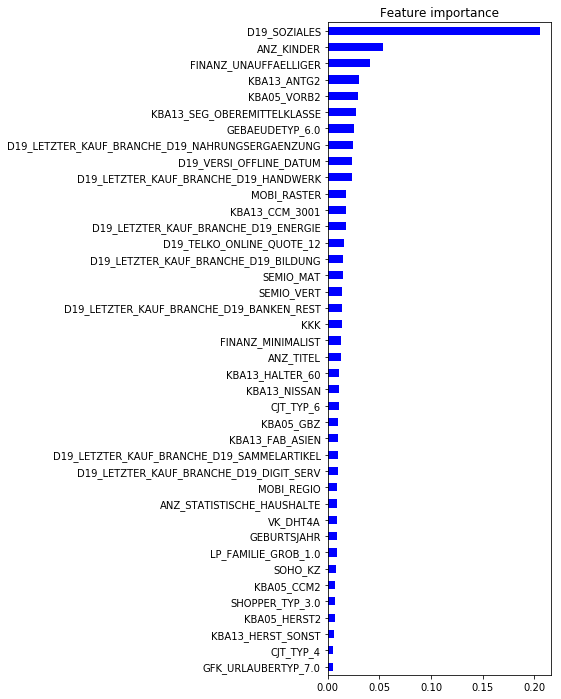

In [220]:
feature_importances = best_clf.feature_importances_

ax = pd.Series(feature_importances, index=azdiasTrainPrep.drop('RESPONSE', axis = 1).columns).sort_values()[-40:].plot(kind='barh', figsize=(4, 12), color='b')
_ = ax.set_title('Feature importance')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [222]:
mailout_test.shape

(42833, 366)

In [223]:
mailout_testPrep = PrepareForSegmentation(mailout_test, testData = True)

-------------------- Start converting missing values to nan --------------------
CAMEO_DEUG_2015 - [-1, '-1', '-1.0', None, 'X'] - 7747 - 0
Converted to float:  CAMEO_DEUG_2015
CAMEO_INTL_2015 - [-1, '-1', '-1.0', None, 'XX'] - 7747 - 0
Converted to float:  CAMEO_INTL_2015
HEALTH_TYP - [-1, '-1', '-1.0', 0, '0', '0.0', -1, -1.0] - 7332 - 0
KBA05_ALTER1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_ALTER2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_ALTER3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_ALTER4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_ANHANG - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 344 - 0
KBA05_AUTOQUOT - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 371 - 0
KBA05_CCM1 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_CCM2 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_CCM3 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_CCM4 - ['-1', -1.0, '-1.0', '9', 9.0, '9.0'] - 370 - 0
KBA05_DIESEL - ['-1', -1.0, '-1.0'

Columns found to remove:  110
-------------------- Finished removing columns matchting to wildcards --------------------
-------------------- Start logscaling --------------------
--------------------  --------------------
Finished logscaling: ['ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']
-------------------- - --------------------
-------------------- Preparing column: CAMEO_INTL_2015 --------------------
24.0    4194
14.0    3734
51.0    3204
41.0    3105
43.0    2497
25.0    2476
45.0    1950
54.0    1843
22.0    1769
13.0    1599
55.0    1536
15.0    1155
23.0    1117
34.0    1003
44.0     699
31.0     675
35.0     600
12.0     591
32.0     459
33.0     451
52.0     429
Name: CAMEO_INTL_2015, dtype: int64
4.0    11473
5.0     7717
1.0     6984
3.0     5664
2.0     3248
Name: CAMEO_INTL_2015_Ages, dtype: int64
2.0    9556
4.0    8251
1.0    7079
5.0    7012
3.0    3188
Name: CAMEO_INTL_2015_Wealth, dtype: int64
-------------------- Pre

-------------------- - --------------------
current column:  SEMIO_KULT
-------------------- Applying reorder on SEMIO_KULT: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest affinity', 'very high affinity', 'high affinity', 'average affinity', 'low affinity', 'very low affinity']
-------------------- - --------------------
current column:  SEMIO_LUST
-------------------- Applying reorder on SEMIO_LUST: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest affinity', 'very high affinity', 'high affinity', 'average affinity', 'low affinity', 'very low affinity']
-------------------- - --------------------
current column:  SEMIO_MAT
-------------------- Applying reorder on SEMIO_MAT: {1: 7.0, 2: 6.0, 3: 5.0, 4: 4.0, 5: 3.0, 6: 2.0, 7: 1.0} --------------------
Having meanings:  ['unknown']  -  ['unknown', 'highest affinity', 've

Size after encoding:  325
Columns successfully one hot encoded :)  New columns are:  ['FINANZTYP_1', 'FINANZTYP_2', 'FINANZTYP_3', 'FINANZTYP_4', 'FINANZTYP_5', 'FINANZTYP_6']
Removed columns after one hot encoding:  ['FINANZTYP']
-------------------- Finished applying one-hot encoding --------------------
-------------------- Start applying one-hot encoding on: ['GEBAEUDETYP'] --------------------
Columns before one hot encoding:  325
Columns to be removed and replaced:  ['GEBAEUDETYP']
Size after encoding:  330
Columns successfully one hot encoded :)  New columns are:  ['GEBAEUDETYP_1.0', 'GEBAEUDETYP_2.0', 'GEBAEUDETYP_3.0', 'GEBAEUDETYP_4.0', 'GEBAEUDETYP_6.0', 'GEBAEUDETYP_8.0']
Removed columns after one hot encoding:  ['GEBAEUDETYP']
-------------------- Finished applying one-hot encoding --------------------
-------------------- Start applying one-hot encoding on: ['GEBAEUDETYP_RASTER'] --------------------
Columns before one hot encoding:  330
Columns to be removed and replaced

In [224]:
pkl_filename = "BestGradientBoost_20181227.pkl"
pickle_model = None

with open(pkl_filename, 'rb') as file:  
    pickle_model = pickle.load(file) 
    

In [225]:
#predict target values
kaggle_predict = pickle_model.predict_proba(Scale(Impute(mailout_testPrep)))[:,1]
len(kaggle_predict)

42833

In [226]:
dfMyPred = pd.DataFrame({'RESPONSES': kaggle_predict})

In [227]:
dfMyPred.to_csv('My_Predictions_20181227_0235.csv')

In [228]:
dfMyPred = mailout_test[['LNR']]

In [229]:
dfMyPred['RESPONSE'] = kaggle_predict

C:\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [230]:
dfMyPred.shape

(42833, 2)

In [231]:
dfMyPred.to_csv('My_Prediction_20181227_0235_WithLNR.csv', index = False)

The final score is: 60.433

With the new data preparation the new score is:

78.084

In [232]:
pkl_filename = "CleanConfig.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(CleanConfig, file)